In [1]:
import numpy as np
import time
import threading
import os
import random
import math
import itertools
import matplotlib.pyplot as plt
import copy
import seaborn as sb

# For checking purposes only
from scipy.spatial.distance import pdist, squareform

In [2]:
# Load full data
path_real_data = "./zipcombo.dat"
data = np.loadtxt(path_real_data)
data_samples = data[:, 1:]; data_labels = data[:, 0]

### Q1.1

In [3]:
# Auxiliary Functions
def polynomial_kernel(train_dat, test_pt, p):
    """
    Computes the polynomial kernel for a given order
    Input:
    train_dat = m x dim array
    test_pt = n x dim vector
    p = polynomial order, scalar
    
    Output:
    result = m x n array, where result[i,j] = K(x_train[i,:], test_pt[j,:])
    
    Note: To allow bulk evaluation for efficiency
    """
    return ((train_dat @ test_pt.T)**p)

def init_mistake_counters(train_data, num_class):
    """
    To use kernels, need only to keep track of the number of times during training (for each perceptron)
    how many times a sample is predicted wrongly (since this many times would its featurised vector be added
    to the 'weight'). This avoids explicitly computing the weight vectors because it needs the feature map computation
    which is not feasible if e.g. gaussian kernel. Furthermore, the predictions later depends on the polarity of the label
    hence our 'counters' is also multiplied by the sample label
    
    Input:
    train_data: only to get number of points
    
    Output:
    matrix of zeros, size = m x num_class. Because keep track for every perceptron
    """
    m = train_data.shape[0]
    return np.zeros((m, num_class))

def class_predict(mistake_counters, kernel_mat):
    """
    Note: y_hat will be vector of -1s and only one 1 at the corresponding class.
    
    Input:
    data_pt = 1 x dim vector to predict
    mistake_counters as above
    kernel_mat = m x 1 array where K[i] = K(xi, data_pt)
    
    Output:
    predictions: vector of -1s and one 1 at the predicted class
    """
    num_class = mistake_counters.shape[1]
    
    inner_term = mistake_counters * kernel_mat
    inner_term = np.sum(inner_term, axis = 0).reshape(-1)
    
    print(inner_term)
    
    pred_class = np.argmax(inner_term)
    
    predictions = -1* np.ones((num_class))
    predictions[pred_class] = 1
    
    return inner_term, predictions

def split_train_test(data_samples, data_labels, train_prop, test_prop, seed = 88):
    """
    Split to 80% train and 20% test as required, randomly by first shuffling
    """
    n_tot = data_samples.shape[0]; n_train = round(train_prop * n_tot)
    
    np.random.seed(seed)
    permute = np.random.permutation(n_tot)
    
    data_shuffled = data_samples[permute,:]
    data_shuffled_labels = data_labels[permute]
    
    train_samples = data_shuffled[:n_train, :]; train_labels = data_shuffled_labels[:n_train]
    test_samples = data_shuffled[n_train:, :]; test_labels = data_shuffled_labels[n_train:]
    
    return train_samples, train_labels, test_samples, test_labels

def split_train_test_q4(data_samples, data_labels, train_prop, test_prop, seed = 88):
    """
    Split to 80% train and 20% test as required, randomly by first shuffling
    """
    n_tot = data_samples.shape[0]; n_train = round(train_prop * n_tot)
    
    np.random.seed(seed)
    permute = np.random.permutation(n_tot)
    
    data_shuffled = data_samples[permute,:]
    data_shuffled_labels = data_labels[permute]
    
    train_samples = data_shuffled[:n_train, :]; train_labels = data_shuffled_labels[:n_train]
    test_samples = data_shuffled[n_train:, :]; test_labels = data_shuffled_labels[n_train:]
    test_indexes = permute[n_train:]
    
    return train_samples, train_labels, test_samples, test_labels, test_indexes

In [4]:
def traingen(train_data, train_labels, mistake_counters, num_classes, kernel_mat_train):
    """
    Performs the num_classes perceptron training for ONE epoch
    
    Returns:
    the updated mistake counters and the number of mistakes in that epoch
    """
    # To reduce recomputation, compute the kernel mat for all pairs of training data outside. Since this don't change
    # every epoch
    
    # initialize mistakes
    mistakes = 0
    
    # Iterate through each data point in an 'online' fashion
    m = train_data.shape[0]
    
    for i in range(m):
        label = int(train_labels[i])
        label_vect = -1 * np.ones((num_classes))
        label_vect[label] = 1
        
        # Prediction vector
        pred_arg = kernel_mat_train[:,i].reshape(1,-1) @ mistake_counters
        
        # Since training processes data one at a time, we can squeeze dimension
        pred_arg = pred_arg.reshape(-1)
        
        pred_class = np.argmax(pred_arg)
        class_mistakes = (pred_arg * label_vect) <= 0
        
        # If mistake for that perceptron, update the corresponding mistake counter. Check each perceptron independently
        # So if mistake on a perceptron, update only that perceptron
        
        # Subtlety: at 0,0,0..0 case, we treat the perceptron as predicting -1 for ALL (this case should never happen
        # in subsequent iterations). i.e. sign(0) is treated as -1. Furthermore, the 0,0,..0 case will always be treated
        # as all perceptrons making a mistake (even though if all -1, then all but one should be correct). Finally, if all
        # 3 perceptrons outputs are equal, we treat it as predicting the first class
        
        mistake_counters[i,class_mistakes] -=  (2*(pred_arg[class_mistakes] > 0) - 1)
        
        if pred_class != label:
            mistakes += 1
        
    return mistake_counters, mistakes/m

def testclassifiers(train_samples, test_samples, test_labels, mistake_counters, num_classes, kernel_mat):
        """
        Predict on the whole test sample batch
        """
        # Get shapes
        n_test = test_samples.shape[0]
        
        # Compute kernel matrix outside, again don't change per epoch
        
        # Bulk predict on the whole test labels
        inner_term = kernel_mat.T @ mistake_counters
        
        # Class predictions
        class_pred = np.argmax(inner_term, axis = 1)
        
        # Count mistakes
        mistakes = np.sum(test_labels != class_pred)
        
        # Return average mistakes
        return mistakes /n_test
    
def testclassifiers2(train_samples, test_samples, test_labels, mistake_counters, num_classes, kernel_mat):
        """
        Predict on the whole test sample batch. Also returns the predicted labels
        """
        # Get shapes
        n_test = test_samples.shape[0]
        
        # Compute kernel matrix outside, again don't change per epoch
        
        # Bulk predict on the whole test labels
        inner_term = kernel_mat.T @ mistake_counters
        
        # Class predictions
        class_pred = np.argmax(inner_term, axis = 1)
        
        # Count mistakes
        mistakes = np.sum(test_labels != class_pred)
        
        # Return average mistakes
        return mistakes /n_test, class_pred
    
def train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                  , num_classes, kernel_mat_train, kernel_mat_test, n_epochs):
    
    m = train_samples.shape[0]
    old_error = 2 # error can't exceed 100%
    threshold = 2/m # i.e. if no more than this improvement over several epochs, we early stop
    duration = 3
    elapsed = 0
    
    for epoch in range(n_epochs):
        mistake_counters, mistakes = traingen(train_samples, train_labels, mistake_counters, num_classes, kernel_mat_train)
        test_rate, test_preds = testclassifiers2(train_samples, test_samples, test_labels, mistake_counters, num_classes, kernel_mat_test)
        print(f"Epoch {epoch}, made {mistakes} mistakes on training data and mistake rate of {test_rate} on test data")
        
        curr_error = mistakes
        diff = old_error - curr_error
        
        if diff <= threshold:
            elapsed += 1
        else:
            elapsed = 0
            
        old_error = curr_error
        
        if elapsed >= duration:
            print(f"Early stopping at {epoch} epochs")
            break
            
    train_rate, train_preds = testclassifiers2(train_samples, train_samples, train_labels, mistake_counters, num_classes, kernel_mat_train)
    
    return mistake_counters, train_rate, train_preds, test_rate, test_preds

def train_nepochs_exp(train_samples, train_labels, test_samples, test_labels, mistake_counters
                  , num_classes, kernel_mat_train, kernel_mat_test, n_epochs, early_stopping = True):
    
    m = train_samples.shape[0]
    old_error = 2 # error can't exceed 100%
    threshold = 2/m # i.e. if no more than this improvement over several epochs, we early stop
    duration = 3
    elapsed = 0
    
    train_rates = []; test_rates = []
    
    for epoch in range(n_epochs):
        mistake_counters, mistakes = traingen(train_samples, train_labels, mistake_counters, num_classes, kernel_mat_train)
        test_rate, test_preds = testclassifiers2(train_samples, test_samples, test_labels, mistake_counters, num_classes, kernel_mat_test)
        print(f"Epoch {epoch}, made {mistakes} mistakes on training data and mistake rate of {test_rate} on test data")
        train_rates.append(mistakes); test_rates.append(test_rate)
        
        curr_error = mistakes
        diff = old_error - curr_error
        
        if diff <= threshold:
            elapsed += 1
        else:
            elapsed = 0
            
        old_error = curr_error
        
        if elapsed >= duration:
            if early_stopping:
                print(f"Early stopping at {epoch} epochs")
                break
            
    
    return mistake_counters, train_rates, test_rates

In [204]:
#### TO DO: Here, add one iteration run for some epochs, and plot errors to show convergence or overfitting for all d's. Also
# the final test error for each of the 20 iteration (plot vs iterations). Also, put the training epoch in a function, and re-evaluate
# on training set after training stops. Implement early stopping

d_range = 1 + np.arange(7)
num_classes = 10; n_epochs = 100
train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = 8)

d = 6
mistake_counters = init_mistake_counters(train_samples, num_classes)
kernel_mat_train = polynomial_kernel(train_samples, train_samples, d)
kernel_mat_test = polynomial_kernel(train_samples, test_samples, d)
mistake_counters, train_rates, test_rates = train_nepochs_exp(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                                          , num_classes, kernel_mat_train, kernel_mat_test, n_epochs, False)



Epoch 0, made 0.11884915299811777 mistakes on training data and mistake rate of 0.08494623655913978 on test data
Epoch 1, made 0.02648561441247647 mistakes on training data and mistake rate of 0.07311827956989247 on test data
Epoch 2, made 0.0026888948642108095 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 3, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 4, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 9, made 0.0 mistakes on training data and mistake ra

Epoch 83, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 84, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 85, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 86, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 87, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 88, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 89, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 90, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 91, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 92, made 0.0 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 93, made 0.0 m

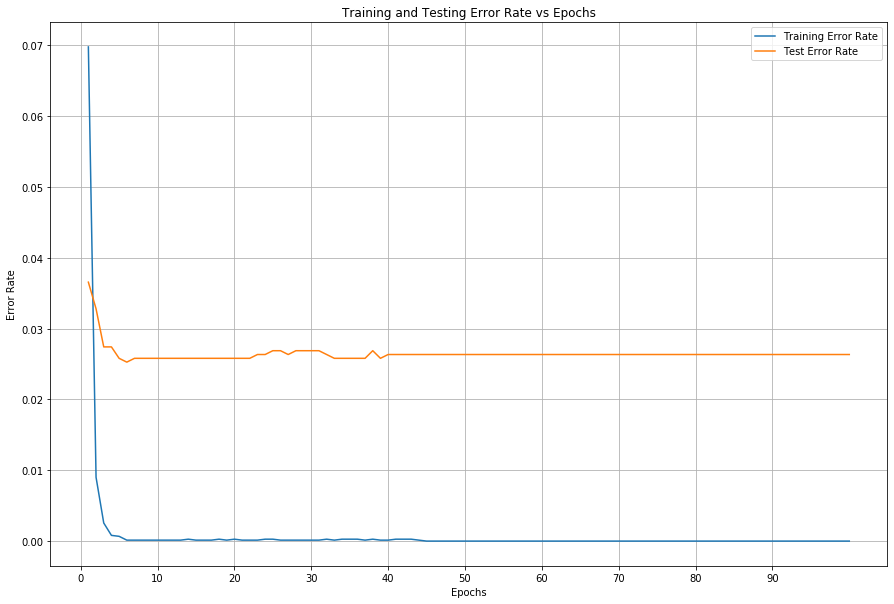

In [27]:
# Plot results
plt.figure(figsize = (15,10))
plt.title('Training and Testing Error Rate vs Epochs')
plt.plot(1 + np.arange(n_epochs), train_rates, label = 'Training Error Rate')
plt.plot(1 + np.arange(n_epochs), test_rates, label = 'Test Error Rate')
plt.xlabel('Epochs')
plt.legend()
plt.xticks(np.arange(n_epochs, step = 10))
plt.ylabel('Error Rate')
plt.grid()

In [5]:
# Basic results: Run 20 times and obtain average performance for all d
num_iter = 20
d_range = 1 + np.arange(7)
num_classes = 10; n_epochs = 20
d_results_train = np.zeros((7, num_iter)); d_results_test = np.zeros((7, num_iter))
start = time.time()
for it in range(num_iter):
    start_iter = time.time()
    print(f"Iteration {it+1}/{num_iter}")
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    for d in d_range:
        print(f"d = {d}")
        mistake_counters = init_mistake_counters(train_samples, num_classes)
        # Pre-compute outside for speed
        kernel_mat_train = polynomial_kernel(train_samples, train_samples, d)
        kernel_mat_test = polynomial_kernel(train_samples, test_samples, d)

        mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                                          , num_classes, kernel_mat_train, kernel_mat_test, n_epochs)
        
        d_results_train[d-1, it] = train_rate; d_results_test[d-1, it] = test_rate
        
    print(time.time() - start_iter)
print(time.time() - start)

Iteration 1/20
d = 1
Epoch 0, made 0.14842699650443666 mistakes on training data and mistake rate of 0.11612903225806452 on test data
Epoch 1, made 0.09706910459801021 mistakes on training data and mistake rate of 0.11290322580645161 on test data
Epoch 2, made 0.08980908846464103 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 3, made 0.07918795375100833 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 4, made 0.0754235009411132 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 5, made 0.0740790535090078 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 6, made 0.07219682710406024 mistakes on training data and mistake rate of 0.08548387096774193 on test data
Epoch 7, made 0.07031460069911266 mistakes on training data and mistake rate of 0.0967741935483871 on test data
Epoch 8, made 0.0648023662274805 mistakes on training data and mistake rate of

Epoch 0, made 0.07031460069911266 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 1, made 0.010621134713632697 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 2, made 0.00282333960742135 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 3, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Early stopping at 6 epochs
d = 7
Epoch 0, made 0.07233127184727077 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 1, made 0.009142242538316752 mistakes on traini

Epoch 4, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 5, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 6, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 8, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 9, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 10, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Early stopping at 10 epochs
d = 5
Epoch 0, made 0.0740790535090078 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 1, made 0.010755579456843238 mista

Epoch 17, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Early stopping at 17 epochs
d = 3
Epoch 0, made 0.07959128798063995 mistakes on training data and mistake rate of 0.0543010752688172 on test data
Epoch 1, made 0.018284485076633505 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 2, made 0.009680021511158914 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 3, made 0.0032266738370529714 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 4, made 0.002554450121000269 mistakes on training data and mistake rate of 0.02043010752688172 on test data
Epoch 5, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 6, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 7, made 0.0009411132024737832 mistakes on t

Epoch 5, made 0.006991126646948105 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 6, made 0.006722237160527024 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 7, made 0.004436676525947835 mistakes on training data and mistake rate of 0.044623655913978495 on test data
Epoch 8, made 0.003092229093842431 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 9, made 0.003092229093842431 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 10, made 0.0029577843506318905 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 11, made 0.002554450121000269 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 12, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 13, made 0.0012100026888948643 mistakes on training data and mistake rate

Epoch 6, made 0.0747512772250605 mistakes on training data and mistake rate of 0.07956989247311828 on test data
Epoch 7, made 0.07717128260285022 mistakes on training data and mistake rate of 0.0913978494623656 on test data
Epoch 8, made 0.07528905619790266 mistakes on training data and mistake rate of 0.11935483870967742 on test data
Epoch 9, made 0.07421349825221833 mistakes on training data and mistake rate of 0.08172043010752689 on test data
Epoch 10, made 0.06991126646948104 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 11, made 0.06883570852379672 mistakes on training data and mistake rate of 0.1086021505376344 on test data
Epoch 12, made 0.06681903737563862 mistakes on training data and mistake rate of 0.09838709677419355 on test data
Epoch 13, made 0.06641570314600699 mistakes on training data and mistake rate of 0.1 on test data
Epoch 14, made 0.06305458456574348 mistakes on training data and mistake rate of 0.08548387096774193 on test da

Epoch 0, made 0.07260016133369185 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 1, made 0.00860446356547459 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 2, made 0.002016671148158107 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 3, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 6, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 6 epochs
51.180965423583984
Iteration 6/20
d = 1
Epoch 0, made 0.14399031997848885 mistakes on training data and mistake rate of 0.12096774193548387 on test data
Epoch 1, made 

Epoch 11, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 12, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Early stopping at 12 epochs
d = 5
Epoch 0, made 0.07098682441516536 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 1, made 0.009276687281527292 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 2, made 0.0024200053777897286 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 3, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 6, made 0.0008066684592632429 mist

Epoch 11, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 12, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Early stopping at 12 epochs
d = 4
Epoch 0, made 0.07044904544232321 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 1, made 0.01398225329389621 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 2, made 0.0036300080666845924 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 3, made 0.002285560634579188 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 4, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 6, made 0.0008066684592632429 mistakes

Epoch 3, made 0.013444474321054048 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.007260016133369185 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 5, made 0.007125571390158645 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 6, made 0.005243344985211078 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 7, made 0.004033342296316214 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 8, made 0.0032266738370529714 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 9, made 0.002016671148158107 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 10, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 11, made 0.0014788921753159452 mistakes on training data and mistake rat

Epoch 8, made 0.07381016402258672 mistakes on training data and mistake rate of 0.07956989247311828 on test data
Epoch 9, made 0.06937348749663888 mistakes on training data and mistake rate of 0.08494623655913978 on test data
Epoch 10, made 0.07098682441516536 mistakes on training data and mistake rate of 0.09193548387096774 on test data
Epoch 11, made 0.06897015326700726 mistakes on training data and mistake rate of 0.07096774193548387 on test data
Epoch 12, made 0.06614681365958591 mistakes on training data and mistake rate of 0.08172043010752689 on test data
Epoch 13, made 0.06668459263242807 mistakes on training data and mistake rate of 0.08010752688172043 on test data
Epoch 14, made 0.06305458456574348 mistakes on training data and mistake rate of 0.08064516129032258 on test data
Epoch 15, made 0.06520570045711213 mistakes on training data and mistake rate of 0.07634408602150537 on test data
Epoch 16, made 0.0641301425114278 mistakes on training data and mistake rate of 0.08602150

Epoch 3, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 5, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 7 epochs
50.84089207649231
Iteration 10/20
d = 1
Epoch 0, made 0.14896477547727885 mistakes on training data and mistake rate of 0.1086021505376344 on test data
Epoch 1, made 0.0996235547190105 mistakes on training data and mistake rate of 0.08709677419354839 on test data
Epoch 2, made 0.08913686474858833 mistakes on training data and mistake rate of 0.10376344086021505 on test data
Epoch 3, made

Epoch 3, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 6, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Early stopping at 8 epochs
d = 6
Epoch 0, made 0.07004571121269158 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 1, made 0.010217800484001076 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 2, made 0.0032266738370529714 mista

Epoch 10, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 11, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Early stopping at 11 epochs
d = 4
Epoch 0, made 0.0727346060769024 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 1, made 0.013444474321054048 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 2, made 0.005108900242000538 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 3, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 4, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.020967741935483872 on test data
Epoch 5, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.020967741935483872 on test data
Epoch 6, made 0.0008066684592632429 mistakes

Epoch 1, made 0.018956708792686208 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 2, made 0.006856681903737564 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 3, made 0.004302231782737295 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 4, made 0.0026888948642108095 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 5, made 0.0024200053777897286 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 6, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 7, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 8, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 9, made 0.0005377789728421619 mistakes on training data and mistake rate o

Epoch 4, made 0.009545576767948373 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 5, made 0.006991126646948105 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 6, made 0.006050013444474321 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 7, made 0.0034955633234740524 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 8, made 0.003092229093842431 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 9, made 0.003092229093842431 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 10, made 0.002285560634579188 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 11, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 12, made 0.0014788921753159452 mistakes on training data and mistake rate o

Epoch 10, made 0.06897015326700726 mistakes on training data and mistake rate of 0.10161290322580645 on test data
Epoch 11, made 0.06520570045711213 mistakes on training data and mistake rate of 0.09193548387096774 on test data
Epoch 12, made 0.06251680559290132 mistakes on training data and mistake rate of 0.10161290322580645 on test data
Epoch 13, made 0.06144124764721699 mistakes on training data and mistake rate of 0.1086021505376344 on test data
Epoch 14, made 0.0578112395805324 mistakes on training data and mistake rate of 0.09623655913978495 on test data
Epoch 15, made 0.05740790535090078 mistakes on training data and mistake rate of 0.10268817204301076 on test data
Epoch 16, made 0.05969346598547997 mistakes on training data and mistake rate of 0.0913978494623656 on test data
Epoch 17, made 0.061037913417585375 mistakes on training data and mistake rate of 0.09193548387096774 on test data
Epoch 18, made 0.05808012906695348 mistakes on training data and mistake rate of 0.0946236

Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Early stopping at 6 epochs
49.73114228248596
Iteration 15/20
d = 1
Epoch 0, made 0.14694810432912073 mistakes on training data and mistake rate of 0.10215053763440861 on test data
Epoch 1, made 0.10043022317827373 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 2, made 0.08886797526216725 mistakes on training data and mistake rate of 0.1053763440860215 on test data
Epoch 3, made 0.08322129604732455 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 4, made 0.07999462221027158 mistakes on training data and mistake rate of 0.0935483870967742 on test data
Epoch 5, made 0.07569239042753428 mistakes on training data and mistake rate of 0.09193548387096774 on test data
Epoch 6, made 0.07219682710406024 mistakes on training data and mistake rate of 0.08655913978494624 on test data
Epoch 7, made 0.073406829792

Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Early stopping at 7 epochs
d = 6
Epoch 0, made 0.06749126109169132 mistakes on training data and mistake rate of 0.041935483870967745 on test data
Epoch 1, made 0.009142242538316752 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 2, made 0.00282333960742135 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 3, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.0009411132024737832 mistakes on

Epoch 8, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 9, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 10, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 11, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Early stopping at 11 epochs
d = 4
Epoch 0, made 0.07421349825221833 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 1, made 0.0112933584296854 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 2, made 0.003361118580263512 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 3, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.0010755579456843238 mistakes 

Epoch 16, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Early stopping at 16 epochs
d = 3
Epoch 0, made 0.07528905619790266 mistakes on training data and mistake rate of 0.04086021505376344 on test data
Epoch 1, made 0.018150040333422962 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 2, made 0.00873890830868513 mistakes on training data and mistake rate of 0.03978494623655914 on test data
Epoch 3, made 0.004302231782737295 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 4, made 0.002285560634579188 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 5, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 6, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 7, made 0.0009411132024737832 mistakes on tra

Epoch 4, made 0.008335574079053509 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 5, made 0.006856681903737564 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 6, made 0.004302231782737295 mistakes on training data and mistake rate of 0.03978494623655914 on test data
Epoch 7, made 0.004033342296316214 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 8, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 9, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 10, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 11, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 12, made 0.0006722237160527024 mistakes on training data and mistake rate

Epoch 6, made 0.07098682441516536 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 7, made 0.07139015864479699 mistakes on training data and mistake rate of 0.08387096774193549 on test data
Epoch 8, made 0.07246571659048132 mistakes on training data and mistake rate of 0.08978494623655914 on test data
Epoch 9, made 0.06950793223984943 mistakes on training data and mistake rate of 0.08709677419354839 on test data
Epoch 10, made 0.062382360849690774 mistakes on training data and mistake rate of 0.11559139784946236 on test data
Epoch 11, made 0.06655014788921754 mistakes on training data and mistake rate of 0.07258064516129033 on test data
Epoch 12, made 0.06292013982253294 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 13, made 0.06493681097069105 mistakes on training data and mistake rate of 0.09838709677419355 on test data
Epoch 14, made 0.060231244958322126 mistakes on training data and mistake rate of 0.0731182

Epoch 0, made 0.06923904275342833 mistakes on training data and mistake rate of 0.03870967741935484 on test data
Epoch 1, made 0.00860446356547459 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 2, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 3, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 8, made 0.00026888948642108095 mistakes on training data and mistake r

Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Early stopping at 8 epochs
d = 5
Epoch 0, made 0.07112126915837591 mistakes on training data and mistake rate of 0.04247311827956989 on test data
Epoch 1, made 0.009814466254369453 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 2, made 0.002554450121000269 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 3, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 4, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 7, made 0.00026888948642108095 mistakes 

In [6]:
# Print results. TODO: Add plots of mean vs d, and also add the error bars to this plot. Refer to 1.6, ard done there
means_train = np.mean(d_results_train, axis = 1); stds_train = np.std(d_results_train, axis = 1)
means_test = np.mean(d_results_test, axis = 1); stds_test = np.std(d_results_test, axis = 1)
for d in d_range:
    print(f"For d = {d} on training, mean error is {means_train[d-1]} and std of {stds_train[d-1]}")
    print(f"For d = {d} on test, mean error is {means_test[d-1]} and std of {stds_test[d-1]}")

For d = 1 on training, mean error is 0.05769023931164291 and std of 0.012313986250346732
For d = 1 on test, mean error is 0.08760752688172042 and std of 0.012124192344425454
For d = 2 on training, mean error is 0.0007260016133369186 and std of 0.0003048073151049915
For d = 2 on test, mean error is 0.03094086021505376 and std of 0.004990090191130847
For d = 3 on training, mean error is 0.0003361118580263512 and std of 0.0001377648664420489
For d = 3 on test, mean error is 0.027446236559139785 and std of 0.0036004449500852053
For d = 4 on training, mean error is 0.0003697230438289863 and std of 0.0002244663600035494
For d = 4 on test, mean error is 0.026424731182795695 and std of 0.0034978273156582983
For d = 5 on training, mean error is 0.0002352783006184458 and std of 0.00013360182115052291
For d = 5 on test, mean error is 0.026720430107526883 and std of 0.003832319007999298
For d = 6 on training, mean error is 0.00022855606345791875 and std of 0.00010500470120874772
For d = 6 on test,

In [7]:
# Visualisation
plt.figure(figsize = (15,8))
plt.title('Mean error rate vs d')
plt.errorbar(d_range, means_train, yerr = stds_train, label = 'Train', elinewidth = 2.5, ecolor = 'r', color = 'c')
plt.errorbar(d_range, means_test, yerr = stds_test, label = 'Test', elinewidth = 2.5, ecolor = 'b', color = 'orange')
plt.xlabel('Polynomial degree')
plt.ylabel('Error rate')
plt.legend()
plt.grid()

### Q1.2

Perform 20 cross validations to find 20 best d*, along with its respective test performance. TO DO: Add visualisation, e.g. plot of d vs errors for each cross validation

In [8]:
# Auxiliary Functions
def getSubArray(x_train, y_train,n, seed = None):
    """
    Divide the training set into n sub-arrays
    
    Inputs:
    x_train,y train: m x n and m x 1 respectively. 
    n: # of sub-arrays
    """
    res_x = []; res_y = []; sub_arr_indexes = []
    n_samples = x_train.shape[0]; inc = n_samples/n;
    
    # Set seed to get repeatable results
    if seed is not None:
        random.seed(seed)
    
    # Not needed to shuffle because already shuffled before splitting to train and test
    # shuffle the training data before splitting to sub-arrays
#     permute = random.sample(range(n_samples), n_samples)
#     x_train = x_train[permute,:]
#     y_train = y_train[permute,:]
    
    # divide into sub-arrays
    start_idx = 0; end_idx = 0
    for _ in range(n):
        end_idx += inc
        round_end = math.floor(end_idx)
        sub_arr_indexes.append((start_idx, round_end))
        res_x.append(x_train[start_idx:round_end,:])
        res_y.append(y_train[start_idx:round_end,:])
        start_idx = round_end
    
    return res_x, res_y, sub_arr_indexes

def catSubArrays(folds):
    """
    Function to concatenate multiple sub-arrays to a single m x n array
    Input:
    folds: a list of 2d arrays to concatenate
    """
    res = folds[0]
    for idx in range(1,len(folds)):
        res = np.concatenate([res,folds[idx]],axis = 0)
    return res

def update_misclassification(misclass_counters, test_preds, test_labels, test_indexes):
    """
    Updates which samples are misclassified during cross validation, when these samples are TEST sets
    Input
    misclass_counters = vector with length of WHOLE dataset
    """
    wrong_preds = test_preds != test_labels
    bool_arr = np.zeros((data_labels.shape)).astype(bool)
    bool_arr[test_indexes] = wrong_preds
    
    new_misclass = copy.deepcopy(misclass_counters)
    new_misclass[bool_arr] += 1
    
    return new_misclass.astype(int)

To improve cross validation performance, we can compute the kernel matrix before the 5 fold since we have access to all the training data. Then, when divided to train and val, we can just slice the big kernel matrix according to which sub array is validation and which is train

In [10]:
# Loop 20 times
d_errors = []; best_ds = []; misclass_counters = np.zeros((data_labels.shape))
num_iter = 20
all_d_errors = np.zeros((len(d_range), num_iter))

for it in range(num_iter):
    # Do 1 cross-validation, and then outer-loop it by 20 times
    start_val = time.time()
    n = 5; n_epochs = 20; num_classes = 10
    # Split for every run
    train_samples, train_labels, test_samples, test_labels, test_indexes = split_train_test_q4(data_samples, data_labels, 0.8, 0.2, seed = it)

    # Compute power 1 of kernel mat (later just raise to power d)
    kernel_pow1 = polynomial_kernel(train_samples, train_samples, 1)

    # Divide into sub-arrays
    x_train, y_train, sub_idxs = getSubArray(train_samples, train_labels.reshape(-1,1), n)

    # Convert to numpy arrays for ease of slicing
    x_train = np.array(x_train); y_train = np.array(y_train)

    # 1 5-fold cross validation starts here
    d_val_results = np.zeros((7))
    for d in d_range:
        print(f"For d = {d}")
        kernel_mat_train = kernel_pow1 ** d
        kernel_mat_idxs = np.arange(kernel_mat_train.shape[0])
        # Iterate through each validation sub-array, the rest become training
        val_indexes = np.arange(n); val_err = []

        for val_idx in val_indexes:
            # Get training sub-array indexes
            train_indexes = np.delete(val_indexes, val_idx)

            # Get validation fold index range
            val_range = np.arange(sub_idxs[val_idx][0], sub_idxs[val_idx][1])

            # Slice off the validation samples from the large kernel matrix, and get the train and val based on the folds
            train_kernel_mat = np.delete(kernel_mat_train, val_range, axis = 0)
            val_kernel_mat = train_kernel_mat[:,val_range]
            train_kernel_mat = np.delete(train_kernel_mat, val_range, axis = 1)

            # Take one fold as val, rest becomes training
            val_samples = x_train[val_idx]; val_labels = y_train[val_idx].reshape(-1)

            # Training set
            train_mini_samples = catSubArrays(x_train[train_indexes]); train_mini_labels = catSubArrays(y_train[train_indexes]).reshape(-1)

            # Train on training set for some epochs, and then test
            mistake_counters = init_mistake_counters(train_mini_samples, num_classes)
            mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_mini_samples, train_mini_labels, val_samples, val_labels, mistake_counters
                                                                                          , num_classes, train_kernel_mat, val_kernel_mat, n_epochs)

            # Append validation results
            val_err.append(test_rate)

        # Store this d's results
        d_val_results[d-1] = np.mean(val_err); all_d_errors[d-1, it] = np.mean(val_err)

    # # Find best d, re-train on whole train_samples and obtain final test performance
    d_star = np.argmin(d_val_results) + 1
    print(f"For iteration {it+1}, best d is {d_star}")
    kernel_mat_test = polynomial_kernel(train_samples, test_samples, d_star)
    kernel_mat_train = kernel_pow1 ** d_star
    mistake_counters = init_mistake_counters(train_samples, num_classes)
    mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                                      ,num_classes, kernel_mat_train, kernel_mat_test, n_epochs)

    print(f"For d = {d_star}, retraining gives a final test error rate of {test_rate}")
    
    # Update misclassification counters
    misclass_counters = update_misclassification(misclass_counters, test_preds, test_labels, test_indexes)

    # Append result of this cross validation
    d_errors.append(test_rate); best_ds.append(d_star)
    
    print(f"Time for 1 cross validation across 7 d is {time.time() - start_val}")

For d = 1
Epoch 0, made 0.15224332045034447 mistakes on training data and mistake rate of 0.11903160726294552 on test data
Epoch 1, made 0.09595026046042682 mistakes on training data and mistake rate of 0.10020174848688634 on test data
Epoch 2, made 0.08855654511846749 mistakes on training data and mistake rate of 0.09280430396772024 on test data
Epoch 3, made 0.08049067383633003 mistakes on training data and mistake rate of 0.08406186953597848 on test data
Epoch 4, made 0.07578558225508318 mistakes on training data and mistake rate of 0.08876933422999328 on test data
Epoch 5, made 0.06973617879348008 mistakes on training data and mistake rate of 0.0968392737054472 on test data
Epoch 6, made 0.06788774995799025 mistakes on training data and mistake rate of 0.08338937457969066 on test data
Epoch 7, made 0.0670475550327676 mistakes on training data and mistake rate of 0.09347679892400806 on test data
Epoch 8, made 0.06603932112250042 mistakes on training data and mistake rate of 0.075319

Epoch 13, made 0.058319327731092434 mistakes on training data and mistake rate of 0.09811827956989247 on test data
Epoch 14, made 0.058823529411764705 mistakes on training data and mistake rate of 0.09475806451612903 on test data
Epoch 15, made 0.058151260504201684 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 16, made 0.05546218487394958 mistakes on training data and mistake rate of 0.10080645161290322 on test data
Epoch 17, made 0.05277310924369748 mistakes on training data and mistake rate of 0.08803763440860216 on test data
Epoch 18, made 0.055630252100840334 mistakes on training data and mistake rate of 0.08938172043010753 on test data
Epoch 19, made 0.05411764705882353 mistakes on training data and mistake rate of 0.09206989247311828 on test data
Epoch 0, made 0.15663865546218486 mistakes on training data and mistake rate of 0.11290322580645161 on test data
Epoch 1, made 0.0976470588235294 mistakes on training data and mistake rate of 0.1014

Epoch 8, made 0.0028566627457570154 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 9, made 0.0023525457906234245 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 10, made 0.003024701730801546 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 11, made 0.002016467820534364 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 12, made 0.002016467820534364 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 13, made 0.0018484288354898336 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 14, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 15, made 0.001512350865400773 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 16, made 0.0006721559401781214 mistakes on training data and mistake rat

Epoch 4, made 0.0036968576709796672 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 5, made 0.003024701730801546 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 6, made 0.002016467820534364 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 7, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 8, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 9, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 10, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.02824478816408877 on test data
Early stopping at 10 epochs
Epoch 0, made 0.08773109243697479 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 1, made 0.01865546218487395 mistakes on training

Epoch 0, made 0.08050420168067227 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 1, made 0.012436974789915966 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 2, made 0.00453781512605042 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 3, made 0.0030252100840336134 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 4, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 5, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate 

Epoch 4, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 6, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 7, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07966386554621849 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 1, made 0.00957983193277311 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 2, made 0.002352941176470588 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 3, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 4, made 0.0006722689075630252 mistakes on training data

For d = 1
Epoch 0, made 0.15862880188203662 mistakes on training data and mistake rate of 0.0968392737054472 on test data
Epoch 1, made 0.10368005377247522 mistakes on training data and mistake rate of 0.08742434431741762 on test data
Epoch 2, made 0.09376575365484792 mistakes on training data and mistake rate of 0.09751176866173504 on test data
Epoch 3, made 0.08738027222315577 mistakes on training data and mistake rate of 0.09213180901143242 on test data
Epoch 4, made 0.08149890774659721 mistakes on training data and mistake rate of 0.0941492938802959 on test data
Epoch 5, made 0.07292891950932616 mistakes on training data and mistake rate of 0.0894418291862811 on test data
Epoch 6, made 0.0742732313896824 mistakes on training data and mistake rate of 0.08607935440484196 on test data
Epoch 7, made 0.07393715341959335 mistakes on training data and mistake rate of 0.0968392737054472 on test data
Epoch 8, made 0.0742732313896824 mistakes on training data and mistake rate of 0.0981842636

Epoch 4, made 0.07663865546218487 mistakes on training data and mistake rate of 0.08131720430107527 on test data
Epoch 5, made 0.07478991596638655 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 6, made 0.0704201680672269 mistakes on training data and mistake rate of 0.10080645161290322 on test data
Epoch 7, made 0.07109243697478991 mistakes on training data and mistake rate of 0.1081989247311828 on test data
Epoch 8, made 0.06554621848739496 mistakes on training data and mistake rate of 0.09341397849462366 on test data
Epoch 9, made 0.06504201680672268 mistakes on training data and mistake rate of 0.10618279569892473 on test data
Epoch 10, made 0.06470588235294118 mistakes on training data and mistake rate of 0.09811827956989247 on test data
Epoch 11, made 0.060168067226890755 mistakes on training data and mistake rate of 0.08266129032258064 on test data
Epoch 12, made 0.06168067226890756 mistakes on training data and mistake rate of 0.091397849462

Epoch 4, made 0.00823529411764706 mistakes on training data and mistake rate of 0.05510752688172043 on test data
Epoch 5, made 0.004705882352941176 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 6, made 0.003865546218487395 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 7, made 0.004369747899159664 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 8, made 0.0030252100840336134 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 9, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 10, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 11, made 0.001176470588235294 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 12, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.

Epoch 4, made 0.0030252100840336134 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 5, made 0.002352941176470588 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 6, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 8, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 9, made 0.0 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 10, made 0.0 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Early stopping at 10 epochs
Epoch 0, made 0.09092436974789916 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 1, made 0.01899159663865546 mistakes on training data and mistake rate of 0.0430

Epoch 8, made 0.000504116955133591 mistakes on training data and mistake rate of 0.028917283120376596 on test data
Epoch 9, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 10, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Early stopping at 10 epochs
Epoch 0, made 0.08134453781512604 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 1, made 0.011092436974789916 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 2, made 0.004369747899159664 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 3, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 4, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 5, made 0.0010084033613445378 mistakes on trai

Epoch 4, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 8, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Early stopping at 8 epochs
For d = 7
Epoch 0, made 0.07746597210552848 mistakes on training data and mistake rate of 0.05043712172158709 on test data
Epoch 1, made 0.010754495042849942 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 2, made 0.0026886237607124854 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 3, made 0.0013443118803562427 mistakes

Epoch 13, made 0.06183834649638716 mistakes on training data and mistake rate of 0.16610625420309347 on test data
Epoch 14, made 0.06099815157116451 mistakes on training data and mistake rate of 0.18897108271687962 on test data
Epoch 15, made 0.05646109897496219 mistakes on training data and mistake rate of 0.14996637525218562 on test data
Epoch 16, made 0.05662913796000672 mistakes on training data and mistake rate of 0.12911903160726296 on test data
Epoch 17, made 0.05578894303478407 mistakes on training data and mistake rate of 0.09482178883658372 on test data
Epoch 18, made 0.05511678709460595 mistakes on training data and mistake rate of 0.10558170813718896 on test data
Epoch 19, made 0.054444631154427825 mistakes on training data and mistake rate of 0.09280430396772024 on test data
Epoch 0, made 0.16016806722689075 mistakes on training data and mistake rate of 0.16129032258064516 on test data
Epoch 1, made 0.10369747899159663 mistakes on training data and mistake rate of 0.182123

Epoch 6, made 0.07176470588235294 mistakes on training data and mistake rate of 0.09005376344086022 on test data
Epoch 7, made 0.07411764705882352 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 8, made 0.07159663865546219 mistakes on training data and mistake rate of 0.10013440860215053 on test data
Epoch 9, made 0.0642016806722689 mistakes on training data and mistake rate of 0.08803763440860216 on test data
Epoch 10, made 0.06386554621848739 mistakes on training data and mistake rate of 0.09879032258064516 on test data
Epoch 11, made 0.06487394957983193 mistakes on training data and mistake rate of 0.11290322580645161 on test data
Epoch 12, made 0.05966386554621849 mistakes on training data and mistake rate of 0.08938172043010753 on test data
Epoch 13, made 0.05899159663865546 mistakes on training data and mistake rate of 0.0907258064516129 on test data
Epoch 14, made 0.06100840336134454 mistakes on training data and mistake rate of 0.08534946236

Epoch 6, made 0.004033613445378151 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 7, made 0.005546218487394958 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 8, made 0.0031932773109243696 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 9, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 10, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 11, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 12, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 13, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 14, made 0.0008403361344537816 mistakes on training data and mistake r

Epoch 1, made 0.018319327731092436 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 2, made 0.008571428571428572 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 3, made 0.0036974789915966387 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 4, made 0.002689075630252101 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 5, made 0.001176470588235294 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 9, made 0.0001680672268907563 mistakes on training data and mistake rat

Epoch 1, made 0.01041841707276088 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 2, made 0.0036968576709796672 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 3, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 4, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 5, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 6, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07663865546218487 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 1, made 0.011260504201680671 mistakes on training dat

Epoch 2, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 3, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 4, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07360107544950428 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 1, made 0.008906066207360107 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 2, made 0.002520584775667955 mistakes on trai

Epoch 12, made 0.060168067226890755 mistakes on training data and mistake rate of 0.09206989247311828 on test data
Epoch 13, made 0.058151260504201684 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 14, made 0.05630252100840336 mistakes on training data and mistake rate of 0.08669354838709678 on test data
Epoch 15, made 0.05949579831932773 mistakes on training data and mistake rate of 0.07997311827956989 on test data
Epoch 16, made 0.05865546218487395 mistakes on training data and mistake rate of 0.08602150537634409 on test data
Epoch 17, made 0.05798319327731093 mistakes on training data and mistake rate of 0.07594086021505377 on test data
Epoch 18, made 0.05411764705882353 mistakes on training data and mistake rate of 0.0846774193548387 on test data
Epoch 19, made 0.05781512605042017 mistakes on training data and mistake rate of 0.08803763440860216 on test data
Epoch 0, made 0.1529154763905226 mistakes on training data and mistake rate of 0.117014

Epoch 5, made 0.006553520416736683 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 6, made 0.004705091581246849 mistakes on training data and mistake rate of 0.04707464694014795 on test data
Epoch 7, made 0.004537052596202319 mistakes on training data and mistake rate of 0.05110961667787491 on test data
Epoch 8, made 0.003528818685935137 mistakes on training data and mistake rate of 0.04371217215870881 on test data
Epoch 9, made 0.002520584775667955 mistakes on training data and mistake rate of 0.05648957632817754 on test data
Epoch 10, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.04371217215870881 on test data
Epoch 11, made 0.002016467820534364 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 12, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 13, made 0.0013443118803562427 mistakes on training data and mistake rate of 

Epoch 5, made 0.005714285714285714 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.004369747899159664 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 7, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 8, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 9, made 0.002857142857142857 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 10, made 0.002184873949579832 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 11, made 0.002184873949579832 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 12, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 13, made 0.0013445378151260505 mistakes on training data and mistake rate

Epoch 1, made 0.014115274743740547 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 2, made 0.004369013611157789 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 3, made 0.001512350865400773 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 4, made 0.0018484288354898336 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 5, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 8, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07714285714285714 mistakes on training

Epoch 0, made 0.07647058823529412 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 1, made 0.00957983193277311 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 2, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 3, made 0.001176470588235294 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 4, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 5, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07899159663865546 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 1, made 0.012605042016806723 mistakes on training data 

Epoch 0, made 0.07965047891110738 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 1, made 0.008738027222315578 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 2, made 0.0023525457906234245 mistakes on training data and mistake rate of 0.026227303295225286 on test data
Epoch 3, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.02757229320780094 on test data
Epoch 4, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.026227303295225286 on test data
Epoch 5, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 6, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 7, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.026227303295225286 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.026227303

Epoch 14, made 0.06521008403361345 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 15, made 0.06605042016806723 mistakes on training data and mistake rate of 0.09744623655913978 on test data
Epoch 16, made 0.06403361344537815 mistakes on training data and mistake rate of 0.10013440860215053 on test data
Epoch 17, made 0.06722689075630252 mistakes on training data and mistake rate of 0.0961021505376344 on test data
Epoch 18, made 0.06168067226890756 mistakes on training data and mistake rate of 0.07190860215053764 on test data
Epoch 19, made 0.06 mistakes on training data and mistake rate of 0.08669354838709678 on test data
Epoch 0, made 0.15325155436061166 mistakes on training data and mistake rate of 0.10490921318090114 on test data
Epoch 1, made 0.10536044362292052 mistakes on training data and mistake rate of 0.08675184936112978 on test data
Epoch 2, made 0.09628633843051589 mistakes on training data and mistake rate of 0.11903160726294552 on tes

Epoch 7, made 0.003528818685935137 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 8, made 0.003024701730801546 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 9, made 0.0031927407158460763 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 10, made 0.0031927407158460763 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 11, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 12, made 0.0018484288354898336 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 13, made 0.001008233910267182 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 14, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 15, made 0.0008401949252226517 mistakes on training data and mistake rate

Epoch 10, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 11, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.053763440860215055 on test data
Epoch 12, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 13, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.05241935483870968 on test data
Epoch 14, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 15, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 16, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 17, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 18, made 0.0005042016806722689 mistakes on training data and mis

Epoch 6, made 0.001176470588235294 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 8, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 9, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 10, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 11, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 12, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 13, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Early stopping at 13 epochs
For d = 4
Epoch 0, made 0.08116282977650816 mist

Epoch 3, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 6, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Early stopping at 7 epochs
Epoch 0, made 0.08235294117647059 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 1, made 0.01310924369747899 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 2, made 0.002352941176470588 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 3, made 0.0006722689075630252 mistakes on training dat

Epoch 2, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 3, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 4, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 5, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 7, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 8, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Early stopping at 8 epochs
Epoch 0, made 0.08436974789915966 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 1, made 0.010924369747899159 mistakes on training da

Epoch 18, made 0.05192404637875987 mistakes on training data and mistake rate of 0.09078681909885676 on test data
Epoch 19, made 0.05326835825911611 mistakes on training data and mistake rate of 0.08540685944855414 on test data
Epoch 0, made 0.15361344537815125 mistakes on training data and mistake rate of 0.11021505376344086 on test data
Epoch 1, made 0.10252100840336134 mistakes on training data and mistake rate of 0.09475806451612903 on test data
Epoch 2, made 0.09361344537815126 mistakes on training data and mistake rate of 0.10013440860215053 on test data
Epoch 3, made 0.08134453781512604 mistakes on training data and mistake rate of 0.07258064516129033 on test data
Epoch 4, made 0.0784873949579832 mistakes on training data and mistake rate of 0.08198924731182795 on test data
Epoch 5, made 0.07949579831932774 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 6, made 0.0757983193277311 mistakes on training data and mistake rate of 0.09072580645161

Epoch 11, made 0.06739495798319328 mistakes on training data and mistake rate of 0.08131720430107527 on test data
Epoch 12, made 0.0611764705882353 mistakes on training data and mistake rate of 0.08736559139784947 on test data
Epoch 13, made 0.06050420168067227 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 14, made 0.060168067226890755 mistakes on training data and mistake rate of 0.07661290322580645 on test data
Epoch 15, made 0.06033613445378151 mistakes on training data and mistake rate of 0.08736559139784947 on test data
Epoch 16, made 0.05764705882352941 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 17, made 0.05411764705882353 mistakes on training data and mistake rate of 0.08534946236559139 on test data
Epoch 18, made 0.05310924369747899 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 19, made 0.056134453781512605 mistakes on training data and mistake rate of 0.0793

Epoch 3, made 0.01226890756302521 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 4, made 0.008907563025210084 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 5, made 0.007563025210084034 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 6, made 0.005714285714285714 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 7, made 0.004201680672268907 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 8, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 9, made 0.002352941176470588 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 10, made 0.002184873949579832 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 11, made 0.001176470588235294 mistakes on training data and mistake rate of

Epoch 0, made 0.08789915966386555 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 1, made 0.02033613445378151 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 2, made 0.008571428571428572 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 3, made 0.004705882352941176 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 4, made 0.0030252100840336134 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 5, made 0.002184873949579832 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 6, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 7, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 8, made 0.0008403361344537816 mistakes on training data and mistake rate of 0

Epoch 3, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 4, made 0.001176470588235294 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 8, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Early stopping at 8 epochs
For d = 5
Epoch 0, made 0.07544950428499411 mistakes on training data and mistake rate of 0.04572965702757229 on test data
Epoch 1, made 0.01025037808771635 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 2, made 0.0038648966560241977 mistakes

Epoch 8, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07881028398588473 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 1, made 0.008065871282137456 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 2, made 0.0023525457906234245 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 3, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training

Epoch 10, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 11, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 12, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Early stopping at 12 epochs
For d = 4, retraining gives a final test error rate of 0.02795698924731183
Time for 1 cross validation across 7 d is 207.62830257415771
For d = 1
Epoch 0, made 0.15594017812132416 mistakes on training data and mistake rate of 0.0988567585743107 on test data
Epoch 1, made 0.10283985884725257 mistakes on training data and mistake rate of 0.0988567585743107 on test data
Epoch 2, made 0.09057301293900184 mistakes on training data and mistake rate of 0.1109616677874916 on test data
Epoch 3, made 0.08217106368677533 mistakes on training data and mistake rate of 0.08406186953597848 on test data
Epoch 4, made 0.081162829

Epoch 8, made 0.07126050420168067 mistakes on training data and mistake rate of 0.08400537634408602 on test data
Epoch 9, made 0.06302521008403361 mistakes on training data and mistake rate of 0.08669354838709678 on test data
Epoch 10, made 0.06336134453781513 mistakes on training data and mistake rate of 0.0961021505376344 on test data
Epoch 11, made 0.06403361344537815 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 12, made 0.06168067226890756 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 13, made 0.06084033613445378 mistakes on training data and mistake rate of 0.0846774193548387 on test data
Epoch 14, made 0.057478991596638655 mistakes on training data and mistake rate of 0.10147849462365591 on test data
Epoch 15, made 0.0573109243697479 mistakes on training data and mistake rate of 0.09341397849462366 on test data
Epoch 16, made 0.05647058823529412 mistakes on training data and mistake rate of 0.092741935

Epoch 2, made 0.017644093429675684 mistakes on training data and mistake rate of 0.04371217215870881 on test data
Epoch 3, made 0.012098806923206184 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 4, made 0.007729793312048395 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 5, made 0.006049403461603092 mistakes on training data and mistake rate of 0.04371217215870881 on test data
Epoch 6, made 0.00487313056629138 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 7, made 0.0031927407158460763 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 8, made 0.0026886237607124854 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 9, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 10, made 0.001008233910267182 mistakes on training data and mistake rate of 0.0383

Epoch 10, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Early stopping at 10 epochs
Epoch 0, made 0.08485968744748781 mistakes on training data and mistake rate of 0.04707464694014795 on test data
Epoch 1, made 0.018148210384809276 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 2, made 0.007729793312048395 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 3, made 0.0038648966560241977 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 4, made 0.002016467820534364 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 5, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 6, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 7, made 0.000504116955133591 mistakes on training d

Epoch 2, made 0.004033613445378151 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 3, made 0.001176470588235294 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 4, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 5, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Early stopping at 7 epochs
For d = 5
Epoch 0, made 0.07696185515039489 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 1, made 0.013275079818517896 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 2, made 0.0033607797008906068 mistakes 

Epoch 0, made 0.07764705882352942 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 1, made 0.010756302521008404 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 2, made 0.0025210084033613447 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 4, made 0.0 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Early stopping at 7 epochs
Epoch 0, made 0.0757983193277311 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 1, ma

Epoch 4, made 0.07998655688119644 mistakes on training data and mistake rate of 0.10827168796234028 on test data
Epoch 5, made 0.07948243992606285 mistakes on training data and mistake rate of 0.0968392737054472 on test data
Epoch 6, made 0.07729793312048396 mistakes on training data and mistake rate of 0.07128446536650974 on test data
Epoch 7, made 0.07175264661401445 mistakes on training data and mistake rate of 0.10692669804976462 on test data
Epoch 8, made 0.07292891950932616 mistakes on training data and mistake rate of 0.10087424344317418 on test data
Epoch 9, made 0.06822382792807931 mistakes on training data and mistake rate of 0.09482178883658372 on test data
Epoch 10, made 0.06503108721223323 mistakes on training data and mistake rate of 0.07531943510423672 on test data
Epoch 11, made 0.06603932112250042 mistakes on training data and mistake rate of 0.0988567585743107 on test data
Epoch 12, made 0.06519912619727777 mistakes on training data and mistake rate of 0.0948217888365

Epoch 17, made 0.05915966386554622 mistakes on training data and mistake rate of 0.09543010752688172 on test data
Epoch 18, made 0.05966386554621849 mistakes on training data and mistake rate of 0.0846774193548387 on test data
Epoch 19, made 0.06235294117647059 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 0, made 0.15546218487394958 mistakes on training data and mistake rate of 0.09879032258064516 on test data
Epoch 1, made 0.10151260504201681 mistakes on training data and mistake rate of 0.10147849462365591 on test data
Epoch 2, made 0.09243697478991597 mistakes on training data and mistake rate of 0.09341397849462366 on test data
Epoch 3, made 0.08352941176470588 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 4, made 0.08184873949579832 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 5, made 0.07714285714285714 mistakes on training data and mistake rate of 0.080645161290

Epoch 11, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Early stopping at 11 epochs
Epoch 0, made 0.10722689075630253 mistakes on training data and mistake rate of 0.06720430107526881 on test data
Epoch 1, made 0.038487394957983194 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 2, made 0.019327731092436976 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 3, made 0.012605042016806723 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 4, made 0.008067226890756302 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 5, made 0.005714285714285714 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 6, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 7, made 0.0036974789915966387 mistakes on training 

Epoch 0, made 0.08941176470588236 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 1, made 0.019495798319327733 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 2, made 0.008571428571428572 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 3, made 0.004369747899159664 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 4, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 5, made 0.002184873949579832 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 6, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 7, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 8, made 0.0010084033613445378 mistakes on training data and mistake rate of 0

Epoch 0, made 0.08151260504201681 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 1, made 0.012773109243697478 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 2, made 0.005042016806722689 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 3, made 0.0036974789915966387 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 4, made 0.002184873949579832 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 5, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 6, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 7, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate o

Epoch 0, made 0.07864224500084019 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 1, made 0.009914300117627289 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 2, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 3, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 5, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 6, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07983193277310924 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 1, made 0.012436974789915966 mistakes on training 

Epoch 4, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.01989247311827957 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.01935483870967742 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.01827956989247312 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.01827956989247312 on test data
Epoch 8, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.017741935483870968 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.017204301075268817 on test data
Early stopping at 9 epochs
For d = 6, retraining gives a final test error rate of 0.017204301075268817
Time for 1 cross validation across 7 d is 166.56861543655396
For d = 1
Epoch 0, made 0.16316585447823895 mistakes on training data and mistake rate of 0.10020174848688634 on test data
Epoch 1, made 0.10

Epoch 5, made 0.07663865546218487 mistakes on training data and mistake rate of 0.09475806451612903 on test data
Epoch 6, made 0.0746218487394958 mistakes on training data and mistake rate of 0.1028225806451613 on test data
Epoch 7, made 0.07260504201680672 mistakes on training data and mistake rate of 0.08669354838709678 on test data
Epoch 8, made 0.07226890756302522 mistakes on training data and mistake rate of 0.0907258064516129 on test data
Epoch 9, made 0.06605042016806723 mistakes on training data and mistake rate of 0.0967741935483871 on test data
Epoch 10, made 0.0642016806722689 mistakes on training data and mistake rate of 0.09946236559139784 on test data
Epoch 11, made 0.06319327731092438 mistakes on training data and mistake rate of 0.09946236559139784 on test data
Epoch 12, made 0.05899159663865546 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 13, made 0.05915966386554622 mistakes on training data and mistake rate of 0.098118279569892

Epoch 0, made 0.09813476726600572 mistakes on training data and mistake rate of 0.06657700067249496 on test data
Epoch 1, made 0.03075113426314905 mistakes on training data and mistake rate of 0.0605245460659045 on test data
Epoch 2, made 0.020668795160477232 mistakes on training data and mistake rate of 0.04976462676529926 on test data
Epoch 3, made 0.012266845908250714 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 4, made 0.011426650983028062 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 5, made 0.0073937153419593345 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 6, made 0.005881364476558562 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 7, made 0.004369013611157789 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 8, made 0.003024701730801546 mistakes on training data and mistake rate of 0.03564223

Epoch 6, made 0.001176470588235294 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 7, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.023521505376344086 on test data
Epoch 8, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 9, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 10, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 11, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Early stopping at 11 epochs
Epoch 0, made 0.08771635019324484 mistakes on training data and mistake rate of 0.05447209145931405 on test data
Epoch 1, made 0.02100487313056629 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 2, made 0.0068895983868257436 mistakes on trai

Epoch 0, made 0.07966386554621849 mistakes on training data and mistake rate of 0.06317204301075269 on test data
Epoch 1, made 0.013781512605042017 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 2, made 0.005378151260504202 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 3, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 4, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 8, made 0.0003361344537815126 mistakes on training data and mistake rate of 

Epoch 1, made 0.013949579831932773 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 2, made 0.002857142857142857 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 3, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 4, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07881028398588473 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 1, made 0.012098806923206184 mistakes on training

Epoch 1, made 0.011965582145738101 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 2, made 0.004974455498789997 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 3, made 0.003092229093842431 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 4, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 7, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 8, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Early stopping at 8 epochs
For d = 4, retraining gives a final test error rat

Epoch 3, made 0.08840336134453781 mistakes on training data and mistake rate of 0.08938172043010753 on test data
Epoch 4, made 0.08067226890756303 mistakes on training data and mistake rate of 0.09341397849462366 on test data
Epoch 5, made 0.07815126050420168 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 6, made 0.07428571428571429 mistakes on training data and mistake rate of 0.09543010752688172 on test data
Epoch 7, made 0.06638655462184874 mistakes on training data and mistake rate of 0.08400537634408602 on test data
Epoch 8, made 0.066890756302521 mistakes on training data and mistake rate of 0.08669354838709678 on test data
Epoch 9, made 0.06991596638655462 mistakes on training data and mistake rate of 0.08602150537634409 on test data
Epoch 10, made 0.06571428571428571 mistakes on training data and mistake rate of 0.10483870967741936 on test data
Epoch 11, made 0.06521008403361345 mistakes on training data and mistake rate of 0.08467741935483

Epoch 2, made 0.0205007561754327 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 3, made 0.013779196773651487 mistakes on training data and mistake rate of 0.04572965702757229 on test data
Epoch 4, made 0.00974626113258276 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 5, made 0.006553520416736683 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 6, made 0.006217442446647623 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 7, made 0.003528818685935137 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 8, made 0.0018484288354898336 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 9, made 0.0026886237607124854 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 10, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.0383

Epoch 10, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 11, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 12, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 13, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Early stopping at 13 epochs
Epoch 0, made 0.08435557049235423 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 1, made 0.019660561250210047 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 2, made 0.007897832297092925 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 3, made 0.004200974626113258 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 4, made 0.0023525457906234245 mistakes on 

Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 9, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 10, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Early stopping at 10 epochs
Epoch 0, made 0.07983193277310924 mistakes on training data and mistake rate of 0.05510752688172043 on test data
Epoch 1, made 0.013445378151260505 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 2, made 0.005042016806722689 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 3, made 0.002184873949579832 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 4, made 0.0005042016806722689 mistakes on tra

Epoch 1, made 0.01226890756302521 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 2, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 3, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 5, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 8, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 9, made 0.0001680672268907563 mistakes on training data and mistake rat

Epoch 2, made 0.002352941176470588 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 3, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 4, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Early stopping at 7 epochs
For iteration 10, best d is 3
Epoch 0, made 0.07770906157569239 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 1, made 0.02016671148158107 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 2, made 0.006050

Epoch 16, made 0.05713325491514031 mistakes on training data and mistake rate of 0.10020174848688634 on test data
Epoch 17, made 0.05646109897496219 mistakes on training data and mistake rate of 0.09952925353059852 on test data
Epoch 18, made 0.058309527810452025 mistakes on training data and mistake rate of 0.09145931405514458 on test data
Epoch 19, made 0.056965215930095785 mistakes on training data and mistake rate of 0.10356422326832548 on test data
Epoch 0, made 0.15714285714285714 mistakes on training data and mistake rate of 0.13844086021505375 on test data
Epoch 1, made 0.10218487394957983 mistakes on training data and mistake rate of 0.08669354838709678 on test data
Epoch 2, made 0.09008403361344537 mistakes on training data and mistake rate of 0.09274193548387097 on test data
Epoch 3, made 0.08554621848739495 mistakes on training data and mistake rate of 0.08400537634408602 on test data
Epoch 4, made 0.08168067226890756 mistakes on training data and mistake rate of 0.10551075

Epoch 0, made 0.09813476726600572 mistakes on training data and mistake rate of 0.06119704102219233 on test data
Epoch 1, made 0.03562426482944043 mistakes on training data and mistake rate of 0.06186953597848016 on test data
Epoch 2, made 0.019828600235254578 mistakes on training data and mistake rate of 0.0531271015467384 on test data
Epoch 3, made 0.013107040833473365 mistakes on training data and mistake rate of 0.04707464694014795 on test data
Epoch 4, made 0.009074105192404638 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 5, made 0.00487313056629138 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 6, made 0.00520920853638044 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 7, made 0.0036968576709796672 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 8, made 0.0033607797008906068 mistakes on training data and mistake rate of 0.029589778

Epoch 13, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 14, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Early stopping at 14 epochs
Epoch 0, made 0.08672268907563026 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 1, made 0.019831932773109243 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 2, made 0.007394957983193277 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 3, made 0.004033613445378151 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 4, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 5, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 6, made 0.001176470588235294 mistakes on training

Epoch 1, made 0.012266845908250714 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 2, made 0.004537052596202319 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 3, made 0.003024701730801546 mistakes on training data and mistake rate of 0.026899798251513115 on test data
Epoch 4, made 0.002016467820534364 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 5, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.02488231338264963 on test data
Epoch 6, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.026899798251513115 on test data
Epoch 7, made 0.000504116955133591 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 8, made 0.000504116955133591 mistakes on training data and mistake rate of 0.02488231338264963 on test data
Epoch 9, made 0.0006721559401781214 mistakes on training data and mistake rate of 0

Epoch 0, made 0.08033613445378152 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 1, made 0.009411764705882352 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 2, made 0.004369747899159664 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 3, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 4, made 0.001176470588235294 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 5, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 6, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate 

Epoch 1, made 0.011594689968072593 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 2, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 3, made 0.001512350865400773 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 5, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 7, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07663865546218487 mistakes on training data and mistake rate of 0.05040322580645161 on test data
Epoch 1, made 0.010588235294117647 mistakes on training da

Epoch 0, made 0.15644429507645774 mistakes on training data and mistake rate of 0.11230665770006724 on test data
Epoch 1, made 0.10485632666778692 mistakes on training data and mistake rate of 0.10356422326832548 on test data
Epoch 2, made 0.09023693496891279 mistakes on training data and mistake rate of 0.08809683927370544 on test data
Epoch 3, made 0.08838850613342296 mistakes on training data and mistake rate of 0.09616677874915938 on test data
Epoch 4, made 0.0781381280457066 mistakes on training data and mistake rate of 0.08271687962340282 on test data
Epoch 5, made 0.07292891950932616 mistakes on training data and mistake rate of 0.07464694014794888 on test data
Epoch 6, made 0.0730969584943707 mistakes on training data and mistake rate of 0.09145931405514458 on test data
Epoch 7, made 0.07343303646445976 mistakes on training data and mistake rate of 0.06792199058507062 on test data
Epoch 8, made 0.06771971097294573 mistakes on training data and mistake rate of 0.0739744451916610

Epoch 0, made 0.1003361344537815 mistakes on training data and mistake rate of 0.07459677419354839 on test data
Epoch 1, made 0.03478991596638655 mistakes on training data and mistake rate of 0.053763440860215055 on test data
Epoch 2, made 0.01899159663865546 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 3, made 0.014621848739495798 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 4, made 0.011260504201680671 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 5, made 0.007058823529411765 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 6, made 0.004873949579831933 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 7, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 8, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.03763

Epoch 0, made 0.08319327731092437 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 1, made 0.01915966386554622 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 2, made 0.007899159663865547 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 3, made 0.00453781512605042 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 4, made 0.0030252100840336134 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 5, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 7, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.03696236559139785 o

Epoch 5, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.02757229320780094 on test data
Epoch 6, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.026227303295225286 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.02757229320780094 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07630252100840336 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 1, made 0.01310924369747899 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 2, made 0.006050420168067227 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 3, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 4, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 5, made 0.0001680672268907563 mistakes on trainin

Epoch 9, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Early stopping at 9 epochs
Epoch 0, made 0.07411764705882352 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 1, made 0.009915966386554622 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 2, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 3, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.031586021505376344 on

Epoch 3, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Early stopping at 7 epochs
For d = 5, retraining gives a final test error rate of 0.02849462365591398
Time for 1 cross validation across 7 d is 155.69020462036133
For d = 1
Epoch 0, made 0.15711645101663585 mistakes on training data and mistake rate of 0.10020174848688634 on test data
Epoch 1, made 0.09998319610149554 mistakes on training data and mistake rate of 0.09751176866173504 on test data
Epoch 2, made 0.089900

Epoch 6, made 0.07142857142857142 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 7, made 0.06722689075630252 mistakes on training data and mistake rate of 0.07997311827956989 on test data
Epoch 8, made 0.06403361344537815 mistakes on training data and mistake rate of 0.0907258064516129 on test data
Epoch 9, made 0.06285714285714286 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 10, made 0.06184873949579832 mistakes on training data and mistake rate of 0.08400537634408602 on test data
Epoch 11, made 0.06336134453781513 mistakes on training data and mistake rate of 0.08736559139784947 on test data
Epoch 12, made 0.058319327731092434 mistakes on training data and mistake rate of 0.07728494623655914 on test data
Epoch 13, made 0.05899159663865546 mistakes on training data and mistake rate of 0.07594086021505377 on test data
Epoch 14, made 0.05445378151260504 mistakes on training data and mistake rate of 0.077956989

Epoch 19, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 0, made 0.10233574189211897 mistakes on training data and mistake rate of 0.06186953597848016 on test data
Epoch 1, made 0.03394387497899513 mistakes on training data and mistake rate of 0.0531271015467384 on test data
Epoch 2, made 0.02016467820534364 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 3, made 0.011930767938161653 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 4, made 0.009914300117627289 mistakes on training data and mistake rate of 0.04371217215870881 on test data
Epoch 5, made 0.006553520416736683 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 6, made 0.0031927407158460763 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 7, made 0.004200974626113258 mistakes on training data and mistake rate of 0.045057

Epoch 10, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Early stopping at 10 epochs
Epoch 0, made 0.08569988237271046 mistakes on training data and mistake rate of 0.05514458641560188 on test data
Epoch 1, made 0.018652327339942865 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 2, made 0.008569988237271047 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 3, made 0.00520920853638044 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 4, made 0.0026886237607124854 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 5, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 6, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 7, made 0.001512350865400773 mistakes on training da

Epoch 2, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 3, made 0.002184873949579832 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 4, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 5, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07966386554621849 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 1, made 0.015798319327731094 mistakes on train

Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07444127037472693 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 1, made 0.012266845908250714 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 2, made 0.0031927407158460763 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 3, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 4, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 5, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.02824478816408877 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.02824478816408877 on test data
Epoch 7, made 0.00016803898504453034 mistakes on trainin

Epoch 3, made 0.004705566012368916 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.0024200053777897286 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 5, made 0.002554450121000269 mistakes on training data and mistake rate of 0.01989247311827957 on test data
Epoch 6, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 7, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 8, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 9, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 10, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 11, made 0.00026888948642108095 mistakes on training data and mistak

Epoch 1, made 0.0961344537815126 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 2, made 0.0838655462184874 mistakes on training data and mistake rate of 0.0907258064516129 on test data
Epoch 3, made 0.0784873949579832 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 4, made 0.07294117647058823 mistakes on training data and mistake rate of 0.1081989247311828 on test data
Epoch 5, made 0.07075630252100841 mistakes on training data and mistake rate of 0.09274193548387097 on test data
Epoch 6, made 0.06453781512605042 mistakes on training data and mistake rate of 0.09811827956989247 on test data
Epoch 7, made 0.066890756302521 mistakes on training data and mistake rate of 0.09341397849462366 on test data
Epoch 8, made 0.06369747899159664 mistakes on training data and mistake rate of 0.08534946236559139 on test data
Epoch 9, made 0.06487394957983193 mistakes on training data and mistake rate of 0.09879032258064516 on 

Epoch 2, made 0.02016467820534364 mistakes on training data and mistake rate of 0.0531271015467384 on test data
Epoch 3, made 0.011090573012939002 mistakes on training data and mistake rate of 0.05043712172158709 on test data
Epoch 4, made 0.009074105192404638 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 5, made 0.004369013611157789 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 6, made 0.006049403461603092 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 7, made 0.0036968576709796672 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 8, made 0.003024701730801546 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 9, made 0.0031927407158460763 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 10, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.0396

Epoch 5, made 0.002689075630252101 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 6, made 0.001176470588235294 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 7, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 8, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 9, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 10, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 11, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 12, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 13, made 0.0008403361344537816 mistakes on training data and mistake r

Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 9, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 10, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Early stopping at 10 epochs
Epoch 0, made 0.07528146529994958 mistakes on training data and mistake rate of 0.04976462676529926 on test data
Epoch 1, made 0.014283313728785078 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Epoch 2, made 0.0038648966560241977 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 3, made 0.001512350865400773 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 4, made 0.0011762728953117123 mistakes on train

Epoch 2, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 3, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 5, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Early stopping at 6 epochs
For d = 6
Epoch 0, made 0.08082675180641909 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 1, made 0.01008233910267182 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 2, made 0.003024701730801546 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 3, made 0.001512350865400773 mistakes o

Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 7, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Early stopping at 7 epochs
Epoch 0, made 0.073109243697479 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 1, made 0.010924369747899159 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 2, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 3, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 5, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 6, made 0.0003361344537815126 mistakes on trai

Epoch 7, made 0.06990421777852462 mistakes on training data and mistake rate of 0.10490921318090114 on test data
Epoch 8, made 0.06637539909258948 mistakes on training data and mistake rate of 0.09145931405514458 on test data
Epoch 9, made 0.06402285330196605 mistakes on training data and mistake rate of 0.09616677874915938 on test data
Epoch 10, made 0.06351873634683247 mistakes on training data and mistake rate of 0.09145931405514458 on test data
Epoch 11, made 0.06200638548143169 mistakes on training data and mistake rate of 0.10087424344317418 on test data
Epoch 12, made 0.060494034616030916 mistakes on training data and mistake rate of 0.08742434431741762 on test data
Epoch 13, made 0.05898168375063015 mistakes on training data and mistake rate of 0.09078681909885676 on test data
Epoch 14, made 0.05998991766089733 mistakes on training data and mistake rate of 0.10020174848688634 on test data
Epoch 15, made 0.0581414888254075 mistakes on training data and mistake rate of 0.10087424

Epoch 0, made 0.10084033613445378 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 1, made 0.034453781512605045 mistakes on training data and mistake rate of 0.05577956989247312 on test data
Epoch 2, made 0.020168067226890758 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 3, made 0.010420168067226891 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 4, made 0.008067226890756302 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 5, made 0.006050420168067227 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 6, made 0.004369747899159664 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 7, made 0.003865546218487395 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 8, made 0.0031932773109243696 mistakes on training data and mistake rate of 0.0

Epoch 7, made 0.0018484288354898336 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 8, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 9, made 0.000504116955133591 mistakes on training data and mistake rate of 0.028917283120376596 on test data
Epoch 10, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.02757229320780094 on test data
Epoch 11, made 0.000504116955133591 mistakes on training data and mistake rate of 0.028917283120376596 on test data
Early stopping at 11 epochs
Epoch 0, made 0.0838655462184874 mistakes on training data and mistake rate of 0.05913978494623656 on test data
Epoch 1, made 0.020840336134453782 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 2, made 0.00773109243697479 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 3, made 0.004033613445378151 mistakes on traini

Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 9, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Early stopping at 9 epochs
Epoch 0, made 0.07763401109057301 mistakes on training data and mistake rate of 0.05379959650302623 on test data
Epoch 1, made 0.011930767938161653 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 2, made 0.00487313056629138 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 3, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 4, made 0.0008401949252226517 mistakes on trainin

Epoch 3, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 4, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 5, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 6, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 9, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 10, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Early stopping at 10 epochs
For d = 6
Epoch 0, made 0.07948243992606285 

Epoch 1, made 0.008571428571428572 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 2, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 3, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 4, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 8, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07647058823529412 mistakes on tra

Epoch 5, made 0.07763401109057301 mistakes on training data and mistake rate of 0.10221923335574983 on test data
Epoch 6, made 0.0730969584943707 mistakes on training data and mistake rate of 0.10020174848688634 on test data
Epoch 7, made 0.07141656864392538 mistakes on training data and mistake rate of 0.09549428379287156 on test data
Epoch 8, made 0.0687279448832129 mistakes on training data and mistake rate of 0.09078681909885676 on test data
Epoch 9, made 0.06855990589816838 mistakes on training data and mistake rate of 0.10087424344317418 on test data
Epoch 10, made 0.07057637371870273 mistakes on training data and mistake rate of 0.0968392737054472 on test data
Epoch 11, made 0.06284658040665435 mistakes on training data and mistake rate of 0.08675184936112978 on test data
Epoch 12, made 0.06183834649638716 mistakes on training data and mistake rate of 0.08540685944855414 on test data
Epoch 13, made 0.06116619055620904 mistakes on training data and mistake rate of 0.0961667787491

Epoch 6, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 7, made 0.002184873949579832 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 8, made 0.0025210084033613447 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 9, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 10, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 11, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 12, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 13, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 14, made 0.0010084033613445378 mistakes on training data and mistake rat

Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 8, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 9, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Early stopping at 9 epochs
Epoch 0, made 0.085867921357755 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 1, made 0.021677029070744414 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 2, made 0.007897832297092925 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 3, made 0.00487313056629138 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 4, made 0.0031927407158460763 mistakes on training dat

Epoch 4, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Early stopping at 8 epochs
Epoch 0, made 0.08050420168067227 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 1, made 0.012100840336134453 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 2, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 3, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.030241

Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07881028398588473 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 1, made 0.008233910267181985 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 2, made 0.003024701730801546 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 3, made 0.001008233910267182 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 5, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 6, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 7, made 0.00016803898504453034 mistakes on training

Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Early stopping at 8 epochs
For d = 5, retraining gives a final test error rate of 0.02204301075268817
Time for 1 cross validation across 7 d is 155.9111635684967
For d = 1
Epoch 0, made 0.14753822886909762 mistakes on training data and mistake rate of 0.12575655682582382 on test data
Epoch 1, made 0.09561418249033776 mistakes on training data and mistake rate of 0.11768661735036987 on test data
Epoch 2, made 0.08469164846244329 mistakes on training data and mistake rate of 0.1062542030934768 on test data
Epoch 3, made 0.07931440094101831 mistakes on training data and 

Epoch 8, made 0.06705882352941177 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 9, made 0.06739495798319328 mistakes on training data and mistake rate of 0.07997311827956989 on test data
Epoch 10, made 0.06705882352941177 mistakes on training data and mistake rate of 0.0793010752688172 on test data
Epoch 11, made 0.06403361344537815 mistakes on training data and mistake rate of 0.08266129032258064 on test data
Epoch 12, made 0.06184873949579832 mistakes on training data and mistake rate of 0.0961021505376344 on test data
Epoch 13, made 0.06285714285714286 mistakes on training data and mistake rate of 0.08534946236559139 on test data
Epoch 14, made 0.06336134453781513 mistakes on training data and mistake rate of 0.07728494623655914 on test data
Epoch 15, made 0.0611764705882353 mistakes on training data and mistake rate of 0.0913978494623656 on test data
Epoch 16, made 0.05680672268907563 mistakes on training data and mistake rate of 0.09811827956

Epoch 6, made 0.0072256763569148045 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 7, made 0.004200974626113258 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 8, made 0.0026886237607124854 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 9, made 0.0026886237607124854 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 10, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 11, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 12, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 13, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 14, made 0.002016467820534364 mistakes on training data and mistake rate

Epoch 9, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Early stopping at 9 epochs
Epoch 0, made 0.08569988237271046 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Epoch 1, made 0.01932448328012099 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 2, made 0.008233910267181985 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 3, made 0.005377247521424971 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 4, made 0.0036968576709796672 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 5, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 6, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 7, made 0.0008401949252226517 mistakes on training da

Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 8, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Early stopping at 8 epochs
Epoch 0, made 0.0838655462184874 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 1, made 0.014453781512605042 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 2, made 0.004705882352941176 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 3, made 0.0025210084033613447 mistakes on training data and mistake rate of 0.02217741935483871 on test data
Epoch 4, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.021505376344086023 on test data
Epoch 5, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 6, made 0.0006722689075630252 mistakes on trainin

Epoch 3, made 0.001008233910267182 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 4, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.026227303295225286 on test data
Epoch 5, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.026227303295225286 on test data
Epoch 6, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.028917283120376596 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07949579831932774 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 1, made 0.010588235294117647 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 2, made 0.002689075630252101 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 3, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 4, made 0.0001680672268907563 mistakes on t

Epoch 2, made 0.08922870105864561 mistakes on training data and mistake rate of 0.1062542030934768 on test data
Epoch 3, made 0.08233910267181986 mistakes on training data and mistake rate of 0.12172158708809684 on test data
Epoch 4, made 0.07628969921021678 mistakes on training data and mistake rate of 0.1136516476126429 on test data
Epoch 5, made 0.07124852965888086 mistakes on training data and mistake rate of 0.1062542030934768 on test data
Epoch 6, made 0.07074441270374728 mistakes on training data and mistake rate of 0.11163416274377942 on test data
Epoch 7, made 0.07175264661401445 mistakes on training data and mistake rate of 0.12239408204438466 on test data
Epoch 8, made 0.066543438077634 mistakes on training data and mistake rate of 0.11297915265635508 on test data
Epoch 9, made 0.06385481431692153 mistakes on training data and mistake rate of 0.10961667787491594 on test data
Epoch 10, made 0.06402285330196605 mistakes on training data and mistake rate of 0.12508406186953597 

Epoch 15, made 0.05394957983193277 mistakes on training data and mistake rate of 0.08602150537634409 on test data
Epoch 16, made 0.054285714285714284 mistakes on training data and mistake rate of 0.0846774193548387 on test data
Epoch 17, made 0.0519327731092437 mistakes on training data and mistake rate of 0.08803763440860216 on test data
Epoch 18, made 0.05663865546218488 mistakes on training data and mistake rate of 0.0967741935483871 on test data
Epoch 19, made 0.052941176470588235 mistakes on training data and mistake rate of 0.08198924731182795 on test data
Epoch 0, made 0.15596638655462186 mistakes on training data and mistake rate of 0.08938172043010753 on test data
Epoch 1, made 0.10201680672268908 mistakes on training data and mistake rate of 0.07997311827956989 on test data
Epoch 2, made 0.09109243697478991 mistakes on training data and mistake rate of 0.07459677419354839 on test data
Epoch 3, made 0.08218487394957984 mistakes on training data and mistake rate of 0.0819892473

Epoch 0, made 0.10352941176470588 mistakes on training data and mistake rate of 0.08736559139784947 on test data
Epoch 1, made 0.03394957983193277 mistakes on training data and mistake rate of 0.05174731182795699 on test data
Epoch 2, made 0.01764705882352941 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 3, made 0.011764705882352941 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 4, made 0.00823529411764706 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 5, made 0.006890756302521009 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 6, made 0.0036974789915966387 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 7, made 0.004705882352941176 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 8, made 0.0030252100840336134 mistakes on training data and mistake rate of 0.0389784

Epoch 3, made 0.004201680672268907 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 4, made 0.002184873949579832 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 5, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 6, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 7, made 0.001176470588235294 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 9, made 0.001176470588235294 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 10, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 11, made 0.0006722689075630252 mistakes on training data and mistake rate

Epoch 0, made 0.0746218487394958 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 1, made 0.00957983193277311 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 2, made 0.002689075630252101 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 3, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07561754327003865 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 1, made 0.011090573012939002 mistakes on training data and mistake rate of 0.02958977807

Epoch 1, made 0.011092436974789916 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 2, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.023521505376344086 on test data
Epoch 4, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.023521505376344086 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 6, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.023521505376344086 on test data
Early stopping at 6 epochs
For d = 7
Epoch 0, made 0.07124852965888086 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 1, made 0.011930767938161653 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 2, made 0.0018484288354898336 mistake

Epoch 17, made 0.05562090404973954 mistakes on training data and mistake rate of 0.09347679892400806 on test data
Epoch 18, made 0.0598218786758528 mistakes on training data and mistake rate of 0.08607935440484196 on test data
Epoch 19, made 0.056125021004873134 mistakes on training data and mistake rate of 0.1089441829186281 on test data
Epoch 0, made 0.15529411764705883 mistakes on training data and mistake rate of 0.10147849462365591 on test data
Epoch 1, made 0.09865546218487395 mistakes on training data and mistake rate of 0.11559139784946236 on test data
Epoch 2, made 0.08638655462184874 mistakes on training data and mistake rate of 0.12836021505376344 on test data
Epoch 3, made 0.08369747899159664 mistakes on training data and mistake rate of 0.11693548387096774 on test data
Epoch 4, made 0.07882352941176471 mistakes on training data and mistake rate of 0.0961021505376344 on test data
Epoch 5, made 0.07327731092436975 mistakes on training data and mistake rate of 0.1034946236559

Epoch 10, made 0.06218487394957983 mistakes on training data and mistake rate of 0.08602150537634409 on test data
Epoch 11, made 0.05983193277310924 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 12, made 0.06033613445378151 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 13, made 0.05915966386554622 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 14, made 0.05966386554621849 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 15, made 0.059327731092436976 mistakes on training data and mistake rate of 0.09341397849462366 on test data
Epoch 16, made 0.05495798319327731 mistakes on training data and mistake rate of 0.0967741935483871 on test data
Epoch 17, made 0.05680672268907563 mistakes on training data and mistake rate of 0.09005376344086022 on test data
Epoch 18, made 0.057478991596638655 mistakes on training data and mistake rate of 0.0853

Epoch 11, made 0.002352941176470588 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 12, made 0.002184873949579832 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 13, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 14, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 15, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 16, made 0.001176470588235294 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 17, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Early stopping at 17 epochs
Epoch 0, made 0.10134453781512605 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 1, made 0.03663865546218487 mistakes on 

Epoch 3, made 0.005546218487394958 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 4, made 0.003865546218487395 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 5, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 6, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 7, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 8, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 9, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 10, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 11, made 0.0008403361344537816 mistakes on training data and mistake rate 

Epoch 6, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 7, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 9, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Early stopping at 9 epochs
Epoch 0, made 0.07815126050420168 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 1, made 0.015294117647058824 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 2, made 0.004369747899159664 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 3, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 4, made 0.0016806722689075631 mistakes on tra

Epoch 4, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 5, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 7, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 8, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 9, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 10, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 11, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Early stopping at 11 epochs
Epoch 0, made 0.07696185515039489 mistakes o

Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 7, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 8, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 9, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Early stopping at 9 epochs
For iteration 19, best d is 4
Epoch 0, made 0.07098682441516536 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 1, made 0.01438558752352783 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 2, made 0.005377789728421619 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 3, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 4, made 0.0013444474

Epoch 18, made 0.05242816333389346 mistakes on training data and mistake rate of 0.08540685944855414 on test data
Epoch 19, made 0.05730129390018484 mistakes on training data and mistake rate of 0.08742434431741762 on test data
Epoch 0, made 0.15008403361344538 mistakes on training data and mistake rate of 0.13709677419354838 on test data
Epoch 1, made 0.09983193277310924 mistakes on training data and mistake rate of 0.0913978494623656 on test data
Epoch 2, made 0.08941176470588236 mistakes on training data and mistake rate of 0.10416666666666667 on test data
Epoch 3, made 0.08252100840336135 mistakes on training data and mistake rate of 0.10416666666666667 on test data
Epoch 4, made 0.07075630252100841 mistakes on training data and mistake rate of 0.10147849462365591 on test data
Epoch 5, made 0.0719327731092437 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 6, made 0.06873949579831932 mistakes on training data and mistake rate of 0.10215053763440

Epoch 18, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 19, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Early stopping at 19 epochs
Epoch 0, made 0.09763065031087212 mistakes on training data and mistake rate of 0.06590450571620712 on test data
Epoch 1, made 0.0337758359939506 mistakes on training data and mistake rate of 0.06590450571620712 on test data
Epoch 2, made 0.02016467820534364 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 3, made 0.012770962863384305 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 4, made 0.008906066207360107 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 5, made 0.006553520416736683 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 6, made 0.004537052596202319 mistakes on training da

Epoch 3, made 0.005042016806722689 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 4, made 0.0025210084033613447 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 5, made 0.002352941176470588 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 7, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 8, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 9, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Early stopping at 9 epochs
Epoch 0, made 0.08536380440262141 mistakes on training data and mistake rate of 0.05917955615332885 on test data
Epoch 1, made 0.019660561250210047 mistakes on training

Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07647058823529412 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 1, made 0.011596638655462186 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 2, made 0.0031932773109243696 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 3, made 0.002352941176470588 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 4, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 5, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.033

Epoch 1, made 0.009410183162493698 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 2, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 3, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 4, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 7, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 8, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 9, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03429724277067

Epoch 2, made 0.002352941176470588 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 3, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Early stopping at 6 epochs
For iteration 20, best d is 4
Epoch 0, made 0.07112126915837591 mistakes on training data and mistake rate of 0.05268817204301075 on test data
Epoch 1, made 0.012100026888948642 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 2, made 0.004840010755579457 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 3, made 0.00134444

Best d's over cross validations
[4, 3, 5, 4, 4, 4, 6, 6, 4, 3, 6, 5, 3, 5, 6, 5, 5, 5, 4, 4]


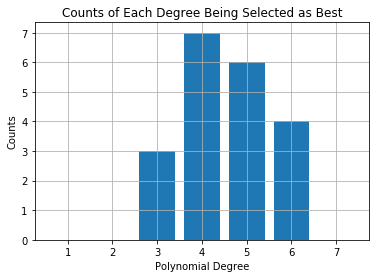

In [35]:
# Print best ds
print("Best d's over cross validations")
print(best_ds)
d_counts = np.zeros((len(d_range)))
unique, counts = np.unique(best_ds, return_counts = True)
d_counts[unique-1] = counts

plt.figure()
plt.title('Counts of Each Degree Being Selected as Best')
plt.bar(1 + np.arange(7), d_counts)
plt.xlabel('Polynomial Degree')
plt.ylabel('Counts')
plt.grid()

In [15]:
# Print out results
print(f"Average of d* is {np.mean(best_ds)} with a standard deviation of {np.std(best_ds)}")
print(f"Average test error is {np.mean(d_errors)} with a standard deviation of {np.std(d_errors)}")

Average of d* is 4.55 with a standard deviation of 0.9733961166965891
Average test error is 0.026317204301075266 with a standard deviation of 0.004159202471422715


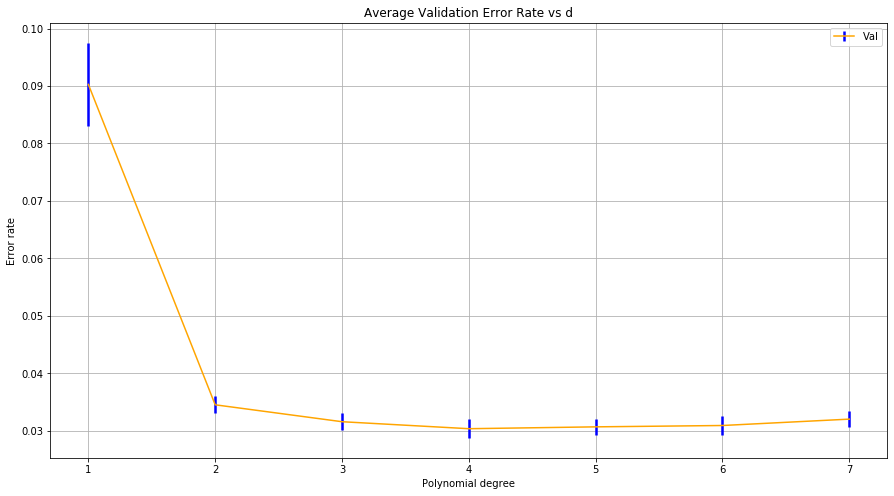

In [16]:
# Cross validation visualisation
av_val_error = np.mean(all_d_errors, axis = 1); std_val_error = np.std(all_d_errors, axis = 1)
plt.figure(figsize = (15,8))
plt.title('Average Validation Error Rate vs d')
plt.errorbar(d_range, av_val_error, yerr = std_val_error, label = 'Val', elinewidth = 2.5, ecolor = 'b', color = 'orange')
plt.xlabel('Polynomial degree')
plt.ylabel('Error rate')
plt.legend()
plt.grid()

### Q1.3.

In [222]:
def compute_confusion(test_labels, test_predictions, num_classes):
    confusion_d = np.zeros((num_classes, num_classes)); confusion_rate_d = np.zeros((num_classes, num_classes))
    for c in range(num_classes):
        for d in range(num_classes):
            if c != d:
                confusion_d[c,d] = np.sum(np.logical_and((test_labels == c), (test_predictions == d)))
                confusion_rate_d[c,d] = confusion_d[c,d] / np.sum(test_labels == c)
                
    return confusion_d, confusion_rate_d

In [223]:
num_classes = 10; n_epochs = 20
confusion_matrices = np.zeros((len(best_ds), num_classes, num_classes))
confusion_rate_matrices = np.zeros((len(best_ds), num_classes, num_classes))

for it in range(len(best_ds)):
    # Re-train using the best_ds, with the same split, so that 
    print(f"For iteration {it+1}")
    d = best_ds[it]
    
    # Same seed as before so we re-simulate the previous part
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    
    # Compute kernel matrices
    kernel_train = polynomial_kernel(train_samples, train_samples, d)
    kernel_test = polynomial_kernel(train_samples, test_samples, d)
    
    # Initiate mistake counters
    mistake_counters = init_mistake_counters(train_samples, num_classes)
    
    mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                                      ,num_classes, kernel_train, kernel_test, n_epochs)
        
    # Compute confusion matrix for this d*
    confusion_matrices[it,:,:], confusion_rate_matrices[it,:,:] = compute_confusion(test_labels, test_preds, num_classes)

For iteration 1
Epoch 0, made 0.07260016133369185 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 1, made 0.012100026888948642 mistakes on training data and mistake rate of 0.04086021505376344 on test data
Epoch 2, made 0.004840010755579457 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 3, made 0.0026888948642108095 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 4, made 0.002016671148158107 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 5, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 8, made 0.0005377789728421619 mistakes on training data a

Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 6, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 7, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 8, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 10, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Early stopping at 10 epochs
For iteration 8
Epoch 0, made 0.07044904544232321 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 1, made 0.008201129335842968 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 2, made 0.00228556063457

Epoch 4, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Early stopping at 7 epochs
For iteration 15
Epoch 0, made 0.06749126109169132 mistakes on training data and mistake rate of 0.041935483870967745 on test data
Epoch 1, made 0.009142242538316752 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 2, made 0.00282333960742135 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 3, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.0009411132024737832 

In [20]:
# Heatmap visualisation
def conf_heatmap(cmatrix, float_prec, title):
    plt.figure(figsize = (15,8))
    plt.title(title)
    sb.heatmap(cmatrix, cmap = 'Blues', annot = True, fmt = float_prec)

In [244]:
# Rate in EVERY class
av_conf_rate = np.mean(confusion_rate_matrices, axis = 0); std_conf_rate = np.std(confusion_rate_matrices, axis = 0)
av_tot_misclass = np.sum(av_conf_rate, axis = 1)
print("Average Confusion Rate Matrix")
print(av_conf_rate)
print("Error Rate for Each Class")
print(av_tot_misclass)

print("Standard Dev of Confusion Rate Matrix")
print(std_conf_rate)

Average Confusion Rate Matrix
[[0.         0.00066152 0.00113297 0.00352696 0.00125598 0.00177875
  0.00279506 0.00015432 0.00033793 0.00080531]
 [0.         0.         0.00075735 0.         0.00270219 0.
  0.0029041  0.00040441 0.00076855 0.        ]
 [0.00486609 0.00190067 0.         0.00634889 0.00650685 0.00083054
  0.00165388 0.00537049 0.0037694  0.0002551 ]
 [0.00159175 0.00060241 0.0049035  0.         0.         0.01819803
  0.         0.00408889 0.00948268 0.00186637]
 [0.0003125  0.00464458 0.00662065 0.00086246 0.         0.0011457
  0.00405045 0.00230489 0.00178404 0.00622584]
 [0.00832631 0.00034965 0.00487506 0.0085306  0.00388781 0.
  0.00842069 0.00102106 0.00392848 0.00478521]
 [0.00720918 0.00152375 0.00273534 0.         0.00589747 0.00252078
  0.         0.0003268  0.00175126 0.00062114]
 [0.00058313 0.00266536 0.00398355 0.00219062 0.00790192 0.00098668
  0.         0.         0.00497092 0.00578858]
 [0.00748985 0.00606491 0.00399467 0.01043444 0.00495509 0.01049391

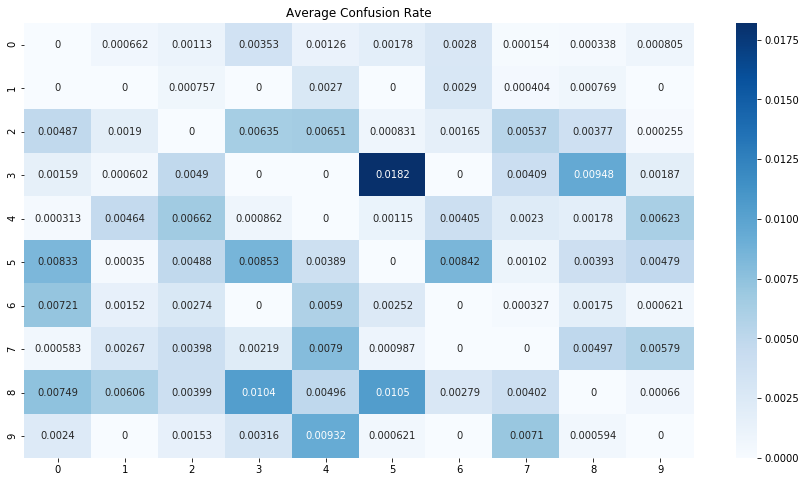

In [247]:
conf_heatmap(av_conf_rate, '.3g', 'Average Confusion Rate')

In [258]:
# Rate over ALL test points
confusion_rate = confusion_matrices / len(test_labels)
av_conf_totrate = np.mean(confusion_rate, axis = 0)
std_conf_totrate = np.std(confusion_rate, axis = 0)
print("Confusion Total Rate Matrix Averaged over 20 runs")
print(av_conf_totrate)
print("Corresponding Standard Deviation")
print(std_conf_totrate)

Confusion Total Rate Matrix Averaged over 20 runs
[[0.00000000e+00 1.07526882e-04 1.88172043e-04 5.91397849e-04
  2.15053763e-04 2.95698925e-04 4.56989247e-04 2.68817204e-05
  5.37634409e-05 1.34408602e-04]
 [0.00000000e+00 0.00000000e+00 1.07526882e-04 0.00000000e+00
  3.76344086e-04 0.00000000e+00 4.03225806e-04 5.37634409e-05
  1.07526882e-04 0.00000000e+00]
 [4.83870968e-04 1.88172043e-04 0.00000000e+00 6.18279570e-04
  6.45161290e-04 8.06451613e-05 1.61290323e-04 5.37634409e-04
  3.76344086e-04 2.68817204e-05]
 [1.34408602e-04 5.37634409e-05 4.30107527e-04 0.00000000e+00
  0.00000000e+00 1.58602151e-03 0.00000000e+00 3.49462366e-04
  8.33333333e-04 1.61290323e-04]
 [2.68817204e-05 4.30107527e-04 6.18279570e-04 8.06451613e-05
  0.00000000e+00 1.07526882e-04 3.76344086e-04 2.15053763e-04
  1.61290323e-04 5.64516129e-04]
 [6.45161290e-04 2.68817204e-05 3.76344086e-04 6.72043011e-04
  2.95698925e-04 0.00000000e+00 6.45161290e-04 8.06451613e-05
  2.95698925e-04 3.76344086e-04]
 [6.4516

In [24]:
# Confusion matrix counts, with standard deviation
av_conf_count = np.mean(confusion_matrices, axis = 0)
std_conf_count = np.std(confusion_matrices, axis = 0)

print("Confusion Matrix Averaged over 20 runs")
print(av_conf_count)
print("Corresponding Standard Deviation")
print(std_conf_count)

Confusion Matrix Averaged over 20 runs
[[0.   0.2  0.35 1.1  0.4  0.55 0.85 0.05 0.1  0.25]
 [0.   0.   0.2  0.   0.7  0.   0.75 0.1  0.2  0.  ]
 [0.9  0.35 0.   1.15 1.2  0.15 0.3  1.   0.7  0.05]
 [0.25 0.1  0.8  0.   0.   2.95 0.   0.65 1.55 0.3 ]
 [0.05 0.8  1.15 0.15 0.   0.2  0.7  0.4  0.3  1.05]
 [1.2  0.05 0.7  1.25 0.55 0.   1.2  0.15 0.55 0.7 ]
 [1.2  0.25 0.45 0.   1.   0.4  0.   0.05 0.3  0.1 ]
 [0.1  0.45 0.65 0.35 1.3  0.15 0.   0.   0.8  0.95]
 [1.05 0.85 0.55 1.45 0.7  1.45 0.4  0.55 0.   0.1 ]
 [0.4  0.   0.25 0.5  1.5  0.1  0.   1.15 0.1  0.  ]]
Corresponding Standard Deviation
[[0.         0.4        0.65383484 0.99498744 0.58309519 0.80467385
  0.96306801 0.21794495 0.3        0.4330127 ]
 [0.         0.         0.4        0.         0.9539392  0.
  0.698212   0.3        0.4        0.        ]
 [0.83066239 0.4769696  0.         1.23592071 1.02956301 0.35707142
  0.45825757 0.89442719 0.71414284 0.21794495]
 [0.4330127  0.43588989 1.12249722 0.         0.         1.9

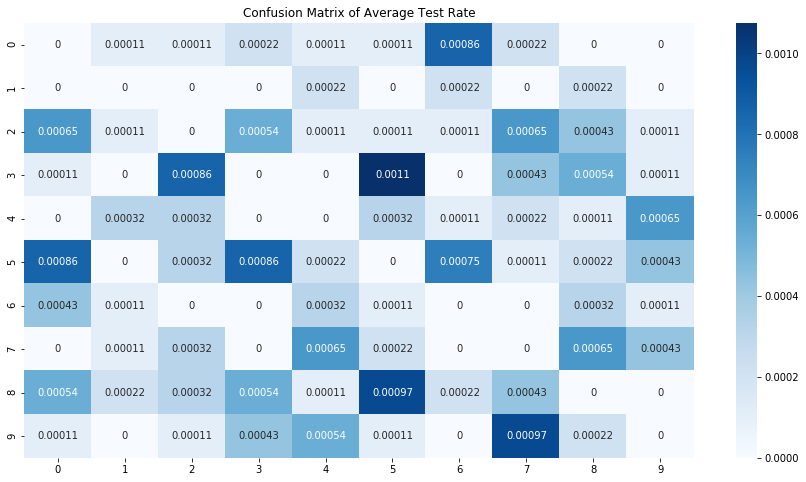

In [96]:
conf_heatmap(np.mean(confusion_rate, axis = 0), '.2g', 'Confusion Matrix of Average Test Rate')

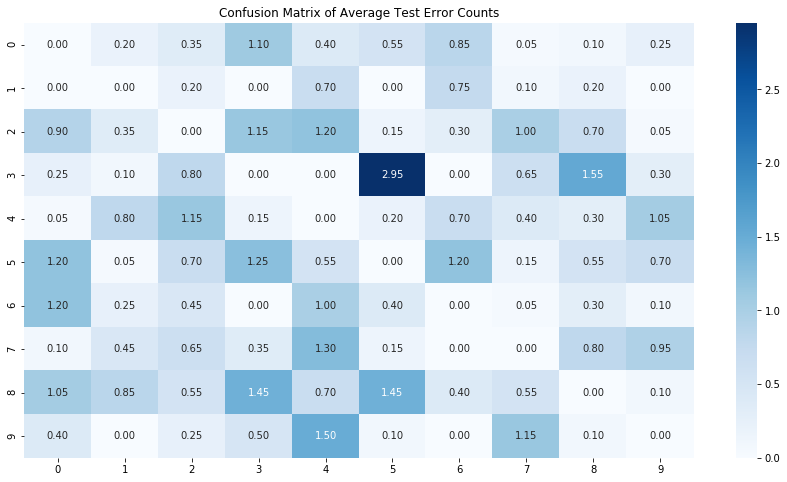

In [22]:
conf_heatmap(np.mean(confusion_matrices, axis = 0), '.2f', 'Confusion Matrix of Average Test Error Counts')

### Q 1.4

Only counting misclassifications when a sample acts as a test set during cross validation before is too limited of an exploration, since we don't see all samples as a test set. The confusion matrix in Q1.3 also do not shed too much insight since the relatively larger entries only provides us with an insight of which digits tend to get mis-classified as which, and they don't actually show which images are prone to mis-classifications. To explore further, we perform a 5-fold cross validation on the whole dataset, and counting mis-classifications only when a chunk is acting as validation set. We do this for all d's. This way, we are guaranteed to see all the samples as an unseen (during training) set exactly once per d.

In [52]:
misclass_cross_val = copy.deepcopy(misclass_counters)
misclassified_indexes = np.where(misclass_cross_val != 0)[0]
counters = misclass_cross_val[misclassified_indexes]
misclass_num, counts = np.unique(counters, return_counts = True)
print("Number of unique misclassification counts")
print(misclass_num)
print("How many images are misclassified that many times")
print(counts)


hardest_idx = np.where(misclass_cross_val == misclass_num[-1])[0]
second_hardest_idx = np.where(misclass_cross_val == misclass_num[-2])[0]

hard_idxs = np.concatenate([hardest_idx, second_hardest_idx])

Number of unique misclassification counts
[1 2 3 4 5 6 7 9]
How many images are misclassified that many times
[172  98  77  40  23  11   3   2]


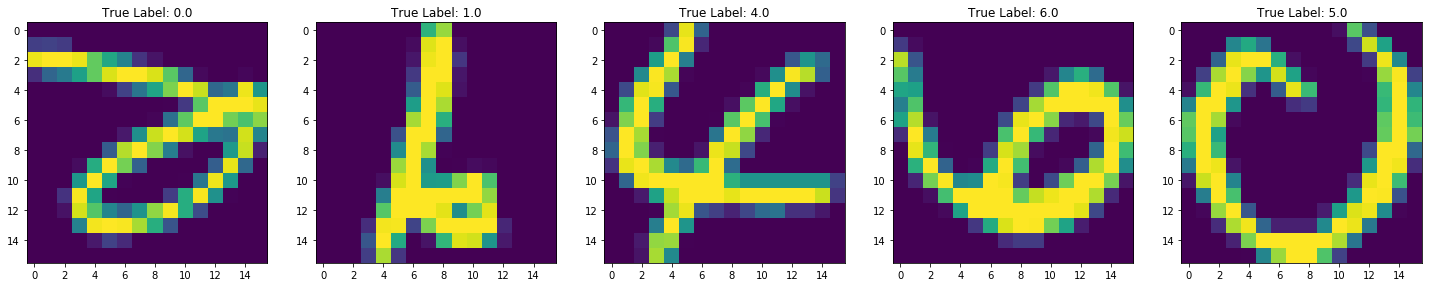

In [57]:
n_bad_ims = len(hard_idxs)
fig, ax = plt.subplots(1, n_bad_ims, figsize = (5*n_bad_ims,5))
for i in range(n_bad_ims):
    bad_ind = hard_idxs[i]
    act_label = data_labels[bad_ind]
    image = data_samples[bad_ind].reshape(16,16)
    ax[i].set_title('True Label: ' + str(act_label))
    ax[i].imshow(image)

In [64]:
misclass_counters = np.zeros((data_labels.shape)); num_iter = 20
for it in range(num_iter):
    # Do 1 cross-validation, and then outer-loop it by 20 times
    start_val = time.time()
    n = 5; epochs = 20; num_classes = 10
    
    np.random.seed(it)
    permute = np.random.permutation(data_labels.shape[0])
    
    new_samples = data_samples[permute, :]; new_labels = data_labels[permute]

    # Compute power 1 of kernel mat (later just raise to power d)
    kernel_pow1 = polynomial_kernel(new_samples, new_samples, 1)

    # Divide into sub-arrays
    x_train, y_train, sub_idxs = getSubArray(new_samples, new_labels.reshape(-1,1), n)

    # Convert to numpy arrays for ease of slicing
    x_train = np.array(x_train); y_train = np.array(y_train)

    # 1 5-fold cross validation starts here
    for d in d_range:
        print(f"For d = {d}")
        kernel_mat_train = kernel_pow1 ** d
        kernel_mat_idxs = np.arange(kernel_mat_train.shape[0])
        # Iterate through each validation sub-array, the rest become training
        val_indexes = np.arange(n); val_err = []

        for val_idx in val_indexes:
            # Get training sub-array indexes
            train_indexes = np.delete(val_indexes, val_idx)

            # Get validation fold index range
            val_range = np.arange(sub_idxs[val_idx][0], sub_idxs[val_idx][1])

            # Slice off the validation samples from the large kernel matrix, and get the train and val based on the folds
            train_kernel_mat = np.delete(kernel_mat_train, val_range, axis = 0)
            val_kernel_mat = train_kernel_mat[:,val_range]
            train_kernel_mat = np.delete(train_kernel_mat, val_range, axis = 1)

            # Take one fold as val, rest becomes training
            val_samples = x_train[val_idx]; val_labels = y_train[val_idx].reshape(-1)

            # Training set
            train_mini_samples = catSubArrays(x_train[train_indexes]); train_mini_labels = catSubArrays(y_train[train_indexes]).reshape(-1)

            # Train on training set for some epochs, and then test
            mistake_counters = init_mistake_counters(train_mini_samples, num_classes)
            mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_mini_samples, train_mini_labels, val_samples, val_labels, mistake_counters
                                                                                          , num_classes, train_kernel_mat, val_kernel_mat, n_epochs)

    
            # Update misclassification counters inside the 5-fold
            test_ori_indexes = permute[val_range]
            misclass_counters = update_misclassification(misclass_counters, test_preds, val_labels, test_ori_indexes)
    
    print(f"Time for 1 cross validation across 7 d is {time.time() - start_val}")

For d = 1
Epoch 0, made 0.14679392391450463 mistakes on training data and mistake rate of 0.09575040344271113 on test data
Epoch 1, made 0.09423309584621589 mistakes on training data and mistake rate of 0.07961269499731038 on test data
Epoch 2, made 0.08536093560962495 mistakes on training data and mistake rate of 0.08015061861215707 on test data
Epoch 3, made 0.0813281355020836 mistakes on training data and mistake rate of 0.10112963959117806 on test data
Epoch 4, made 0.07433794864901197 mistakes on training data and mistake rate of 0.07315761161915008 on test data
Epoch 5, made 0.07393466863825783 mistakes on training data and mistake rate of 0.08015061861215707 on test data
Epoch 6, made 0.06949858851996236 mistakes on training data and mistake rate of 0.07046799354491662 on test data
Epoch 7, made 0.06855760182820271 mistakes on training data and mistake rate of 0.0973641742872512 on test data
Epoch 8, made 0.06734776179594032 mistakes on training data and mistake rate of 0.093598

Epoch 15, made 0.06318902930895402 mistakes on training data and mistake rate of 0.09247311827956989 on test data
Epoch 16, made 0.05875235278300618 mistakes on training data and mistake rate of 0.08279569892473118 on test data
Epoch 17, made 0.05969346598547997 mistakes on training data and mistake rate of 0.09838709677419355 on test data
Epoch 18, made 0.059424576499058884 mistakes on training data and mistake rate of 0.10161290322580645 on test data
Epoch 19, made 0.05324011831137403 mistakes on training data and mistake rate of 0.08655913978494624 on test data
Epoch 0, made 0.14842699650443666 mistakes on training data and mistake rate of 0.11612903225806452 on test data
Epoch 1, made 0.09706910459801021 mistakes on training data and mistake rate of 0.11290322580645161 on test data
Epoch 2, made 0.08980908846464103 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 3, made 0.07918795375100833 mistakes on training data and mistake rate of 0.08440860

Epoch 12, made 0.0014786933727651565 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 13, made 0.001075413362011023 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 14, made 0.001075413362011023 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Epoch 15, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 16, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.03335126412049489 on test data
Early stopping at 16 epochs
Epoch 0, made 0.09061575692390428 mistakes on training data and mistake rate of 0.0478494623655914 on test data
Epoch 1, made 0.033476741059424574 mistakes on training data and mistake rate of 0.04139784946236559 on test data
Epoch 2, made 0.015998924442054314 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 3, made 0.012234471632159183 mistakes on train

Epoch 7, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 8, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 9, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 10, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Early stopping at 10 epochs
Epoch 0, made 0.07851573003495563 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 1, made 0.0169400376445281 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 2, made 0.006991126646948105 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 3, made 0.0038988975531056734 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 4, made 0.002554450121000269 mistakes on trai

Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 8, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 10, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 10 epochs
Epoch 0, made 0.07260016133369185 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 1, made 0.012100026888948642 mistakes on training data and mistake rate of 0.04086021505376344 on test data
Epoch 2, made 0.004840010755579457 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 3, made 0.0026888948642108095 mistakes on t

Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07191826858448716 mistakes on training data and mistake rate of 0.04410973641742873 on test data
Epoch 1, made 0.00820002688533405 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 2, made 0.0016131200430165346 mistakes on training data and mistake rate of 0.0322754168908015 on test data
Epoch 3, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.026358257127487898 on test data
Epoch 4, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 5, made 0.0005377066810055115 mistakes on trai

Epoch 2, made 0.09006586906842318 mistakes on training data and mistake rate of 0.08122646584185046 on test data
Epoch 3, made 0.08643634897163598 mistakes on training data and mistake rate of 0.09575040344271113 on test data
Epoch 4, made 0.0807904288210781 mistakes on training data and mistake rate of 0.07692307692307693 on test data
Epoch 5, made 0.08173141551283775 mistakes on training data and mistake rate of 0.07907477138246369 on test data
Epoch 6, made 0.07850517542680467 mistakes on training data and mistake rate of 0.08015061861215707 on test data
Epoch 7, made 0.07460680198951472 mistakes on training data and mistake rate of 0.11081226465841851 on test data
Epoch 8, made 0.07272482860599543 mistakes on training data and mistake rate of 0.08337816030123722 on test data
Epoch 9, made 0.0723215485952413 mistakes on training data and mistake rate of 0.08983324367939753 on test data
Epoch 10, made 0.07205269525473854 mistakes on training data and mistake rate of 0.086067778375470

Epoch 15, made 0.061037913417585375 mistakes on training data and mistake rate of 0.08763440860215053 on test data
Epoch 16, made 0.06171013713363808 mistakes on training data and mistake rate of 0.08172043010752689 on test data
Epoch 17, made 0.059155687012637806 mistakes on training data and mistake rate of 0.07903225806451612 on test data
Epoch 18, made 0.05875235278300618 mistakes on training data and mistake rate of 0.07365591397849462 on test data
Epoch 19, made 0.05888679752621673 mistakes on training data and mistake rate of 0.08548387096774193 on test data
Epoch 0, made 0.14345254100564667 mistakes on training data and mistake rate of 0.11021505376344086 on test data
Epoch 1, made 0.09733799408443129 mistakes on training data and mistake rate of 0.0967741935483871 on test data
Epoch 2, made 0.09128798063995698 mistakes on training data and mistake rate of 0.09301075268817205 on test data
Epoch 3, made 0.08416240924979833 mistakes on training data and mistake rate of 0.10053763

Epoch 7, made 0.004301653448044092 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 8, made 0.0017475467132679124 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 9, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 10, made 0.0016131200430165346 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 11, made 0.0013442667025137787 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 12, made 0.0017475467132679124 mistakes on training data and mistake rate of 0.03335126412049489 on test data
Epoch 13, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.029047875201721356 on test data
Epoch 14, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 15, made 0.0006721333512568893 mistakes on training data and mistak

Epoch 9, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 10, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.04139784946236559 on test data
Early stopping at 10 epochs
Epoch 0, made 0.08173141551283775 mistakes on training data and mistake rate of 0.04464766003227542 on test data
Epoch 1, made 0.01774432047318188 mistakes on training data and mistake rate of 0.04034427111350188 on test data
Epoch 2, made 0.00699018685307165 mistakes on training data and mistake rate of 0.0392684238838085 on test data
Epoch 3, made 0.002957386745530313 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 4, made 0.002285253394273424 mistakes on training data and mistake rate of 0.03335126412049489 on test data
Epoch 5, made 0.0017475467132679124 mistakes on training data and mistake rate of 0.0328133405056482 on test data
Epoch 6, made 0.00026885334050275576 mistakes on training dat

Epoch 5, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 8, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Early stopping at 8 epochs
Epoch 0, made 0.0797257327238505 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 1, made 0.010755579456843238 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 2, made 0.004167787039526754 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 3, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 4, made 0.0012100026888948643 mistakes on training 

Epoch 7, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 8, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.02689618074233459 on test data
Epoch 9, made 0.00013442667025137788 mistakes on training data and mistake rate of 0.02689618074233459 on test data
Early stopping at 9 epochs
Epoch 0, made 0.06856681903737565 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 1, made 0.00860446356547459 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 2, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 3, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 4, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 5, made 0.0005377789728421619 mistakes on trai

Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 6, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Early stopping at 7 epochs
Time for 1 cross validation across 7 d is 230.0459747314453
For d = 1
Epoch 0, made 0.14706277725500738 mistakes on training data and mistake rate of 0.10166756320602474 on test data
Epoch 1, made 0.09745933593224895 mistakes on training data and mistake rate of 0.09413663259817107 on test data
Epoch 2, made 0.0923511224626966 mistakes on training data and mistake rate of 0.09359870898332437 on test data
Epoch 3, made 0.08388224223685979 mistakes on training data and mistake rate of 0.08929532006455083

Epoch 8, made 0.06856681903737565 mistakes on training data and mistake rate of 0.07688172043010753 on test data
Epoch 9, made 0.06722237160527024 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 10, made 0.0697768217262705 mistakes on training data and mistake rate of 0.1032258064516129 on test data
Epoch 11, made 0.06453347674105943 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 12, made 0.06749126109169132 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 13, made 0.06076902393116429 mistakes on training data and mistake rate of 0.08548387096774193 on test data
Epoch 14, made 0.06426458725463835 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 15, made 0.06534014520032266 mistakes on training data and mistake rate of 0.08709677419354839 on test data
Epoch 16, made 0.06036568970153267 mistakes on training data and mistake rate of 0.079032258

Epoch 7, made 0.004704933458798226 mistakes on training data and mistake rate of 0.037654653039268425 on test data
Epoch 8, made 0.003226240086033069 mistakes on training data and mistake rate of 0.038730500268961805 on test data
Epoch 9, made 0.0026885334050275574 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 10, made 0.0024196800645248017 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 11, made 0.0016131200430165346 mistakes on training data and mistake rate of 0.03550295857988166 on test data
Epoch 12, made 0.001075413362011023 mistakes on training data and mistake rate of 0.037654653039268425 on test data
Epoch 13, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 14, made 0.001075413362011023 mistakes on training data and mistake rate of 0.03496503496503497 on test data
Epoch 15, made 0.00040328001075413364 mistakes on training data and mistak

Epoch 13, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Early stopping at 13 epochs
Epoch 0, made 0.07487565533001747 mistakes on training data and mistake rate of 0.05056481979558903 on test data
Epoch 1, made 0.021239413899717705 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 2, made 0.008468880225836806 mistakes on training data and mistake rate of 0.03335126412049489 on test data
Epoch 3, made 0.004167226777792714 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 4, made 0.002150826724022046 mistakes on training data and mistake rate of 0.03335126412049489 on test data
Epoch 5, made 0.0016131200430165346 mistakes on training data and mistake rate of 0.03388918773534158 on test data
Epoch 6, made 0.0016131200430165346 mistakes on training data and mistake rate of 0.0322754168908015 on test data
Epoch 7, made 0.0013442667025137787 mistakes on training

Epoch 1, made 0.012637805861790804 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 2, made 0.004705566012368916 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 3, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 4, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake 

Epoch 6, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Epoch 7, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.029585798816568046 on test data
Early stopping at 7 epochs
Epoch 0, made 0.06641570314600699 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 1, made 0.009276687281527292 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 2, made 0.002016671148158107 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 3, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 6, made 0.00040333422963162143 mistakes on 

Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Early stopping at 6 epochs
Time for 1 cross validation across 7 d is 224.1285743713379
For d = 1
Epoch 0, made 0.1414168571044495 mistakes on training data and mistake rate of 0.15814954276492738 on test data
Epoch 1, made 0.09732490926199758 mistakes on training data and mistake rate of 0.12049488972565896 on test data
Epoch 2, made 0.08724290899314424 mistakes on training data and mistake rate of 0.0984400215169446 on test data
Epoch 3, made 0.08052157548057534 mistakes on training data and mistake rate of 0.1048951048951049 on test data
Epoch 4, made 0.07527893534077161 mistakes on training data and mistake rate of 0.11081226465841851 on test data
Epoch 5, made 0.07433794864901197 mistakes on training data and mistake rate of 0.09359870898332437 on test data
Epoch 6, made 0.07124613523323027 mistakes on training data and mistake rate of 0.11242603550295859 on test dat

Epoch 11, made 0.06695348211884915 mistakes on training data and mistake rate of 0.08978494623655914 on test data
Epoch 12, made 0.06507125571390159 mistakes on training data and mistake rate of 0.09301075268817205 on test data
Epoch 13, made 0.06641570314600699 mistakes on training data and mistake rate of 0.09623655913978495 on test data
Epoch 14, made 0.06534014520032266 mistakes on training data and mistake rate of 0.09193548387096774 on test data
Epoch 15, made 0.062247916106480235 mistakes on training data and mistake rate of 0.08978494623655914 on test data
Epoch 16, made 0.06184458187684862 mistakes on training data and mistake rate of 0.10806451612903226 on test data
Epoch 17, made 0.06386125302500673 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 18, made 0.062113471363269696 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 19, made 0.0634579187953751 mistakes on training data and mistake rate of 0.0903

Epoch 9, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 10, made 0.0025541067347761796 mistakes on training data and mistake rate of 0.04088219472834857 on test data
Epoch 11, made 0.0013442667025137787 mistakes on training data and mistake rate of 0.04088219472834857 on test data
Epoch 12, made 0.0016131200430165346 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 13, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.0392684238838085 on test data
Epoch 14, made 0.0012098400322624009 mistakes on training data and mistake rate of 0.04195804195804196 on test data
Epoch 15, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 16, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Early stopping at 16 epochs
Epoch 0, made 0.09155687012637806 mistakes 

Epoch 0, made 0.07675762871353677 mistakes on training data and mistake rate of 0.05325443786982249 on test data
Epoch 1, made 0.0164000537706681 mistakes on training data and mistake rate of 0.04464766003227542 on test data
Epoch 2, made 0.008468880225836806 mistakes on training data and mistake rate of 0.04249596557288865 on test data
Epoch 3, made 0.004167226777792714 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 4, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.03550295857988166 on test data
Epoch 5, made 0.002285253394273424 mistakes on training data and mistake rate of 0.038730500268961805 on test data
Epoch 6, made 0.0016131200430165346 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 7, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 8, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.03

Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07206238236084969 mistakes on training data and mistake rate of 0.0489247311827957 on test data
Epoch 1, made 0.0112933584296854 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 2, made 0.005377789728421619 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 3, made 0.0026888948642108095 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 4, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 5, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.0008066684592632429 mistakes on training 

Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07017072187121925 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 1, made 0.0077967468745799165 mistakes on training data and mistake rate of 0.04088219472834857 on test data
Epoch 2, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.03550295857988166 on test data
Epoch 3, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.0328133405056482 on test data
Epoch 4, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.0322754168908015 on test data
Epoch 5, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.0322754168908015 on test data
Epoch 6, made 0.00026885334050275576 mistakes on tr

Epoch 5, made 0.08052157548057534 mistakes on training data and mistake rate of 0.0720817643894567 on test data
Epoch 6, made 0.07877402876730744 mistakes on training data and mistake rate of 0.10328133405056482 on test data
Epoch 7, made 0.07380024196800646 mistakes on training data and mistake rate of 0.07638515330823023 on test data
Epoch 8, made 0.07648877537303402 mistakes on training data and mistake rate of 0.0914470145239376 on test data
Epoch 9, made 0.0740690953085092 mistakes on training data and mistake rate of 0.08122646584185046 on test data
Epoch 10, made 0.07191826858448716 mistakes on training data and mistake rate of 0.06777837547068316 on test data
Epoch 11, made 0.06734776179594032 mistakes on training data and mistake rate of 0.06777837547068316 on test data
Epoch 12, made 0.06882645516870547 mistakes on training data and mistake rate of 0.07261968800430339 on test data
Epoch 13, made 0.06533136174216965 mistakes on training data and mistake rate of 0.0726196880043

Epoch 18, made 0.055256789459532135 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 19, made 0.052433449852110785 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 0, made 0.14842699650443666 mistakes on training data and mistake rate of 0.11881720430107527 on test data
Epoch 1, made 0.10204356009680021 mistakes on training data and mistake rate of 0.09247311827956989 on test data
Epoch 2, made 0.08954019897821995 mistakes on training data and mistake rate of 0.08387096774193549 on test data
Epoch 3, made 0.08833019628932509 mistakes on training data and mistake rate of 0.08763440860215053 on test data
Epoch 4, made 0.08120462489916644 mistakes on training data and mistake rate of 0.07903225806451612 on test data
Epoch 5, made 0.08429685399300887 mistakes on training data and mistake rate of 0.10698924731182796 on test data
Epoch 6, made 0.0747512772250605 mistakes on training data and mistake rate of 0.07956989247

Epoch 11, made 0.0018819733835192902 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 12, made 0.001075413362011023 mistakes on training data and mistake rate of 0.037654653039268425 on test data
Epoch 13, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 14, made 0.0013442667025137787 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 15, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 16, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.029585798816568046 on test data
Epoch 17, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 18, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.029047875201721356 on test data
Epoch 19, made 0.00013442667025137788 mistakes on training data 

Epoch 4, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 5, made 0.0014786933727651565 mistakes on training data and mistake rate of 0.03012372243141474 on test data
Epoch 6, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.03012372243141474 on test data
Epoch 7, made 0.001075413362011023 mistakes on training data and mistake rate of 0.029585798816568046 on test data
Epoch 8, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.02689618074233459 on test data
Epoch 9, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 10, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.026358257127487898 on test data
Epoch 11, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.02420656266810113 on test data
Early stopping at 11 epochs
Epoch 0, made 0.0790535090077978 mistakes on t

Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 7, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 8, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 10, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Early stopping at 10 epochs
Epoch 0, made 0.07488572196827104 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 1, made 0.012772250605001345 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 2, made 0.003092229093842431 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 3, made 0.002285560634579188 mistakes on tra

Epoch 2, made 0.003092229093842431 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 3, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 8, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 9, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 9 epochs
Epoch 0, made 0.07312810861674957 mistakes on tra

Epoch 1, made 0.09638392257023794 mistakes on training data and mistake rate of 0.11350188273265197 on test data
Epoch 2, made 0.08455437558811668 mistakes on training data and mistake rate of 0.10543302850995159 on test data
Epoch 3, made 0.08119370883183223 mistakes on training data and mistake rate of 0.13232920925228617 on test data
Epoch 4, made 0.07366581529775508 mistakes on training data and mistake rate of 0.09682625067240452 on test data
Epoch 5, made 0.0723215485952413 mistakes on training data and mistake rate of 0.08606777837547068 on test data
Epoch 6, made 0.06896088183895685 mistakes on training data and mistake rate of 0.09252286175363099 on test data
Epoch 7, made 0.06828874848769996 mistakes on training data and mistake rate of 0.0984400215169446 on test data
Epoch 8, made 0.0656002150826724 mistakes on training data and mistake rate of 0.09037116729424421 on test data
Epoch 9, made 0.06425594838015862 mistakes on training data and mistake rate of 0.09198493813878429

Epoch 14, made 0.06466792148426996 mistakes on training data and mistake rate of 0.09247311827956989 on test data
Epoch 15, made 0.061172358160795914 mistakes on training data and mistake rate of 0.08978494623655914 on test data
Epoch 16, made 0.062113471363269696 mistakes on training data and mistake rate of 0.08279569892473118 on test data
Epoch 17, made 0.061172358160795914 mistakes on training data and mistake rate of 0.07688172043010753 on test data
Epoch 18, made 0.06144124764721699 mistakes on training data and mistake rate of 0.08709677419354839 on test data
Epoch 19, made 0.06090346867437483 mistakes on training data and mistake rate of 0.1010752688172043 on test data
Epoch 0, made 0.14399031997848885 mistakes on training data and mistake rate of 0.12096774193548387 on test data
Epoch 1, made 0.09653132562516806 mistakes on training data and mistake rate of 0.08817204301075268 on test data
Epoch 2, made 0.08765797257327239 mistakes on training data and mistake rate of 0.086559

Epoch 5, made 0.00699018685307165 mistakes on training data and mistake rate of 0.03388918773534158 on test data
Epoch 6, made 0.005108213469552359 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 7, made 0.004167226777792714 mistakes on training data and mistake rate of 0.03388918773534158 on test data
Epoch 8, made 0.003226240086033069 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 9, made 0.0025541067347761796 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 10, made 0.0028229600752789352 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 11, made 0.001075413362011023 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 12, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.0322754168908015 on test data
Epoch 13, made 0.0017475467132679124 mistakes on training data and mistake rate o

Epoch 6, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 7, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 8, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Early stopping at 9 epochs
Epoch 0, made 0.0776986154052964 mistakes on training data and mistake rate of 0.05002689618074233 on test data
Epoch 1, made 0.01787874714343326 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 2, made 0.0077967468745799165 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 3, made 0.003495093426535825 mistakes on training data and mistake rate of 0.0322754168908015 on test data
Epoch 4, made 0.0026885334050275574 mistakes on training da

Epoch 9, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.029585798816568046 on test data
Early stopping at 9 epochs
Epoch 0, made 0.07461683248184996 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 1, made 0.012234471632159183 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 2, made 0.004167787039526754 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 3, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 4, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.02

Epoch 0, made 0.0691045980102178 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 1, made 0.009411132024737832 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 2, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 3, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07164941524398441 mistakes on train

Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Early stopping at 6 epochs
Time for 1 cross validation across 7 d is 229.9578320980072
For d = 1
Epoch 0, made 0.1451808038714881 mistakes on training data and mistake rate of 0.08875739644970414 on test data
Epoch 1, made 0.10364296276381234 mistakes on training data and mistake rate of 0.09306078536847767 on test data
Epoch 2, made 0.08710848232289287 mistakes on training data and mistake rate of 0.11242603550295859 on test data
Epoch 3, made 0.08388224223685979 mistakes on training data and mistake rate of 0.08660570199031738 on test data
Epoch 4, made 0.08159698884258637 mistakes on training data and mistake rate of 0.085529854760624 on tes

Epoch 9, made 0.0670879268620597 mistakes on training data and mistake rate of 0.08978494623655914 on test data
Epoch 10, made 0.06560903468674374 mistakes on training data and mistake rate of 0.09086021505376345 on test data
Epoch 11, made 0.06587792417316483 mistakes on training data and mistake rate of 0.0913978494623656 on test data
Epoch 12, made 0.062247916106480235 mistakes on training data and mistake rate of 0.08817204301075268 on test data
Epoch 13, made 0.06292013982253294 mistakes on training data and mistake rate of 0.09462365591397849 on test data
Epoch 14, made 0.05996235547190105 mistakes on training data and mistake rate of 0.0935483870967742 on test data
Epoch 15, made 0.06171013713363808 mistakes on training data and mistake rate of 0.08709677419354839 on test data
Epoch 16, made 0.06184458187684862 mistakes on training data and mistake rate of 0.10752688172043011 on test data
Epoch 17, made 0.059155687012637806 mistakes on training data and mistake rate of 0.0908602

Epoch 1, made 0.03414437424384998 mistakes on training data and mistake rate of 0.0586336740182894 on test data
Epoch 2, made 0.01787874714343326 mistakes on training data and mistake rate of 0.04410973641742873 on test data
Epoch 3, made 0.011963973652372631 mistakes on training data and mistake rate of 0.04410973641742873 on test data
Epoch 4, made 0.009006586906842317 mistakes on training data and mistake rate of 0.04464766003227542 on test data
Epoch 5, made 0.006586906842317516 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 6, made 0.0038983734372899583 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 7, made 0.0037639467670385804 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 8, made 0.002150826724022046 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 9, made 0.002150826724022046 mistakes on training data and mistake rate of 0.03119

Epoch 6, made 0.0014786933727651565 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 7, made 0.001075413362011023 mistakes on training data and mistake rate of 0.029585798816568046 on test data
Epoch 8, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.03388918773534158 on test data
Epoch 9, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.0322754168908015 on test data
Epoch 10, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 11, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.0328133405056482 on test data
Early stopping at 11 epochs
Epoch 0, made 0.07999462221027158 mistakes on training data and mistake rate of 0.0467741935483871 on test data
Epoch 1, made 0.01720892713094918 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 2, made 0.008201129335842968 mistakes on train

Epoch 11, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 12, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 13, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 13 epochs
Epoch 0, made 0.07044904544232321 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 1, made 0.01398225329389621 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 2, made 0.0036300080666845924 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 3, made 0.002285560634579188 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 4, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 5, made 0.0005377789728421619 mistakes on

Epoch 2, made 0.003361118580263512 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 3, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 4, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 7, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07030514854147063 mistakes on training data and mistake rate of 0.04088219472834857 on test data
Epoch 1, made 0.009409866917596451 mistakes o

Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 8, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 9, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Early stopping at 9 epochs
Time for 1 cross validation across 7 d is 227.03930044174194
For d = 1
Epoch 0, made 0.15270869740556525 mistakes on training data and mistake rate of 0.09628832705755783 on test data
Epoch 1, made 0.10135770936953892 mistakes on training data and mistake rate of 0.0871436256

Epoch 7, made 0.0734068297929551 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 8, made 0.06856681903737565 mistakes on training data and mistake rate of 0.08978494623655914 on test data
Epoch 9, made 0.07044904544232321 mistakes on training data and mistake rate of 0.09462365591397849 on test data
Epoch 10, made 0.06897015326700726 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 11, made 0.06574347942995429 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 12, made 0.06493681097069105 mistakes on training data and mistake rate of 0.08978494623655914 on test data
Epoch 13, made 0.06332347405216456 mistakes on training data and mistake rate of 0.08924731182795699 on test data
Epoch 14, made 0.06399569776821726 mistakes on training data and mistake rate of 0.07956989247311828 on test data
Epoch 15, made 0.06453347674105943 mistakes on training data and mistake rate of 0.089247311

Epoch 19, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 0, made 0.09436752251646727 mistakes on training data and mistake rate of 0.06293706293706294 on test data
Epoch 1, made 0.03239682753058207 mistakes on training data and mistake rate of 0.046799354491662185 on test data
Epoch 2, made 0.01653448044091948 mistakes on training data and mistake rate of 0.04895104895104895 on test data
Epoch 3, made 0.010485280279607474 mistakes on training data and mistake rate of 0.04464766003227542 on test data
Epoch 4, made 0.009006586906842317 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 5, made 0.006586906842317516 mistakes on training data and mistake rate of 0.038730500268961805 on test data
Epoch 6, made 0.004570506788546848 mistakes on training data and mistake rate of 0.03442711135018827 on test data
Epoch 7, made 0.003495093426535825 mistakes on training data and mistake rate of 0.036

Epoch 13, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.02689618074233459 on test data
Early stopping at 13 epochs
Epoch 0, made 0.07945684323742942 mistakes on training data and mistake rate of 0.05860215053763441 on test data
Epoch 1, made 0.018015595590212423 mistakes on training data and mistake rate of 0.04139784946236559 on test data
Epoch 2, made 0.006184458187684862 mistakes on training data and mistake rate of 0.03870967741935484 on test data
Epoch 3, made 0.0034955633234740524 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 4, made 0.0026888948642108095 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 6, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 7, made 0.0008066684592632429 mistakes on train

Epoch 10, made 0.00013442667025137788 mistakes on training data and mistake rate of 0.03335126412049489 on test data
Epoch 11, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.03012372243141474 on test data
Epoch 12, made 0.0 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Early stopping at 12 epochs
Epoch 0, made 0.07313794030653402 mistakes on training data and mistake rate of 0.04139784946236559 on test data
Epoch 1, made 0.012637805861790804 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 2, made 0.004436676525947835 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 3, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 5, made 0.0013444474321054048 mistakes on training data and mi

Epoch 8, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Early stopping at 8 epochs
For d = 6
Epoch 0, made 0.07138056190348165 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 1, made 0.009813146928350584 mistakes on training data and mistake rate of 0.02689618074233459 on test data
Epoch 2, made 0.003226240086033069 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 3, made 0.0012098400322624009 mistakes on training data and mistake rate of 0.025820333512641205 on test data
Epoch 4, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 5, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 6, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.02420656266810113 on test data
Early stopping at 6 epochs
Epoch 0, made 

Epoch 1, made 0.009680021511158914 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 2, made 0.002554450121000269 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 3, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07623016940037644 mistakes on training data and mistake rate of 0.04086021505376344 on test data
Epoch 1, made 0.009007797795106211 mistakes on train

Epoch 16, made 0.05632477483532733 mistakes on training data and mistake rate of 0.10650887573964497 on test data
Epoch 17, made 0.060492001613120044 mistakes on training data and mistake rate of 0.09252286175363099 on test data
Epoch 18, made 0.0559214948245732 mistakes on training data and mistake rate of 0.10112963959117806 on test data
Epoch 19, made 0.05430837478155666 mistakes on training data and mistake rate of 0.0979020979020979 on test data
Epoch 0, made 0.14116698037106748 mistakes on training data and mistake rate of 0.1043010752688172 on test data
Epoch 1, made 0.0953213229362732 mistakes on training data and mistake rate of 0.1043010752688172 on test data
Epoch 2, made 0.08685130411400914 mistakes on training data and mistake rate of 0.0935483870967742 on test data
Epoch 3, made 0.08389351976337725 mistakes on training data and mistake rate of 0.10215053763440861 on test data
Epoch 4, made 0.07757461683248185 mistakes on training data and mistake rate of 0.091935483870967

Epoch 15, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 16, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 17, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 18, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 19, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Early stopping at 19 epochs
Epoch 0, made 0.0863019223013846 mistakes on training data and mistake rate of 0.057019903173749324 on test data
Epoch 1, made 0.03374109423309585 mistakes on training data and mistake rate of 0.0521785906401291 on test data
Epoch 2, made 0.01787874714343326 mistakes on training data and mistake rate of 0.05809575040344271 on test data
Epoch 3, made 0.012904960344132277 mistakes on traini

Epoch 9, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 10, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Early stopping at 10 epochs
Epoch 0, made 0.07514450867052024 mistakes on training data and mistake rate of 0.05379236148466918 on test data
Epoch 1, made 0.019491867186449793 mistakes on training data and mistake rate of 0.04303388918773534 on test data
Epoch 2, made 0.008468880225836806 mistakes on training data and mistake rate of 0.04195804195804196 on test data
Epoch 3, made 0.004301653448044092 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 4, made 0.003226240086033069 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 5, made 0.0018819733835192902 mistakes on training data and mistake rate of 0.03550295857988166 on test data
Epoch 6, made 0.0008065600215082673 mistakes on trainin

Epoch 2, made 0.002285560634579188 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 3, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 5, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07367571927937618 mistakes on training data and mistake rate of 0.04139784946236559 on test data
Epoch 1, made 0.011965582145738101 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 2, made 0.004974455498789997 mistakes on training

Epoch 6, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.02097902097902098 on test data
Epoch 7, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.02097902097902098 on test data
Epoch 8, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.02151694459386767 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07004571121269158 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 1, made 0.009007797795106211 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 2, made 0.002285560634579188 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 3, made 0.002285560634579188 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 5, made 0.00040333422963162143 mistakes on tra

Epoch 2, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 3, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 5, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 7 epochs
Time for 1 cross validation across 7 d is 220.8931794166565
For d = 1
Epoch 0, made 0.14329883048796882 mistakes on training data and mistake rate of 0.09467455621301775 on test data
Epoch 1, made 0.0959806425594838 mistakes on training data and mistake rate of 0.10704679935

Epoch 6, made 0.0754235009411132 mistakes on training data and mistake rate of 0.08763440860215053 on test data
Epoch 7, made 0.07381016402258672 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 8, made 0.06897015326700726 mistakes on training data and mistake rate of 0.07956989247311828 on test data
Epoch 9, made 0.0684323742941651 mistakes on training data and mistake rate of 0.08279569892473118 on test data
Epoch 10, made 0.06897015326700726 mistakes on training data and mistake rate of 0.08387096774193549 on test data
Epoch 11, made 0.06547458994353321 mistakes on training data and mistake rate of 0.08602150537634409 on test data
Epoch 12, made 0.06426458725463835 mistakes on training data and mistake rate of 0.07634408602150537 on test data
Epoch 13, made 0.06534014520032266 mistakes on training data and mistake rate of 0.07795698924731183 on test data
Epoch 14, made 0.06587792417316483 mistakes on training data and mistake rate of 0.08118279569

Epoch 0, made 0.08979701572792043 mistakes on training data and mistake rate of 0.056481979558902634 on test data
Epoch 1, made 0.0315902675090738 mistakes on training data and mistake rate of 0.0521785906401291 on test data
Epoch 2, made 0.019357440516198414 mistakes on training data and mistake rate of 0.046799354491662185 on test data
Epoch 3, made 0.013711520365640543 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 4, made 0.0077967468745799165 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 5, made 0.007662320204328539 mistakes on training data and mistake rate of 0.04195804195804196 on test data
Epoch 6, made 0.0038983734372899583 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 7, made 0.003226240086033069 mistakes on training data and mistake rate of 0.04088219472834857 on test data
Epoch 8, made 0.003360666756284447 mistakes on training data and mistake rate of 0.0408

Epoch 7, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 9, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 10, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Early stopping at 10 epochs
Epoch 0, made 0.07890845543755881 mistakes on training data and mistake rate of 0.046799354491662185 on test data
Epoch 1, made 0.017341040462427744 mistakes on training data and mistake rate of 0.0328133405056482 on test data
Epoch 2, made 0.008334453555585429 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 3, made 0.004570506788546848 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 4, made 0.002285253394273424 mistakes on tra

Epoch 10, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.029585798816568046 on test data
Epoch 11, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.029047875201721356 on test data
Early stopping at 11 epochs
Epoch 0, made 0.07286905082011293 mistakes on training data and mistake rate of 0.04247311827956989 on test data
Epoch 1, made 0.011024468943264318 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 2, made 0.004033342296316214 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 3, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 6, made 0.0005377789728421619 mistakes 

Epoch 2, made 0.0025541067347761796 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 3, made 0.0012098400322624009 mistakes on training data and mistake rate of 0.03496503496503497 on test data
Epoch 4, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.0328133405056482 on test data
Epoch 5, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.03550295857988166 on test data
Epoch 6, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.03550295857988166 on test data
Epoch 7, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.03442711135018827 on test data
Early stopping at 7 epochs
Epoch 0, made 0.06749126109169132 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 1, made 0.009680021511158914 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 2, made 0.002016671148158107 mistakes on trainin

Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 7, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07085237967195483 mistakes on training data and mistake rate of 0.03870967741935484 on test data
Epoch 1, made 0.00873890830868513 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 2, made 0.002285560634579188 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 3, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 4, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 5, made 0.00040333422963162143 mistakes on tr

Epoch 2, made 0.08752352783006184 mistakes on training data and mistake rate of 0.10913978494623656 on test data
Epoch 3, made 0.08375907502016672 mistakes on training data and mistake rate of 0.09086021505376345 on test data
Epoch 4, made 0.07623016940037644 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 5, made 0.0740790535090078 mistakes on training data and mistake rate of 0.08548387096774193 on test data
Epoch 6, made 0.07367571927937618 mistakes on training data and mistake rate of 0.09731182795698924 on test data
Epoch 7, made 0.07018015595590213 mistakes on training data and mistake rate of 0.09623655913978495 on test data
Epoch 8, made 0.06762570583490185 mistakes on training data and mistake rate of 0.0978494623655914 on test data
Epoch 9, made 0.06305458456574348 mistakes on training data and mistake rate of 0.0989247311827957 on test data
Epoch 10, made 0.06547458994353321 mistakes on training data and mistake rate of 0.0801075268817204

Epoch 14, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 15, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Early stopping at 15 epochs
Epoch 0, made 0.09141013577093696 mistakes on training data and mistake rate of 0.0586336740182894 on test data
Epoch 1, made 0.031052560828068287 mistakes on training data and mistake rate of 0.04895104895104895 on test data
Epoch 2, made 0.019760720526952547 mistakes on training data and mistake rate of 0.055944055944055944 on test data
Epoch 3, made 0.01330824035488641 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 4, made 0.008737733566339561 mistakes on training data and mistake rate of 0.03442711135018827 on test data
Epoch 5, made 0.006855760182820272 mistakes on training data and mistake rate of 0.04410973641742873 on test data
Epoch 6, made 0.005108213469552359 mistakes on training

Epoch 13, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Early stopping at 13 epochs
Epoch 0, made 0.07959128798063995 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 1, made 0.02030115622479161 mistakes on training data and mistake rate of 0.047311827956989246 on test data
Epoch 2, made 0.006587792417316483 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 3, made 0.003764452809895133 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 4, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 5, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 7, made 0.00040333422963162143 mistakes on tra

Epoch 4, made 0.0013442667025137787 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 5, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.029585798816568046 on test data
Epoch 6, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Epoch 7, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 8, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07152460338800753 mistakes on training data and mistake rate of 0.05913978494623656 on test data
Epoch 1, made 0.011965582145738101 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 2, made 0.004705566012368916 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 3, made 0.00282333960742135 mistakes on train

Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 10, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Early stopping at 10 epochs
For d = 6
Epoch 0, made 0.06707890845543756 mistakes on training data and mistake rate of 0.04249596557288865 on test data
Epoch 1, made 0.012904960344132277 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 2, made 0.002150826724022046 mistakes on training data and mistake rate of 0.03442711135018827 on test data
Epoch 3, made 0.0013442667025137787 mistakes on training data and mistake rate of 0.0322754168908015 on test data
Epoch 4, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.03388918773534158 on test data
Epoch 5, made 0.00040328001075413364 mis

Epoch 2, made 0.002554450121000269 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 3, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07044904544232321 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 1, made 0.009142242538316752 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 2, made 0.002016671148158107 mistakes on trainin

Epoch 18, made 0.05968544159161178 mistakes on training data and mistake rate of 0.08068854222700376 on test data
Epoch 19, made 0.058475601559349374 mistakes on training data and mistake rate of 0.09037116729424421 on test data
Epoch 0, made 0.14936810970691047 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 1, made 0.09760688357085238 mistakes on training data and mistake rate of 0.08817204301075268 on test data
Epoch 2, made 0.08738908308685131 mistakes on training data and mistake rate of 0.08279569892473118 on test data
Epoch 3, made 0.08160795912879806 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 4, made 0.07757461683248185 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 5, made 0.0734068297929551 mistakes on training data and mistake rate of 0.07849462365591398 on test data
Epoch 6, made 0.06964237698305996 mistakes on training data and mistake rate of 0.075268817204

Epoch 13, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 14, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 15, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 16, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 17, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 18, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Early stopping at 18 epochs
Epoch 0, made 0.09705605592149483 mistakes on training data and mistake rate of 0.05164066702528241 on test data
Epoch 1, made 0.03683290764887754 mistakes on training data and mistake rate of 0.056481979558902634 on test data
Epoch 2, made 0.019491867186449793 mistakes on 

Epoch 1, made 0.017881150847001884 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 2, made 0.007394460876579726 mistakes on training data and mistake rate of 0.04139784946236559 on test data
Epoch 3, made 0.0034955633234740524 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 4, made 0.0026888948642108095 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 5, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 7, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 8, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 9, made 0.00040333422963162143 mistakes on training data and mistake rate o

Epoch 2, made 0.005914773491060626 mistakes on training data and mistake rate of 0.025820333512641205 on test data
Epoch 3, made 0.0018819733835192902 mistakes on training data and mistake rate of 0.020441097364174286 on test data
Epoch 4, made 0.0012098400322624009 mistakes on training data and mistake rate of 0.02097902097902098 on test data
Epoch 5, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.023130715438407747 on test data
Epoch 6, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.022592791823561054 on test data
Epoch 7, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.02097902097902098 on test data
Epoch 8, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.022592791823561054 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07004571121269158 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 1, made 0.014116698037106749 mistakes on tra

Epoch 0, made 0.07164941524398441 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 1, made 0.009678720258099207 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 2, made 0.0014786933727651565 mistakes on training data and mistake rate of 0.026358257127487898 on test data
Epoch 3, made 0.001075413362011023 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 4, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 5, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.02420656266810113 on test data
Epoch 6, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.026358257127487898 on test data
Epoch 7, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.025820333512641205 on test data
Epoch 8, made 0.0005377066810055115 mistakes on training data and mistake rat

Epoch 2, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 3, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 4, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Early stopping at 6 epochs
Epoch 0, made 0.06870126378058618 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 1, made 0.006722237160527024 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 2, made 0.00282333960742135 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 3, made 0.00040333422963162143 mistakes on trai

Epoch 19, made 0.056190348165075954 mistakes on training data and mistake rate of 0.08337816030123722 on test data
Epoch 0, made 0.14170475934390966 mistakes on training data and mistake rate of 0.07741935483870968 on test data
Epoch 1, made 0.09559021242269428 mistakes on training data and mistake rate of 0.08118279569892473 on test data
Epoch 2, made 0.0890024200053778 mistakes on training data and mistake rate of 0.07903225806451612 on test data
Epoch 3, made 0.07891906426458725 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 4, made 0.07596127991395536 mistakes on training data and mistake rate of 0.07526881720430108 on test data
Epoch 5, made 0.07569239042753428 mistakes on training data and mistake rate of 0.07849462365591398 on test data
Epoch 6, made 0.07219682710406024 mistakes on training data and mistake rate of 0.08172043010752689 on test data
Epoch 7, made 0.07018015595590213 mistakes on training data and mistake rate of 0.0854838709677

Epoch 13, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 14, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 15, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 16, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 17, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 18, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 19, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 0, made 0.09020029573867455 mistakes on training data and mistake rate of 0.04895104895104895 on test data
Epoch 1, made 0.030918134157816912 mistakes on training data and mistak

Epoch 0, made 0.07648877537303402 mistakes on training data and mistake rate of 0.062399139322216246 on test data
Epoch 1, made 0.018013173813684634 mistakes on training data and mistake rate of 0.04142011834319527 on test data
Epoch 2, made 0.007124613523323027 mistakes on training data and mistake rate of 0.037654653039268425 on test data
Epoch 3, made 0.0048393601290496035 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 4, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 5, made 0.0013442667025137787 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 6, made 0.0014786933727651565 mistakes on training data and mistake rate of 0.0328133405056482 on test data
Epoch 7, made 0.0013442667025137787 mistakes on training data and mistake rate of 0.037654653039268425 on test data
Epoch 8, made 0.0013442667025137787 mistakes on training data and mistake rate of

Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07260016133369185 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 1, made 0.013847808550685669 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 2, made 0.004033342296316214 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 3, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 4, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 5, made 0.00040333422963162143 mistakes on t

Epoch 5, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02043010752688172 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.021505376344086023 on test data
Early stopping at 9 epochs
Epoch 0, made 0.06613792176367791 mistakes on training data and mistake rate of 0.047875201721355565 on test data
Epoch 1, made 0.01075413362011023 mistakes on training data and mistake rate of 0.03442711135018827 on test data
Epoch 2, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.03496503496503497 on test data
Epoch 3, made 0.0013442667025137787 mistakes on 

Epoch 4, made 0.08011829546982122 mistakes on training data and mistake rate of 0.11296395911780527 on test data
Epoch 5, made 0.07742976206479366 mistakes on training data and mistake rate of 0.08015061861215707 on test data
Epoch 6, made 0.0771609087242909 mistakes on training data and mistake rate of 0.0720817643894567 on test data
Epoch 7, made 0.07433794864901197 mistakes on training data and mistake rate of 0.08606777837547068 on test data
Epoch 8, made 0.06976744186046512 mistakes on training data and mistake rate of 0.08284023668639054 on test data
Epoch 9, made 0.07124613523323027 mistakes on training data and mistake rate of 0.07746100053792361 on test data
Epoch 10, made 0.06533136174216965 mistakes on training data and mistake rate of 0.07907477138246369 on test data
Epoch 11, made 0.06627234843392929 mistakes on training data and mistake rate of 0.08337816030123722 on test data
Epoch 12, made 0.06775104180669445 mistakes on training data and mistake rate of 0.0656266810112

Epoch 17, made 0.06009680021511159 mistakes on training data and mistake rate of 0.08602150537634409 on test data
Epoch 18, made 0.061979026620059156 mistakes on training data and mistake rate of 0.08172043010752689 on test data
Epoch 19, made 0.05808012906695348 mistakes on training data and mistake rate of 0.07580645161290323 on test data
Epoch 0, made 0.1415703146006991 mistakes on training data and mistake rate of 0.09462365591397849 on test data
Epoch 1, made 0.09653132562516806 mistakes on training data and mistake rate of 0.1032258064516129 on test data
Epoch 2, made 0.08133906964237698 mistakes on training data and mistake rate of 0.1064516129032258 on test data
Epoch 3, made 0.08160795912879806 mistakes on training data and mistake rate of 0.110752688172043 on test data
Epoch 4, made 0.07703683785963969 mistakes on training data and mistake rate of 0.0956989247311828 on test data
Epoch 5, made 0.07448238773863942 mistakes on training data and mistake rate of 0.0946236559139784

Epoch 10, made 0.001075413362011023 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 11, made 0.001075413362011023 mistakes on training data and mistake rate of 0.038730500268961805 on test data
Epoch 12, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 13, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.038730500268961805 on test data
Epoch 14, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 15, made 0.00013442667025137788 mistakes on training data and mistake rate of 0.03496503496503497 on test data
Epoch 16, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.038730500268961805 on test data
Epoch 17, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.038730500268961805 on test data
Epoch 18, made 0.0 mistakes on training data and mistake rate of 0.

Epoch 13, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.021505376344086023 on test data
Early stopping at 13 epochs
Epoch 0, made 0.07541336201102299 mistakes on training data and mistake rate of 0.05379236148466918 on test data
Epoch 1, made 0.016803333781422233 mistakes on training data and mistake rate of 0.04034427111350188 on test data
Epoch 2, made 0.006721333512568894 mistakes on training data and mistake rate of 0.04088219472834857 on test data
Epoch 3, made 0.0040328001075413365 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 4, made 0.0017475467132679124 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 5, made 0.0018819733835192902 mistakes on training data and mistake rate of 0.037654653039268425 on test data
Epoch 6, made 0.001075413362011023 mistakes on training data and mistake rate of 0.04034427111350188 on test data
Epoch 7, made 0.0006721333512568893 mistakes on trai

Epoch 8, made 0.00013442667025137788 mistakes on training data and mistake rate of 0.029047875201721356 on test data
Epoch 9, made 0.0 mistakes on training data and mistake rate of 0.03012372243141474 on test data
Early stopping at 9 epochs
Epoch 0, made 0.07394460876579725 mistakes on training data and mistake rate of 0.054838709677419356 on test data
Epoch 1, made 0.011696692659317021 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 2, made 0.00578112395805324 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 3, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 4, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 5, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 6, made 0.0005377789728421619 mistakes on training data and mistake

Epoch 3, made 0.0014786933727651565 mistakes on training data and mistake rate of 0.022592791823561054 on test data
Epoch 4, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.019365250134480903 on test data
Epoch 5, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.02097902097902098 on test data
Epoch 6, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.02097902097902098 on test data
Epoch 7, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.020441097364174286 on test data
Early stopping at 7 epochs
Epoch 0, made 0.06964237698305996 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 1, made 0.010217800484001076 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 2, made 0.0024200053777897286 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 3, made 0.0012100026888948643 mistakes on t

Epoch 2, made 0.002016671148158107 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 3, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Early stopping at 6 epochs
Time for 1 cross validation across 7 d is 232.54125428199768
For d = 1
Epoch 0, made 0.14961688398978357 mistakes on training data and mistake rate of 0.08714362560516406 on test data
Epoch 1, made 0.10283640274230407 mistakes on training data and mistake rate of 0.09575040344271113 on test data
Epoch 2, made 0.08885602903616077 mistakes on training data and mistake rate of 0.09682625067240452

Epoch 7, made 0.07206238236084969 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 8, made 0.0691045980102178 mistakes on training data and mistake rate of 0.0978494623655914 on test data
Epoch 9, made 0.0691045980102178 mistakes on training data and mistake rate of 0.08172043010752689 on test data
Epoch 10, made 0.06547458994353321 mistakes on training data and mistake rate of 0.0935483870967742 on test data
Epoch 11, made 0.06507125571390159 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 12, made 0.06305458456574348 mistakes on training data and mistake rate of 0.09086021505376345 on test data
Epoch 13, made 0.05754235009411132 mistakes on training data and mistake rate of 0.08709677419354839 on test data
Epoch 14, made 0.060231244958322126 mistakes on training data and mistake rate of 0.09462365591397849 on test data
Epoch 15, made 0.05808012906695348 mistakes on training data and mistake rate of 0.09086021505

Epoch 1, made 0.034950934265358245 mistakes on training data and mistake rate of 0.04303388918773534 on test data
Epoch 2, made 0.02218040059147735 mistakes on training data and mistake rate of 0.03496503496503497 on test data
Epoch 3, made 0.011963973652372631 mistakes on training data and mistake rate of 0.03980634749865519 on test data
Epoch 4, made 0.009275440247345073 mistakes on training data and mistake rate of 0.04034427111350188 on test data
Epoch 5, made 0.006452480172066138 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 6, made 0.004301653448044092 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 7, made 0.004973786799300981 mistakes on training data and mistake rate of 0.03550295857988166 on test data
Epoch 8, made 0.0037639467670385804 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Epoch 9, made 0.002957386745530313 mistakes on training data and mistake rate of 0.0333

Epoch 5, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 7, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 8, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 9, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 10, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 11, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Early stopping at 11 epochs
Epoch 0, made 0.08052157548057534 mistakes on training data and mistake rate of 0.047875201721355565 on test data
Epoch 1, made 0.015324640408657077 mistakes o

Epoch 10, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 11, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Early stopping at 11 epochs
Epoch 0, made 0.07393466863825783 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 1, made 0.013173813684635032 mistakes on training data and mistake rate of 0.03657880580957504 on test data
Epoch 2, made 0.0028229600752789352 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 3, made 0.0014786933727651565 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 4, made 0.0012098400322624009 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 5, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.025820333512641205 on test data
Epoch 6, made 0.0 mistakes on training data a

Epoch 3, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Early stopping at 7 epochs
For d = 6
Epoch 0, made 0.07218712192498992 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 1, made 0.007124613523323027 mistakes on training data and mistake rate of 0.023130715438407747 on test data
Epoch 2, made 0.0026885334050275574 mistakes on training data and mistake rate of 0.02420656266810113 on test data
Epoch 3, made 0.0009409866917596451 mista

Epoch 0, made 0.06897015326700726 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 1, made 0.009545576767948373 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 2, made 0.002285560634579188 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 3, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 4, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07031460069911266 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 1, made 0.009680021511158914 mistakes on training

Epoch 14, made 0.06170184164538244 mistakes on training data and mistake rate of 0.10866057019903173 on test data
Epoch 15, made 0.06170184164538244 mistakes on training data and mistake rate of 0.07961269499731038 on test data
Epoch 16, made 0.06398709503965587 mistakes on training data and mistake rate of 0.09951586874663798 on test data
Epoch 17, made 0.06102970829412555 mistakes on training data and mistake rate of 0.08768154922001076 on test data
Epoch 18, made 0.059819868261863154 mistakes on training data and mistake rate of 0.08606777837547068 on test data
Epoch 19, made 0.06035757494286866 mistakes on training data and mistake rate of 0.0973641742872512 on test data
Epoch 0, made 0.1488303307340683 mistakes on training data and mistake rate of 0.1032258064516129 on test data
Epoch 1, made 0.09881688625974724 mistakes on training data and mistake rate of 0.11612903225806452 on test data
Epoch 2, made 0.08443129873621942 mistakes on training data and mistake rate of 0.1021505376

Epoch 10, made 0.00282333960742135 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 11, made 0.0024200053777897286 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 12, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 13, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.043548387096774194 on test data
Epoch 14, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 15, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 16, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 17, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Early stopping at 17 epochs
Epoch 0, made 0.09261997580319936 mist

Epoch 5, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.025820333512641205 on test data
Epoch 6, made 0.0013442667025137787 mistakes on training data and mistake rate of 0.025820333512641205 on test data
Epoch 7, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.02420656266810113 on test data
Epoch 8, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.022592791823561054 on test data
Epoch 9, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.023130715438407747 on test data
Epoch 10, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 11, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.023130715438407747 on test data
Early stopping at 11 epochs
Epoch 0, made 0.0727346060769024 mistakes on training data and mistake rate of 0.0478494623655914 on test data
Epoch 1, made 0.017612261360580802 mistakes on 

Epoch 3, made 0.00282333960742135 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 4, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 8, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07366581529775508 mistakes on training data and mistake rate of 0.04357181280258203 on test data
Epoch 1, made 0.011291840301115741 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 2, made 0.004167226777792714 mistakes on trainin

Epoch 2, made 0.002554450121000269 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 3, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 4, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Early stopping at 8 epochs
For d = 6
Epoch 0, made 0.07178384191423579 mistakes on training data and mistake rate of 0.03335126412049489 on test data
Epoch 1, made 0.00887216023659094 mistakes on training data and mistake rate of

Epoch 2, made 0.002016671148158107 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 3, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07300349556332347 mistakes on training data and mistake rate of 0.043548387096774194 on test data
Epoch 1, made 0.009411132024737832 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 2, made 0.00282333960742135 mistakes on trainin

Epoch 5, made 0.0754235009411132 mistakes on training data and mistake rate of 0.08118279569892473 on test data
Epoch 6, made 0.07891906426458725 mistakes on training data and mistake rate of 0.06881720430107527 on test data
Epoch 7, made 0.07098682441516536 mistakes on training data and mistake rate of 0.06989247311827956 on test data
Epoch 8, made 0.06897015326700726 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 9, made 0.06802904006453347 mistakes on training data and mistake rate of 0.07580645161290323 on test data
Epoch 10, made 0.06923904275342833 mistakes on training data and mistake rate of 0.07043010752688172 on test data
Epoch 11, made 0.06668459263242807 mistakes on training data and mistake rate of 0.06935483870967742 on test data
Epoch 12, made 0.06749126109169132 mistakes on training data and mistake rate of 0.06612903225806452 on test data
Epoch 13, made 0.06332347405216456 mistakes on training data and mistake rate of 0.08440860215

Epoch 17, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 18, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 19, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Early stopping at 19 epochs
Epoch 0, made 0.09463637585697002 mistakes on training data and mistake rate of 0.06993006993006994 on test data
Epoch 1, made 0.03454765425460411 mistakes on training data and mistake rate of 0.04895104895104895 on test data
Epoch 2, made 0.01787874714343326 mistakes on training data and mistake rate of 0.0392684238838085 on test data
Epoch 3, made 0.014383653716897432 mistakes on training data and mistake rate of 0.03496503496503497 on test data
Epoch 4, made 0.009141013577093696 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 5, made 0.007931173544831294 mistakes on trainin

Epoch 6, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 7, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07756418873504503 mistakes on training data and mistake rate of 0.04841312533620226 on test data
Epoch 1, made 0.018147600483936013 mistakes on training data and mistake rate of 0.04303388918773534 on test data
Epoch 2, made 0.006452480172066138 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 3, made 0.005108213469552359 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 4, made 0.002957386745530313 mistakes on training data and mistake rate of 0.02420656266810113 on test data
Epoch 5, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 6, made 0.0009409866917596451 mistakes on training

Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.020967741935483872 on test data
Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 9, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Early stopping at 9 epochs
Epoch 0, made 0.0754235009411132 mistakes on training data and mistake rate of 0.046236559139784944 on test data
Epoch 1, made 0.010890024200053777 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 2, made 0.004302231782737295 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 3, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 4, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 5, made 0.0008066684592632429 mistakes on tra

Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07366581529775508 mistakes on training data and mistake rate of 0.04464766003227542 on test data
Epoch 1, made 0.009409866917596451 mistakes on training data and mistake rate of 0.02689618074233459 on test data
Epoch 2, made 0.003091813415781691 mistakes on training data and mistake rate of 0.026358257127487898 on test data
Epoch 3, made 0.0020164000537706683 mistakes on training data and mistake rate of 0.023668639053254437 on test data
Epoch 4, made 0.00026885334050275576 mistakes on training data and 

Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Early stopping at 7 epochs
Time for 1 cross validation across 7 d is 219.7653477191925
For d = 1
Epoch 0, made 0.14679392391450463 mistakes on training data and mistake rate of 0.1490048413125336 on test data
Epoch 1, made 0.10055114934803065 mistakes on training data and mistake rate of 0.10166756320602474 on test data
Epoch 2, made 0.09221669579244522 mistakes on training data and mistake rate of 0.10919849381387843 on test data
Epoch 3, made 0.0863019223013846 mistakes on training data and mistake rate of 0.09628832705755783 on test data
Epoch 4, made 0.08159698884258637 mistakes on training data and mistake rate of 0.10059171597633136 on test data
Epoch 5, made 0.07729533539454228 mistakes on training data and mistake rate of 0.09359870898332437 on test 

Epoch 10, made 0.06937348749663888 mistakes on training data and mistake rate of 0.06989247311827956 on test data
Epoch 11, made 0.06426458725463835 mistakes on training data and mistake rate of 0.09032258064516129 on test data
Epoch 12, made 0.06695348211884915 mistakes on training data and mistake rate of 0.08817204301075268 on test data
Epoch 13, made 0.0648023662274805 mistakes on training data and mistake rate of 0.08225806451612903 on test data
Epoch 14, made 0.062113471363269696 mistakes on training data and mistake rate of 0.07903225806451612 on test data
Epoch 15, made 0.06520570045711213 mistakes on training data and mistake rate of 0.09086021505376345 on test data
Epoch 16, made 0.06265125033611185 mistakes on training data and mistake rate of 0.0989247311827957 on test data
Epoch 17, made 0.06050013444474321 mistakes on training data and mistake rate of 0.0967741935483871 on test data
Epoch 18, made 0.06144124764721699 mistakes on training data and mistake rate of 0.0930107

Epoch 5, made 0.005377066810055115 mistakes on training data and mistake rate of 0.037116729424421735 on test data
Epoch 6, made 0.006049200161312004 mistakes on training data and mistake rate of 0.04249596557288865 on test data
Epoch 7, made 0.003226240086033069 mistakes on training data and mistake rate of 0.04841312533620226 on test data
Epoch 8, made 0.0037639467670385804 mistakes on training data and mistake rate of 0.046799354491662185 on test data
Epoch 9, made 0.002150826724022046 mistakes on training data and mistake rate of 0.03496503496503497 on test data
Epoch 10, made 0.002150826724022046 mistakes on training data and mistake rate of 0.03012372243141474 on test data
Epoch 11, made 0.0014786933727651565 mistakes on training data and mistake rate of 0.029047875201721356 on test data
Epoch 12, made 0.0017475467132679124 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 13, made 0.001075413362011023 mistakes on training data and mistake rate 

Epoch 12, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Early stopping at 12 epochs
Epoch 0, made 0.08025272214007259 mistakes on training data and mistake rate of 0.052716514254975796 on test data
Epoch 1, made 0.01720661379217637 mistakes on training data and mistake rate of 0.03173749327595481 on test data
Epoch 2, made 0.009544293587847828 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 3, made 0.0038983734372899583 mistakes on training data and mistake rate of 0.025820333512641205 on test data
Epoch 4, made 0.0026885334050275574 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 5, made 0.0024196800645248017 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 6, made 0.001075413362011023 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 7, made 0.0009409866917596451 mistakes on tra

Epoch 6, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.020441097364174286 on test data
Epoch 7, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.022054868208714364 on test data
Epoch 8, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.020441097364174286 on test data
Epoch 9, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.022592791823561054 on test data
Early stopping at 9 epochs
Epoch 0, made 0.0727346060769024 mistakes on training data and mistake rate of 0.047311827956989246 on test data
Epoch 1, made 0.013310029577843507 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 2, made 0.004167787039526754 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 3, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 4, made 0.0009411132024737832 mistakes on tra

Epoch 4, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 5, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 6, made 0.00013442667025137788 mistakes on training data and mistake rate of 0.02689618074233459 on test data
Epoch 7, made 0.00013442667025137788 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 8, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 9, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.029047875201721356 on test data
Early stopping at 9 epochs
Epoch 0, made 0.0697768217262705 mistakes on training data and mistake rate of 0.046236559139784944 on test data
Epoch 1, made 0.009545576767948373 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 2, made 0.0021511158913686476 mistakes o

Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Early stopping at 7 epochs
Epoch 0, made 0.0697768217262705 mistakes on training data and mistake rate of 0.043548387096774194 on test data
Epoch 1, made 0.008066684592632429 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 2, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 3, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 5, made 0.0008066684592632429 mistakes on

Epoch 18, made 0.05941658825110902 mistakes on training data and mistake rate of 0.078536847767617 on test data
Epoch 19, made 0.05793789487834387 mistakes on training data and mistake rate of 0.07100591715976332 on test data
Epoch 0, made 0.1465447700994891 mistakes on training data and mistake rate of 0.08978494623655914 on test data
Epoch 1, made 0.09760688357085238 mistakes on training data and mistake rate of 0.09193548387096774 on test data
Epoch 2, made 0.08765797257327239 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 3, made 0.08187684861521914 mistakes on training data and mistake rate of 0.08333333333333333 on test data
Epoch 4, made 0.07932239849421888 mistakes on training data and mistake rate of 0.0989247311827957 on test data
Epoch 5, made 0.0754235009411132 mistakes on training data and mistake rate of 0.08602150537634409 on test data
Epoch 6, made 0.07031460069911266 mistakes on training data and mistake rate of 0.08118279569892473

Epoch 13, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 14, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 15, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 16, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 17, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 18, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 19, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 0, made 0.09450194918671864 mistakes on training data and mistake rate of 0.047875201721355565 on test data
Epoch 1, made 0.0328001075413362 mistakes on training data and mistak

Epoch 10, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Early stopping at 10 epochs
Epoch 0, made 0.07784350631890292 mistakes on training data and mistake rate of 0.0467741935483871 on test data
Epoch 1, made 0.01747781661737026 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 2, made 0.007528905619790266 mistakes on training data and mistake rate of 0.04086021505376344 on test data
Epoch 3, made 0.005243344985211078 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 4, made 0.002554450121000269 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 5, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 6, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 7, made 0.0006722237160527024 mistakes on traini

Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 9, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 10, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 11, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 12, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 13, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Early stopping at 13 epochs
Epoch 0, made 0.07017072187121925 mistakes on training data and mistake rate of 0.046261430876815494 on test data
Epoch 1, made 0.012098400322624008 mistakes on training data and mistake rate of 0.03335126412049489 on test data
Epoch 2, made 0.005242640139803737 mistakes 

Epoch 2, made 0.003764452809895133 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 3, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 5, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 7, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Early stopping at 7 epochs
For d = 6
Epoch 0, made 0.07097728189272752 mistakes on training data and mistake rate of 0.04303388918773534 on test data
Epoch 1, made 0.009141013577093696 mistakes on training data and mistake rate of 0.03442711135018827 on test data
Epoch 2, made 0.0018819733835192902 mistak

Epoch 5, made 0.00026885334050275576 mistakes on training data and mistake rate of 0.025820333512641205 on test data
Epoch 6, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.025282409897794515 on test data
Epoch 7, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.026358257127487898 on test data
Early stopping at 7 epochs
Epoch 0, made 0.06950793223984943 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 1, made 0.008335574079053509 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 2, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 3, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 4, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 5, made 0.00040333422963162143 mistakes on

Epoch 9, made 0.0674821884661917 mistakes on training data and mistake rate of 0.10220548682087144 on test data
Epoch 10, made 0.0668100551149348 mistakes on training data and mistake rate of 0.09252286175363099 on test data
Epoch 11, made 0.06492808173141551 mistakes on training data and mistake rate of 0.08714362560516406 on test data
Epoch 12, made 0.06640677510418067 mistakes on training data and mistake rate of 0.09628832705755783 on test data
Epoch 13, made 0.061164134964376934 mistakes on training data and mistake rate of 0.09682625067240452 on test data
Epoch 14, made 0.06035757494286866 mistakes on training data and mistake rate of 0.09090909090909091 on test data
Epoch 15, made 0.061164134964376934 mistakes on training data and mistake rate of 0.08122646584185046 on test data
Epoch 16, made 0.0619706949858852 mistakes on training data and mistake rate of 0.08929532006455083 on test data
Epoch 17, made 0.059819868261863154 mistakes on training data and mistake rate of 0.103819

Epoch 5, made 0.008066684592632429 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 6, made 0.006050013444474321 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 7, made 0.003361118580263512 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 8, made 0.0032266738370529714 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 9, made 0.0024200053777897286 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 10, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 11, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 12, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 13, made 0.0012100026888948643 mistakes on training data and mistake ra

Epoch 3, made 0.003091813415781691 mistakes on training data and mistake rate of 0.03604088219472835 on test data
Epoch 4, made 0.002285253394273424 mistakes on training data and mistake rate of 0.028509951586874662 on test data
Epoch 5, made 0.0016131200430165346 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 6, made 0.001075413362011023 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 7, made 0.001075413362011023 mistakes on training data and mistake rate of 0.03066164604626143 on test data
Epoch 8, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Epoch 9, made 0.00040328001075413364 mistakes on training data and mistake rate of 0.0328133405056482 on test data
Epoch 10, made 0.0009409866917596451 mistakes on training data and mistake rate of 0.03012372243141474 on test data
Epoch 11, made 0.0005377066810055115 mistakes on training data and mistake rate

Epoch 7, made 0.0008065600215082673 mistakes on training data and mistake rate of 0.027434104357181282 on test data
Epoch 8, made 0.0005377066810055115 mistakes on training data and mistake rate of 0.02689618074233459 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07152460338800753 mistakes on training data and mistake rate of 0.0489247311827957 on test data
Epoch 1, made 0.013847808550685669 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 2, made 0.002554450121000269 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 3, made 0.002285560634579188 mistakes on training data and mistake rate of 0.031720430107526884 on test data
Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 6, made 0.0008066684592632429 mistakes on traini

Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 7, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07112126915837591 mistakes on training data and mistake rate of 0.04247311827956989 on test data
Epoch 1, made 0.009814466254369453 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 2, made 0.002554450121000269 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 3, made 0.0012100026888948643 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 4, made 0.0008066684592632429 mistakes on train

Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 6, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Early stopping at 7 epochs
Epoch 0, made 0.06963301519021374 mistakes on training data and mistake rate of 0.038192576654115115 on test data
Epoch 1, made 0.010485280279607474 mistakes on training data and mistake rate of 0.03442711135018827 on test data
Epoch 2, made 0.002285253394273424 mistakes on training data and mistake rate of 0.031199569661108123 on test data
Epoch 3, made 0.0006721333512568893 mistakes on training data and mistake rate of 0.027972027972027972 on test data
Epoch 4, made 0.00040328001075413364 mistakes on

(array([8548.,  296.,  113.,   70.,   40.,   34.,   46.,   27.,   40.,
          84.]),
 array([  0.,  14.,  28.,  42.,  56.,  70.,  84.,  98., 112., 126., 140.]),
 <a list of 10 Patch objects>)

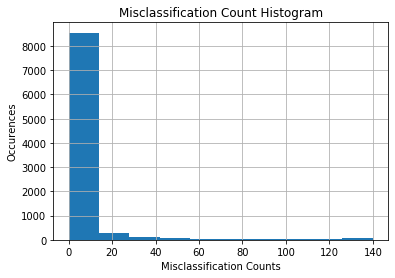

In [190]:
# Histogram
plt.title("Misclassification Count Histogram")
plt.grid()
plt.xlabel('Misclassification Counts')
plt.ylabel('Occurences')
plt.hist(misclass_counters)

In [254]:
bad_image_indexes = np.where(misclass_counters == np.max(misclass_counters))[0]
print(len(bad_image_indexes))

22


In [255]:
bad_image_indexes

array([1526, 2340, 2700, 3100, 3637, 5296, 6760, 7425, 7489, 7807, 8205,
       8261, 8284, 8285, 8337, 8395, 8819, 8835, 9104, 9105, 9155, 9255],
      dtype=int64)

In [260]:
n_bad_ims = len(bad_image_indexes)
fig, ax = plt.subplots(n_bad_ims, 1, figsize = (5,5 * n_bad_ims))
for i in range(n_bad_ims):
    bad_ind = bad_image_indexes[i]
    act_label = data_labels[bad_ind]
    image = data_samples[bad_ind].reshape(16,16)
    ax[i].set_title('True Label: '+ str(act_label))
    ax[i].imshow(image)

### Q1.5

As tried before, we try ranges of powers of 2. From before, tried that beyond 2^4 yields bad results; too fluctuatory because the kernel becomes too much like a pulse. Small values e.g. less than 2^-10 also don't work, because updates get closer to adding vector of ones (to verify again now). Thus we have upper and lower limits on the range to cross validate over

In [68]:
# Auxiliary Functions
def split_train_test_distances(data_samples, data_labels, train_prop, test_prop, seed = 88):
    """
    Split to 80% train and 20% test as required, randomly by first shuffling
    """
    n_tot = data_samples.shape[0]; n_train = round(train_prop * n_tot)
    
    np.random.seed(seed)
    permute = np.random.permutation(n_tot)
    
    data_shuffled = data_samples[permute,:]
    data_shuffled_labels = data_labels[permute]
    
    train_samples = data_shuffled[:n_train, :]; train_labels = data_shuffled_labels[:n_train]
    test_samples = data_shuffled[n_train:, :]; test_labels = data_shuffled_labels[n_train:]
    
    S = data_shuffled @ data_shuffled.T
    distances = np.diag(S).reshape(-1,1) + np.diag(S).reshape(1,-1) - 2 * S
    
    train_distances = distances[:n_train, :n_train]
    test_distances = distances[:n_train, n_train:]
    
    return train_samples, train_labels, test_samples, test_labels, train_distances, test_distances

def gaussian_kernel(train_dat, test_pt, c):
    """
    Computes the gaussian kernel for a given c
    """
    
    Sxx = np.sum(train_dat * train_dat, axis = 1).reshape(-1,1)
    Syy = np.sum(test_pt * test_pt, axis = 1).reshape(1,-1)
    Sxy = train_dat @ test_pt.T
    
    distances_train_test = Sxx + Syy - 2 * Sxy
    
    return np.exp(-c * distances_train_test)

From repeating the cell below, find reasonable values for gaussian kernel coefficient are 2^-5 to 2^-10 in steps of one in terms of power (multiples of 2). Increasing beyond 2^-5 = bad results. Decreasing beyond 2^-10, also bad results

In [126]:
# Initial experiments to find the valid c.
c_pow = -7
num_classes = 10; n_epochs = 20
train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = 8)

c = 2 ** float(c_pow)
mistake_counters = init_mistake_counters(train_samples, num_classes)
kernel_mat_train = gaussian_kernel(train_samples, train_samples, c)
kernel_mat_test = gaussian_kernel(train_samples, test_samples, c)
mistake_counters, train_rates, test_rates = train_nepochs_exp(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                                          , num_classes, kernel_mat_train, kernel_mat_test, n_epochs, False)

Epoch 0, made 0.08214573810164022 mistakes on training data and mistake rate of 0.03870967741935484 on test data
Epoch 1, made 0.015461145469212154 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 2, made 0.006856681903737564 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 3, made 0.00282333960742135 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 4, made 0.0016133369185264857 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 5, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 8, made 0.00026888948642108095 mistakes on training data and mistake rate o

In [127]:
# Plot results
plt.figure(figsize = (15,5))
plt.title('Training and Testing Error Rate vs Epochs')
plt.plot(1 + np.arange(n_epochs), train_rates, label = 'Training Error Rate')
plt.plot(1 + np.arange(n_epochs), test_rates, label = 'Test Error Rate')
plt.xlabel('Epochs')
plt.legend()
plt.xticks(1+np.arange(n_epochs, step = 1))
plt.ylabel('Error Rate')
plt.grid()

In [199]:
# Basic Run
# Basic results: Run 20 times and obtain average performance for all d
num_iter = 20
c_pow_range = np.arange(-10, -3, 1)
num_classes = 10; n_epochs = 20
c_results_train = np.zeros((len(c_pow_range), num_iter)); c_results_test = np.zeros((len(c_pow_range), num_iter))
start = time.time()
for it in range(num_iter):
    start_iter = time.time()
    print(f"Iteration {it+1}/{num_iter}")
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    for c_pow_ind in range(len(c_pow_range)):
        c_pow = c_pow_range[c_pow_ind]; c = 2 ** float(c_pow)
        print(f"c = c^{c_pow}")
        mistake_counters = init_mistake_counters(train_samples, num_classes)
        # Pre-compute outside for speed
        kernel_mat_train = gaussian_kernel(train_samples, train_samples, c)
        kernel_mat_test = gaussian_kernel(train_samples, test_samples, c)

        mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                                          , num_classes, kernel_mat_train, kernel_mat_test, n_epochs)
        
        c_results_train[c_pow_ind, it] = train_rate; c_results_test[c_pow_ind, it] = test_rate
        
    print(time.time() - start_iter)
print(time.time() - start)

Iteration 1/20
c = c^-10
Epoch 0, made 0.16899704221564937 mistakes on training data and mistake rate of 0.11720430107526882 on test data
Epoch 1, made 0.09384243076095725 mistakes on training data and mistake rate of 0.0956989247311828 on test data
Epoch 2, made 0.07999462221027158 mistakes on training data and mistake rate of 0.07204301075268817 on test data
Epoch 3, made 0.0684323742941651 mistakes on training data and mistake rate of 0.09193548387096774 on test data
Epoch 4, made 0.05727346060769024 mistakes on training data and mistake rate of 0.06397849462365592 on test data
Epoch 5, made 0.05471901048668997 mistakes on training data and mistake rate of 0.06075268817204301 on test data
Epoch 6, made 0.05418123151384781 mistakes on training data and mistake rate of 0.07365591397849462 on test data
Epoch 7, made 0.046517881150847 mistakes on training data and mistake rate of 0.08763440860215053 on test data
Epoch 8, made 0.042887873084162406 mistakes on training data and mistake ra

Epoch 5, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 6, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Early stopping at 7 epochs
c = c^-5
Epoch 0, made 0.07112126915837591 mistakes on training data and mistake rate of 0.041935483870967745 on test data
Epoch 1, made 0.00860446356547459 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 2, made 0.002285560634579188 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 3, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 5, made 0.0005377789728421619 mist

Epoch 10, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 11, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 12, made 0.002285560634579188 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Early stopping at 12 epochs
c = c^-7
Epoch 0, made 0.08550685668190373 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 1, made 0.014788921753159451 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 2, made 0.005108900242000538 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 3, made 0.00282333960742135 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 4, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 5, made 0.0017477816617370262 mistake

Epoch 12, made 0.010890024200053777 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 13, made 0.01156224791610648 mistakes on training data and mistake rate of 0.05967741935483871 on test data
Epoch 14, made 0.007797795106211347 mistakes on training data and mistake rate of 0.044623655913978495 on test data
Epoch 15, made 0.00887335305189567 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 16, made 0.00578112395805324 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 17, made 0.005915568701263781 mistakes on training data and mistake rate of 0.034408602150537634 on test data
Epoch 18, made 0.0038988975531056734 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 19, made 0.0038988975531056734 mistakes on training data and mistake rate of 0.03494623655913978 on test data
c = c^-8
Epoch 0, made 0.10769023931164291 mistakes on training data and mista

Epoch 14, made 0.030115622479161063 mistakes on training data and mistake rate of 0.054838709677419356 on test data
Epoch 15, made 0.02648561441247647 mistakes on training data and mistake rate of 0.04946236559139785 on test data
Epoch 16, made 0.02850228556063458 mistakes on training data and mistake rate of 0.05860215053763441 on test data
Epoch 17, made 0.02272116160258134 mistakes on training data and mistake rate of 0.05806451612903226 on test data
Epoch 18, made 0.0232589405754235 mistakes on training data and mistake rate of 0.0521505376344086 on test data
Epoch 19, made 0.02030115622479161 mistakes on training data and mistake rate of 0.08064516129032258 on test data
c = c^-9
Epoch 0, made 0.13242807206238236 mistakes on training data and mistake rate of 0.07849462365591398 on test data
Epoch 1, made 0.06668459263242807 mistakes on training data and mistake rate of 0.08440860215053764 on test data
Epoch 2, made 0.0528367840817424 mistakes on training data and mistake rate of 0.

Epoch 3, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.0478494623655914 on test data
Epoch 4, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.0478494623655914 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.0478494623655914 on test data
Epoch 6, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.0478494623655914 on test data
Early stopping at 6 epochs
71.49998068809509
Iteration 5/20
c = c^-10
Epoch 0, made 0.17733261629470287 mistakes on training data and mistake rate of 0.1817204301075269 on test data
Epoch 1, made 0.10580801290669535 mistakes on training data and mistake rate of 0.13655913978494624 on test data
Epoch 2, made 0.08496907770906158 mistakes on training data and mistake rate of 0.05053763440860215 on test data
Epoch 3, made 0.06937348749663888 mistakes on training data and mistake rate of 0.05806451612903226 on test data
Epoch 4, made 0.065

Epoch 8, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Epoch 9, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 10, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 11, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Early stopping at 11 epochs
c = c^-6
Epoch 0, made 0.06950793223984943 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 1, made 0.007125571390158645 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 2, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 3, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 4, made 0.00040333422963162143 

Epoch 1, made 0.03845119655821457 mistakes on training data and mistake rate of 0.054838709677419356 on test data
Epoch 2, made 0.023796719548265663 mistakes on training data and mistake rate of 0.04086021505376344 on test data
Epoch 3, made 0.015057811239580532 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 4, made 0.010217800484001076 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 5, made 0.00578112395805324 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 6, made 0.00578112395805324 mistakes on training data and mistake rate of 0.03870967741935484 on test data
Epoch 7, made 0.00282333960742135 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 8, made 0.003092229093842431 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 9, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.038709

Epoch 4, made 0.03253562785695079 mistakes on training data and mistake rate of 0.05268817204301075 on test data
Epoch 5, made 0.028233396074213497 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 6, made 0.024200053777897284 mistakes on training data and mistake rate of 0.041935483870967745 on test data
Epoch 7, made 0.02057004571121269 mistakes on training data and mistake rate of 0.0467741935483871 on test data
Epoch 8, made 0.014116698037106749 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 9, made 0.013713363807475128 mistakes on training data and mistake rate of 0.03978494623655914 on test data
Epoch 10, made 0.011024468943264318 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 11, made 0.010083355740790535 mistakes on training data and mistake rate of 0.03924731182795699 on test data
Epoch 12, made 0.010486689970422156 mistakes on training data and mistake rate of 0.038

Epoch 5, made 0.05485345522990051 mistakes on training data and mistake rate of 0.10376344086021505 on test data
Epoch 6, made 0.050416778703952676 mistakes on training data and mistake rate of 0.08709677419354839 on test data
Epoch 7, made 0.05162678139284754 mistakes on training data and mistake rate of 0.08118279569892473 on test data
Epoch 8, made 0.05203011562247916 mistakes on training data and mistake rate of 0.07096774193548387 on test data
Epoch 9, made 0.047593439096531326 mistakes on training data and mistake rate of 0.09247311827956989 on test data
Epoch 10, made 0.041812315138478086 mistakes on training data and mistake rate of 0.06075268817204301 on test data
Epoch 11, made 0.032132293627319175 mistakes on training data and mistake rate of 0.03978494623655914 on test data
Epoch 12, made 0.031056735681634848 mistakes on training data and mistake rate of 0.0489247311827957 on test data
Epoch 13, made 0.035090077977951065 mistakes on training data and mistake rate of 0.05107

Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.017741935483870968 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.021505376344086023 on test data
Epoch 6, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02204301075268817 on test data
Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.01881720430107527 on test data
Early stopping at 7 epochs
c = c^-5
Epoch 0, made 0.0691045980102178 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 1, made 0.009948910997579994 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 2, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 3, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 4, made 0.00026888948642108095 mista

Epoch 11, made 0.002016671148158107 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 12, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 13, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 14, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 15, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 16, made 0.0010755579456843238 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 17, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 18, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 19, made 0.00026888948642108095 mistakes on training data and

Epoch 9, made 0.01465447700994891 mistakes on training data and mistake rate of 0.06236559139784946 on test data
Epoch 10, made 0.012906695348211886 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 11, made 0.01142780317289594 mistakes on training data and mistake rate of 0.043548387096774194 on test data
Epoch 12, made 0.010217800484001076 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 13, made 0.009142242538316752 mistakes on training data and mistake rate of 0.05 on test data
Epoch 14, made 0.007663350363000807 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 15, made 0.0056466792148427 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 16, made 0.003764452809895133 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 17, made 0.003764452809895133 mistakes on training data and mistake rate of 0.034946236559

Epoch 6, made 0.05431567625705835 mistakes on training data and mistake rate of 0.06075268817204301 on test data
Epoch 7, made 0.05162678139284754 mistakes on training data and mistake rate of 0.09838709677419355 on test data
Epoch 8, made 0.04705566012368916 mistakes on training data and mistake rate of 0.0967741935483871 on test data
Epoch 9, made 0.04302231782737295 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 10, made 0.04140898090884646 mistakes on training data and mistake rate of 0.08064516129032258 on test data
Epoch 11, made 0.03683785963968809 mistakes on training data and mistake rate of 0.05 on test data
Epoch 12, made 0.033476741059424574 mistakes on training data and mistake rate of 0.06827956989247312 on test data
Epoch 13, made 0.03199784888410863 mistakes on training data and mistake rate of 0.07150537634408602 on test data
Epoch 14, made 0.027830061844581876 mistakes on training data and mistake rate of 0.04408602150537634 on te

Epoch 2, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 3, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Early stopping at 6 epochs
c = c^-4
Epoch 0, made 0.08859908577574617 mistakes on training data and mistake rate of 0.046236559139784944 on test data
Epoch 1, made 0.01452003226673837 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 2, made 0.0018822264049475664 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 3, made 0.00026888948642108095 mis

Epoch 3, made 0.0032266738370529714 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 4, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.025268817204301075 on test data
Epoch 5, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 6, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 7, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.02903225806451613 on test data
Epoch 8, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 9, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 10, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.026344086021505377 on test data
Epoch 11, made 0.00026888948642108095 mistakes on training data and mist

Epoch 2, made 0.022317827372949718 mistakes on training data and mistake rate of 0.04247311827956989 on test data
Epoch 3, made 0.012100026888948642 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 4, made 0.009142242538316752 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 5, made 0.007394460876579726 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.004840010755579457 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 7, made 0.0038988975531056734 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 8, made 0.002554450121000269 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 9, made 0.0021511158913686476 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 10, made 0.002285560634579188 mistakes on training data and mistake rate of 0.0

Epoch 0, made 0.1329658510352245 mistakes on training data and mistake rate of 0.06881720430107527 on test data
Epoch 1, made 0.0641301425114278 mistakes on training data and mistake rate of 0.06344086021505377 on test data
Epoch 2, made 0.04598010217800484 mistakes on training data and mistake rate of 0.06935483870967742 on test data
Epoch 3, made 0.04127453616563592 mistakes on training data and mistake rate of 0.06236559139784946 on test data
Epoch 4, made 0.03159451465447701 mistakes on training data and mistake rate of 0.07096774193548387 on test data
Epoch 5, made 0.02594783543963431 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 6, made 0.020838935197633773 mistakes on training data and mistake rate of 0.07258064516129033 on test data
Epoch 7, made 0.01707448238773864 mistakes on training data and mistake rate of 0.07419354838709677 on test data
Epoch 8, made 0.01438558752352783 mistakes on training data and mistake rate of 0.06182795698924

Epoch 3, made 0.07071793492874429 mistakes on training data and mistake rate of 0.08225806451612903 on test data
Epoch 4, made 0.06641570314600699 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 5, made 0.05982791072869051 mistakes on training data and mistake rate of 0.06666666666666667 on test data
Epoch 6, made 0.05418123151384781 mistakes on training data and mistake rate of 0.07150537634408602 on test data
Epoch 7, made 0.050416778703952676 mistakes on training data and mistake rate of 0.05698924731182796 on test data
Epoch 8, made 0.04221564936810971 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 9, made 0.046786770637268084 mistakes on training data and mistake rate of 0.05860215053763441 on test data
Epoch 10, made 0.0395267545038989 mistakes on training data and mistake rate of 0.07311827956989247 on test data
Epoch 11, made 0.038047862328582954 mistakes on training data and mistake rate of 0.0473118279

Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 7, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Early stopping at 7 epochs
c = c^-5
Epoch 0, made 0.07286905082011293 mistakes on training data and mistake rate of 0.03655913978494624 on test data
Epoch 1, made 0.009680021511158914 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 2, made 0.0029577843506318905 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 3, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 4, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.027419354838709678 on test data
Epoch 6, made 0.00013444474321054048 mis

Epoch 12, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 13, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 14, made 0.0006722237160527024 mistakes on training data and mistake rate of 0.02849462365591398 on test data
Epoch 15, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 16, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Early stopping at 16 epochs
c = c^-7
Epoch 0, made 0.08012906695348213 mistakes on training data and mistake rate of 0.05161290322580645 on test data
Epoch 1, made 0.01734337187415972 mistakes on training data and mistake rate of 0.04408602150537634 on test data
Epoch 2, made 0.006318902930895402 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 3, made 0.0036300080666845924 mist

Epoch 11, made 0.009948910997579994 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 12, made 0.006856681903737564 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 13, made 0.007932239849421888 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 14, made 0.00847001882226405 mistakes on training data and mistake rate of 0.03870967741935484 on test data
Epoch 15, made 0.006453347674105943 mistakes on training data and mistake rate of 0.046236559139784944 on test data
Epoch 16, made 0.006587792417316483 mistakes on training data and mistake rate of 0.04139784946236559 on test data
Epoch 17, made 0.00282333960742135 mistakes on training data and mistake rate of 0.04247311827956989 on test data
Epoch 18, made 0.0038988975531056734 mistakes on training data and mistake rate of 0.038172043010752686 on test data
Epoch 19, made 0.0034955633234740524 mistakes on training data and mistake rat

Epoch 10, made 0.03858564130142511 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 11, made 0.03737563861253025 mistakes on training data and mistake rate of 0.09462365591397849 on test data
Epoch 12, made 0.03495563323474052 mistakes on training data and mistake rate of 0.0543010752688172 on test data
Epoch 13, made 0.03199784888410863 mistakes on training data and mistake rate of 0.08387096774193549 on test data
Epoch 14, made 0.030518956708792688 mistakes on training data and mistake rate of 0.06451612903225806 on test data
Epoch 15, made 0.029174509276687282 mistakes on training data and mistake rate of 0.06827956989247312 on test data
Epoch 16, made 0.029712288249529442 mistakes on training data and mistake rate of 0.08172043010752689 on test data
Epoch 17, made 0.027157838128529174 mistakes on training data and mistake rate of 0.08064516129032258 on test data
Epoch 18, made 0.024065609034686745 mistakes on training data and mistake rate of 0.0

Epoch 0, made 0.08483463296585103 mistakes on training data and mistake rate of 0.053763440860215055 on test data
Epoch 1, made 0.01465447700994891 mistakes on training data and mistake rate of 0.04516129032258064 on test data
Epoch 2, made 0.002285560634579188 mistakes on training data and mistake rate of 0.04247311827956989 on test data
Epoch 3, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.041935483870967745 on test data
Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.04139784946236559 on test data
Epoch 5, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.041935483870967745 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.041935483870967745 on test data
Early stopping at 6 epochs
74.0914261341095
Iteration 19/20
c = c^-10
Epoch 0, made 0.17195482656628125 mistakes on training data and mistake rate of 0.10752688172043011 on test data
Epoch 1, made 0.1009680021511

Epoch 1, made 0.00860446356547459 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 2, made 0.0036300080666845924 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 3, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 5, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 7, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.023655913978494623 on test data
Early stopping at 7 epochs
c = c^-5
Epoch 0, made 0.06829792955095455 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 1, made 0.009007797795106211 mis

Epoch 7, made 0.0032266738370529714 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 8, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 9, made 0.0017477816617370262 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 10, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.03387096774193549 on test data
Epoch 11, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.04247311827956989 on test data
Epoch 12, made 0.0013444474321054048 mistakes on training data and mistake rate of 0.035483870967741936 on test data
Epoch 13, made 0.00040333422963162143 mistakes on training data and mistake rate of 0.03333333333333333 on test data
Epoch 14, made 0.0009411132024737832 mistakes on training data and mistake rate of 0.03064516129032258 on test data
Epoch 15, made 0.00040333422963162143 mistakes on training data and mist

In [201]:
# Prints
for c_pow_ind in range(len(c_pow_range)):
    print(f"For c = 2^{c_pow_range[c_pow_ind]}, mean train error is {means_train[c_pow_ind]} with a standard deviation of {stds_train[c_pow_ind]}")
    print(f"For c = 2^{c_pow_range[c_pow_ind]}, mean test error is {means_test[c_pow_ind]} with a standard deviation of {stds_test[c_pow_ind]}")

For c = 2^-10, mean train error is 0.029114009142242537 with a standard deviation of 0.01365772492790759
For c = 2^-10, mean test error is 0.059059139784946244 with a standard deviation of 0.014826700571345958
For c = 2^-9, mean train error is 0.00627856950793224 with a standard deviation of 0.006631424778726437
For c = 2^-9, mean test error is 0.03965053763440861 with a standard deviation of 0.008401344047315544
For c = 2^-8, mean train error is 0.0006184458187684862 with a standard deviation of 0.0004064591679976062
For c = 2^-8, mean test error is 0.030403225806451613 with a standard deviation of 0.004089115269060394
For c = 2^-7, mean train error is 0.0002487227749394998 with a standard deviation of 0.00011467277567378314
For c = 2^-7, mean test error is 0.025994623655913977 with a standard deviation of 0.004081332198811314
For c = 2^-6, mean train error is 0.0001680559290131756 with a standard deviation of 0.00010304994431806866
For c = 2^-6, mean test error is 0.02518817204301075

In [200]:
# Visualisation
means_train = np.mean(c_results_train, axis = 1); stds_train = np.std(c_results_train, axis = 1)
means_test = np.mean(c_results_test, axis = 1); stds_test = np.std(c_results_test, axis = 1)
plt.figure(figsize = (15,8))
plt.title('Mean error rate vs log2 c')
plt.errorbar(c_pow_range, means_train, yerr = stds_train, label = 'Train', elinewidth = 2.5, ecolor = 'r', color = 'c')
plt.errorbar(c_pow_range, means_test, yerr = stds_test, label = 'Test', elinewidth = 2.5, ecolor = 'b', color = 'orange')
plt.xlabel('Log2 of c')
plt.ylabel('Error rate')
plt.legend()
plt.grid()

In [144]:
# Loop 20 times
c_errors = []; best_cs = []; c_pow_range = np.arange(-10, -3, 1)
num_iter = 20
all_c_errors = np.zeros((len(c_pow_range), num_iter))
for it in range(num_iter):
    # Do 1 cross-validation, and then outer-loop it by 20 times
    start_val = time.time()
    n = 5; n_epochs = 20; num_classes = 10
    # Split for every run
    train_samples, train_labels, test_samples, test_labels, train_distances, test_distances = split_train_test_distances(data_samples, data_labels, 0.8, 0.2, seed = it)

    # Divide into sub-arrays
    x_train, y_train, sub_idxs = getSubArray(train_samples, train_labels.reshape(-1,1), n)

    # Convert to numpy arrays for ease of slicing
    x_train = np.array(x_train); y_train = np.array(y_train)

    # 1 5-fold cross validation starts here
    c_val_results = np.zeros((len(c_pow_range)))
    for pow_idx in range(len(c_pow_range)):
        power = c_pow_range[pow_idx]
        print(f"For c = c^{power}")
        c = 2 ** float(power)
        kernel_mat_train = np.exp(train_distances * -c)
        kernel_mat_idxs = np.arange(kernel_mat_train.shape[0])
        # Iterate through each validation sub-array, the rest become training
        val_indexes = np.arange(n); val_err = []

        for val_idx in val_indexes:
            # Get training sub-array indexes
            train_indexes = np.delete(val_indexes, val_idx)

            # Get validation fold index range
            val_range = np.arange(sub_idxs[val_idx][0], sub_idxs[val_idx][1])

            # Slice off the validation samples from the large kernel matrix, and get the train and val based on the folds
            train_kernel_mat = np.delete(kernel_mat_train, val_range, axis = 0)
            val_kernel_mat = train_kernel_mat[:,val_range]
            train_kernel_mat = np.delete(train_kernel_mat, val_range, axis = 1)

            # Take one fold as val, rest becomes training
            val_samples = x_train[val_idx]; val_labels = y_train[val_idx].reshape(-1)

            # Training set
            train_mini_samples = catSubArrays(x_train[train_indexes]); train_mini_labels = catSubArrays(y_train[train_indexes]).reshape(-1)

            # Train on training set for some epochs, and then test
            mistake_counters = init_mistake_counters(train_mini_samples, num_classes)
            mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_mini_samples, train_mini_labels, val_samples, val_labels, mistake_counters
                                                                                          , num_classes, train_kernel_mat, val_kernel_mat, n_epochs)


            # Append validation results
            val_err.append(test_rate); 

        # Store this c's results
        c_val_results[pow_idx] = np.mean(val_err); all_c_errors[pow_idx, it] = np.mean(val_err)

    # # Find best c, re-train on whole train_samples and obtain final test performance
    power_idx_star = np.argmin(c_val_results); power_star = c_pow_range[power_idx_star]; c_star = 2 ** float(power_star)
    print(f"For iteration {it+1}, best c is {c_star}")
    kernel_mat_test = np.exp(test_distances * -c_star)
    kernel_mat_train = np.exp(train_distances * -c_star)
    mistake_counters = init_mistake_counters(train_samples, num_classes)
    mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                                      ,num_classes, kernel_mat_train, kernel_mat_test, n_epochs)

    print(f"For c = {c_star}, retraining gives a final test error rate of {test_rate}")

    # Append result of this cross validation
    c_errors.append(test_rate); best_cs.append(c_star)
    
    print(f"Time for 1 cross validation across given c is {time.time() - start_val}")

For c = c^-10
Epoch 0, made 0.18652327339942867 mistakes on training data and mistake rate of 0.13584398117014124 on test data
Epoch 1, made 0.10502436565283145 mistakes on training data and mistake rate of 0.10490921318090114 on test data
Epoch 2, made 0.08485968744748781 mistakes on training data and mistake rate of 0.09145931405514458 on test data
Epoch 3, made 0.0670475550327676 mistakes on training data and mistake rate of 0.06321452589105582 on test data
Epoch 4, made 0.06284658040665435 mistakes on training data and mistake rate of 0.0941492938802959 on test data
Epoch 5, made 0.05797344984036296 mistakes on training data and mistake rate of 0.09616677874915938 on test data
Epoch 6, made 0.05074777348344816 mistakes on training data and mistake rate of 0.0773369199731002 on test data
Epoch 7, made 0.04570660393211225 mistakes on training data and mistake rate of 0.07666442501681238 on test data
Epoch 8, made 0.047050915812468494 mistakes on training data and mistake rate of 0.06

Epoch 12, made 0.043697478991596636 mistakes on training data and mistake rate of 0.06720430107526881 on test data
Epoch 13, made 0.03411764705882353 mistakes on training data and mistake rate of 0.06586021505376344 on test data
Epoch 14, made 0.03294117647058824 mistakes on training data and mistake rate of 0.08266129032258064 on test data
Epoch 15, made 0.031092436974789917 mistakes on training data and mistake rate of 0.06317204301075269 on test data
Epoch 16, made 0.02689075630252101 mistakes on training data and mistake rate of 0.07526881720430108 on test data
Epoch 17, made 0.028067226890756303 mistakes on training data and mistake rate of 0.06989247311827956 on test data
Epoch 18, made 0.024873949579831932 mistakes on training data and mistake rate of 0.0846774193548387 on test data
Epoch 19, made 0.019831932773109243 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 0, made 0.1830252100840336 mistakes on training data and mistake rate of 0.118

Epoch 5, made 0.027894471517392036 mistakes on training data and mistake rate of 0.08137188971082716 on test data
Epoch 6, made 0.02537388674172408 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 7, made 0.021677029070744414 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 8, made 0.01562762560914132 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 9, made 0.013611157788606956 mistakes on training data and mistake rate of 0.06590450571620712 on test data
Epoch 10, made 0.013947235758696018 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 11, made 0.014115274743740547 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Epoch 12, made 0.011762728953117123 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 13, made 0.01025037808771635 mistakes on training data and mistake rate of 0.0349

Epoch 0, made 0.10857142857142857 mistakes on training data and mistake rate of 0.08064516129032258 on test data
Epoch 1, made 0.041176470588235294 mistakes on training data and mistake rate of 0.10215053763440861 on test data
Epoch 2, made 0.022521008403361343 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 3, made 0.013781512605042017 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 4, made 0.008403361344537815 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 5, made 0.008571428571428572 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 6, made 0.004873949579831933 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 7, made 0.0036974789915966387 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 8, made 0.004369747899159664 mistakes on training data and mistake rate of 0.

Epoch 0, made 0.08620399932784406 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 1, made 0.016971937489497563 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 2, made 0.007057637371870274 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 3, made 0.003528818685935137 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 4, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 5, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 6, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 7, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 8, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.

Epoch 0, made 0.07074441270374728 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 1, made 0.0073937153419593345 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 2, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 3, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.026899798251513115 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.0242098184263618 on test data
Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.0242098184263618 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.02488231338264963 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07159663865546219 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 1, made 0.00907563025210084 mistakes on training data a

Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Early stopping at 7 epochs
Epoch 0, made 0.09897496219122837 mistakes on training data and mistake rate of 0.05043712172158709 on test data
Epoch 1, made 0.0149554696689632 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 2, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 3, made 0.0006721559401781214 mistakes on training

Epoch 15, made 0.027899159663865546 mistakes on training data and mistake rate of 0.05779569892473118 on test data
Epoch 16, made 0.02773109243697479 mistakes on training data and mistake rate of 0.061155913978494625 on test data
Epoch 17, made 0.027394957983193278 mistakes on training data and mistake rate of 0.08131720430107527 on test data
Early stopping at 17 epochs
Epoch 0, made 0.18870778020500756 mistakes on training data and mistake rate of 0.10558170813718896 on test data
Epoch 1, made 0.10569652159300957 mistakes on training data and mistake rate of 0.10759919300605246 on test data
Epoch 2, made 0.08116282977650816 mistakes on training data and mistake rate of 0.12037659717552118 on test data
Epoch 3, made 0.07410519240463788 mistakes on training data and mistake rate of 0.07531943510423672 on test data
Epoch 4, made 0.06906402285330196 mistakes on training data and mistake rate of 0.08742434431741762 on test data
Epoch 5, made 0.063686775331877 mistakes on training data and 

Epoch 9, made 0.01545958662409679 mistakes on training data and mistake rate of 0.0605245460659045 on test data
Epoch 10, made 0.01579566459418585 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 11, made 0.012266845908250714 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 12, made 0.012098806923206184 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 13, made 0.009410183162493698 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 14, made 0.01008233910267182 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 15, made 0.009578222147538229 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 16, made 0.007057637371870274 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 17, made 0.005713325491514031 mistakes on training data and mistake rate of 0.03

Epoch 1, made 0.07344537815126051 mistakes on training data and mistake rate of 0.06048387096774194 on test data
Epoch 2, made 0.05126050420168067 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 3, made 0.03966386554621849 mistakes on training data and mistake rate of 0.05510752688172043 on test data
Epoch 4, made 0.03361344537815126 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 5, made 0.027563025210084035 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 6, made 0.02453781512605042 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 7, made 0.02 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 8, made 0.014789915966386555 mistakes on training data and mistake rate of 0.06048387096774194 on test data
Epoch 9, made 0.01630252100840336 mistakes on training data and mistake rate of 0.04771505376344086 on test 

Epoch 6, made 0.004033613445378151 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 7, made 0.0031932773109243696 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 8, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 9, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 10, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 11, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 12, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 13, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 14, made 0.0005042016806722689 mistakes on training data and mistak

Epoch 2, made 0.00453781512605042 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 3, made 0.0031932773109243696 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 4, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 6, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 9, made 0.0 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 10, made 0.0 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 11, made 

Epoch 5, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Early stopping at 7 epochs
Epoch 0, made 0.08250714165686439 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 1, made 0.010754495042849942 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 2, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 3, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 4, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 5, made 0.000504116955133591 mistakes on training d

Epoch 7, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.01935483870967742 on test data
Early stopping at 7 epochs
For c = 0.015625, retraining gives a final test error rate of 0.01935483870967742
Time for 1 cross validation across given c is 217.1089267730713
For c = c^-10
Epoch 0, made 0.19206855990589816 mistakes on training data and mistake rate of 0.09818426361802286 on test data
Epoch 1, made 0.09981515711645102 mistakes on training data and mistake rate of 0.17215870880968392 on test data
Epoch 2, made 0.07914636195597378 mistakes on training data and mistake rate of 0.16745124411566914 on test data
Epoch 3, made 0.07914636195597378 mistakes on training data and mistake rate of 0.16408876933423 on test data
Epoch 4, made 0.06805578894303478 mistakes on training data and mistake rate of 0.18493611297915266 on test data
Epoch 5, made 0.05948580070576374 mistakes on training data and mistake rate of 0.2004034969737727 on test data
Epoch 6, made 0.0532683

Epoch 10, made 0.04201680672268908 mistakes on training data and mistake rate of 0.11021505376344086 on test data
Epoch 11, made 0.04151260504201681 mistakes on training data and mistake rate of 0.05040322580645161 on test data
Epoch 12, made 0.04151260504201681 mistakes on training data and mistake rate of 0.05981182795698925 on test data
Epoch 13, made 0.03394957983193277 mistakes on training data and mistake rate of 0.08400537634408602 on test data
Epoch 14, made 0.03546218487394958 mistakes on training data and mistake rate of 0.12432795698924731 on test data
Epoch 15, made 0.03394957983193277 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 16, made 0.028739495798319328 mistakes on training data and mistake rate of 0.08534946236559139 on test data
Epoch 17, made 0.029747899159663867 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 18, made 0.023529411764705882 mistakes on training data and mistake rate of 0.0

Epoch 2, made 0.05108385145353722 mistakes on training data and mistake rate of 0.10558170813718896 on test data
Epoch 3, made 0.04469837002184507 mistakes on training data and mistake rate of 0.09818426361802286 on test data
Epoch 4, made 0.03646445975466308 mistakes on training data and mistake rate of 0.0699394754539341 on test data
Epoch 5, made 0.028566627457570156 mistakes on training data and mistake rate of 0.06724949562878278 on test data
Epoch 6, made 0.022013107040833473 mistakes on training data and mistake rate of 0.09616677874915938 on test data
Epoch 7, made 0.022853301966056123 mistakes on training data and mistake rate of 0.11634162743779422 on test data
Epoch 8, made 0.016131742564274913 mistakes on training data and mistake rate of 0.07868190988567586 on test data
Epoch 9, made 0.013947235758696018 mistakes on training data and mistake rate of 0.06926698049764626 on test data
Epoch 10, made 0.011594689968072593 mistakes on training data and mistake rate of 0.05917955

Epoch 14, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 15, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 16, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 17, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 18, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Early stopping at 18 epochs
Epoch 0, made 0.1146218487394958 mistakes on training data and mistake rate of 0.06922043010752688 on test data
Epoch 1, made 0.041008403361344536 mistakes on training data and mistake rate of 0.09879032258064516 on test data
Epoch 2, made 0.02453781512605042 mistakes on training data and mistake rate of 0.05779569892473118 on test data
Epoch 3, made 0.01546218487394958 mistakes on tra

Epoch 3, made 0.0033607797008906068 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 4, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 5, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 6, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.026899798251513115 on test data
Epoch 8, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 9, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 10, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Early stopping at 10 epochs
Epoch 0, made 0.09092436974789916 mistakes on tra

Epoch 6, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07647058823529412 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 1, made 0.008739495798319327 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 2, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 7, made 0.0005042016806722689 mistakes on trai

Epoch 3, made 0.000504116955133591 mistakes on training data and mistake rate of 0.05514458641560188 on test data
Epoch 4, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.05245460659045057 on test data
Early stopping at 6 epochs
Epoch 0, made 0.09815126050420168 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 1, made 0.017983193277310926 mistakes on training data and mistake rate of 0.06451612903225806 on test data
Epoch 2, made 0.002689075630252101 mistakes on training data and mistake rate of 0.05577956989247312 on test data
Epoch 3, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.05174731182795699 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training dat

Epoch 4, made 0.0648630482271887 mistakes on training data and mistake rate of 0.05985205110961668 on test data
Epoch 5, made 0.05578894303478407 mistakes on training data and mistake rate of 0.05447209145931405 on test data
Epoch 6, made 0.054444631154427825 mistakes on training data and mistake rate of 0.0605245460659045 on test data
Epoch 7, made 0.047891110737691145 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 8, made 0.047386993782557556 mistakes on training data and mistake rate of 0.05648957632817754 on test data
Epoch 9, made 0.04284994118635523 mistakes on training data and mistake rate of 0.05985205110961668 on test data
Epoch 10, made 0.04083347336582087 mistakes on training data and mistake rate of 0.06388702084734364 on test data
Epoch 11, made 0.03612838178457402 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 12, made 0.03512014787430684 mistakes on training data and mistake rate of 0.049092131809

Epoch 17, made 0.005881364476558562 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 18, made 0.004032935641068728 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 19, made 0.004032935641068728 mistakes on training data and mistake rate of 0.0652320107599193 on test data
Epoch 0, made 0.14487394957983193 mistakes on training data and mistake rate of 0.1303763440860215 on test data
Epoch 1, made 0.07428571428571429 mistakes on training data and mistake rate of 0.06720430107526881 on test data
Epoch 2, made 0.0546218487394958 mistakes on training data and mistake rate of 0.06518817204301075 on test data
Epoch 3, made 0.04285714285714286 mistakes on training data and mistake rate of 0.06854838709677419 on test data
Epoch 4, made 0.033781512605042016 mistakes on training data and mistake rate of 0.053763440860215055 on test data
Epoch 5, made 0.02857142857142857 mistakes on training data and mistake rate of 0.055107526

Epoch 9, made 0.015126050420168067 mistakes on training data and mistake rate of 0.09879032258064516 on test data
Epoch 10, made 0.013949579831932773 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 11, made 0.012941176470588235 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 12, made 0.010588235294117647 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 13, made 0.008907563025210084 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 14, made 0.00823529411764706 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 15, made 0.007563025210084034 mistakes on training data and mistake rate of 0.053763440860215055 on test data
Epoch 16, made 0.005546218487394958 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 17, made 0.0036974789915966387 mistakes on training data and mistake rate 

Epoch 6, made 0.005210084033613446 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 7, made 0.004705882352941176 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 8, made 0.002352941176470588 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 9, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 10, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 11, made 0.001176470588235294 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 12, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 13, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 14, made 0.0006722689075630252 mistakes on training data and mistake r

Epoch 13, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Early stopping at 13 epochs
Epoch 0, made 0.08789915966386555 mistakes on training data and mistake rate of 0.05779569892473118 on test data
Epoch 1, made 0.01764705882352941 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 2, made 0.007394957983193277 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 3, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 4, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 5, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 7, made 0.0005042016806722689 mistakes on tr

Epoch 3, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.02488231338264963 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.02488231338264963 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.02488231338264963 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.02488231338264963 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.02488231338264963 on test data
Early stopping at 8 epochs
Epoch 0, made 0.073109243697479 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 1, made 0.011260504201680671 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 2, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 3, made 

Epoch 2, made 0.08771635019324484 mistakes on training data and mistake rate of 0.0652320107599193 on test data
Epoch 3, made 0.07712989413543943 mistakes on training data and mistake rate of 0.08742434431741762 on test data
Epoch 4, made 0.06855990589816838 mistakes on training data and mistake rate of 0.07935440484196368 on test data
Epoch 5, made 0.0687279448832129 mistakes on training data and mistake rate of 0.05648957632817754 on test data
Epoch 6, made 0.05410855318433876 mistakes on training data and mistake rate of 0.0652320107599193 on test data
Epoch 7, made 0.05057973449840363 mistakes on training data and mistake rate of 0.07800941492938802 on test data
Epoch 8, made 0.050075617543270036 mistakes on training data and mistake rate of 0.08338937457969066 on test data
Epoch 9, made 0.04503444799193413 mistakes on training data and mistake rate of 0.08809683927370544 on test data
Epoch 10, made 0.03999327844059822 mistakes on training data and mistake rate of 0.089441829186281

Epoch 15, made 0.02957983193277311 mistakes on training data and mistake rate of 0.09879032258064516 on test data
Epoch 16, made 0.0334453781512605 mistakes on training data and mistake rate of 0.07594086021505377 on test data
Epoch 17, made 0.02957983193277311 mistakes on training data and mistake rate of 0.05981182795698925 on test data
Epoch 18, made 0.02588235294117647 mistakes on training data and mistake rate of 0.05174731182795699 on test data
Epoch 19, made 0.023865546218487396 mistakes on training data and mistake rate of 0.06989247311827956 on test data
Epoch 0, made 0.18924369747899158 mistakes on training data and mistake rate of 0.0793010752688172 on test data
Epoch 1, made 0.10487394957983193 mistakes on training data and mistake rate of 0.08266129032258064 on test data
Epoch 2, made 0.0838655462184874 mistakes on training data and mistake rate of 0.08266129032258064 on test data
Epoch 3, made 0.073109243697479 mistakes on training data and mistake rate of 0.0759408602150

Epoch 7, made 0.023021340951100654 mistakes on training data and mistake rate of 0.05850706119704102 on test data
Epoch 8, made 0.017476054444631156 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 9, made 0.016971937489497563 mistakes on training data and mistake rate of 0.05110961667787491 on test data
Epoch 10, made 0.014787430683918669 mistakes on training data and mistake rate of 0.05379959650302623 on test data
Epoch 11, made 0.012266845908250714 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Epoch 12, made 0.011090573012939002 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 13, made 0.0067215594017812135 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 14, made 0.01008233910267182 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Epoch 15, made 0.007897832297092925 mistakes on training data and mistake rate of 0.

Epoch 4, made 0.008067226890756302 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 5, made 0.0067226890756302525 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.006050420168067227 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 7, made 0.004705882352941176 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 8, made 0.0031932773109243696 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 9, made 0.0025210084033613447 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 10, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 11, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 12, made 0.0006722689075630252 mistakes on training data and mistake ra

Epoch 5, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 6, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 7, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 8, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Early stopping at 8 epochs
Epoch 0, made 0.09193277310924369 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 1, made 0.018487394957983194 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 2, made 0.006050420168067227 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 3, made 0.004369747899159664 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 4, made 0.0010084033613445378 mistakes on traini

Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 8, made 0.0 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07747899159663865 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 1, made 0.00773109243697479 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 2, made 0.002689075630252101 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 3, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.023521505376344086 on test data
Epoch 5, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.024193548387096774 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.0235215

Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Early stopping at 7 epochs
Epoch 0, made 0.09309359771466981 mistakes on training data and mistake rate of 0.05783456624075319 on test data
Epoch 1, made 0.014619391698874138 mistakes on training data and mistake rate of 0.05581708137188971 on test data
Epoch 2, made 0.00487313056629138 mistakes on training data and mistake rate of 0.05110961667787491 on test data
Epoch 3, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 4, made 0.0 mistakes on training data and mistake ra

Epoch 12, made 0.04134453781512605 mistakes on training data and mistake rate of 0.07728494623655914 on test data
Epoch 13, made 0.03529411764705882 mistakes on training data and mistake rate of 0.07526881720430108 on test data
Epoch 14, made 0.033781512605042016 mistakes on training data and mistake rate of 0.06384408602150538 on test data
Epoch 15, made 0.03882352941176471 mistakes on training data and mistake rate of 0.06451612903225806 on test data
Epoch 16, made 0.03294117647058824 mistakes on training data and mistake rate of 0.06518817204301075 on test data
Epoch 17, made 0.025714285714285714 mistakes on training data and mistake rate of 0.06653225806451613 on test data
Epoch 18, made 0.023025210084033614 mistakes on training data and mistake rate of 0.07661290322580645 on test data
Epoch 19, made 0.0226890756302521 mistakes on training data and mistake rate of 0.06854838709677419 on test data
Epoch 0, made 0.19139640396572005 mistakes on training data and mistake rate of 0.0874

Epoch 5, made 0.028734666442614687 mistakes on training data and mistake rate of 0.05447209145931405 on test data
Epoch 6, made 0.023189379936145185 mistakes on training data and mistake rate of 0.07531943510423672 on test data
Epoch 7, made 0.020668795160477232 mistakes on training data and mistake rate of 0.07599193006052454 on test data
Epoch 8, made 0.017644093429675684 mistakes on training data and mistake rate of 0.0726294552790854 on test data
Epoch 9, made 0.01646782053436397 mistakes on training data and mistake rate of 0.0531271015467384 on test data
Epoch 10, made 0.013779196773651487 mistakes on training data and mistake rate of 0.05581708137188971 on test data
Epoch 11, made 0.012602923878339774 mistakes on training data and mistake rate of 0.04976462676529926 on test data
Epoch 12, made 0.008906066207360107 mistakes on training data and mistake rate of 0.05850706119704102 on test data
Epoch 13, made 0.00974626113258276 mistakes on training data and mistake rate of 0.07397

Epoch 17, made 0.005378151260504202 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 18, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 19, made 0.002689075630252101 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 0, made 0.13983193277310924 mistakes on training data and mistake rate of 0.10147849462365591 on test data
Epoch 1, made 0.07277310924369748 mistakes on training data and mistake rate of 0.0678763440860215 on test data
Epoch 2, made 0.05260504201680672 mistakes on training data and mistake rate of 0.056451612903225805 on test data
Epoch 3, made 0.04218487394957983 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 4, made 0.03932773109243697 mistakes on training data and mistake rate of 0.05577956989247312 on test data
Epoch 5, made 0.02823529411764706 mistakes on training data and mistake rate of 0.05443

Epoch 15, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Early stopping at 15 epochs
Epoch 0, made 0.11495798319327731 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 1, made 0.04336134453781513 mistakes on training data and mistake rate of 0.0625 on test data
Epoch 2, made 0.02319327731092437 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 3, made 0.01764705882352941 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 4, made 0.010084033613445379 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 5, made 0.0067226890756302525 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 6, made 0.005210084033613446 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 7, made 0.004033613445378151 mistakes on training data and mistak

Epoch 0, made 0.08991596638655462 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 1, made 0.017478991596638654 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 2, made 0.005714285714285714 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 3, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 4, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 5, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 6, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 8, made 0.0006722689075630252 mistakes on training data and mistake rate o

Epoch 3, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 4, made 0.0 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Early stopping at 5 epochs
Epoch 0, made 0.07680672268907562 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 1, made 0.00957983193277311 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 2, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 3, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.0336

Epoch 15, made 0.033103680053772476 mistakes on training data and mistake rate of 0.06590450571620712 on test data
Epoch 16, made 0.026550159637035792 mistakes on training data and mistake rate of 0.08069939475453934 on test data
Epoch 17, made 0.0260460426819022 mistakes on training data and mistake rate of 0.07128446536650974 on test data
Epoch 18, made 0.025037808771635018 mistakes on training data and mistake rate of 0.07464694014794888 on test data
Epoch 19, made 0.023525457906234247 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 0, made 0.18319327731092436 mistakes on training data and mistake rate of 0.11223118279569892 on test data
Epoch 1, made 0.09512605042016807 mistakes on training data and mistake rate of 0.07997311827956989 on test data
Epoch 2, made 0.08302521008403362 mistakes on training data and mistake rate of 0.07325268817204302 on test data
Epoch 3, made 0.07176470588235294 mistakes on training data and mistake rate of 0.064516

Epoch 8, made 0.04638655462184874 mistakes on training data and mistake rate of 0.07123655913978495 on test data
Epoch 9, made 0.03865546218487395 mistakes on training data and mistake rate of 0.11155913978494623 on test data
Epoch 10, made 0.03563025210084034 mistakes on training data and mistake rate of 0.11693548387096774 on test data
Epoch 11, made 0.03764705882352941 mistakes on training data and mistake rate of 0.07661290322580645 on test data
Epoch 12, made 0.035126050420168066 mistakes on training data and mistake rate of 0.07056451612903226 on test data
Epoch 13, made 0.03680672268907563 mistakes on training data and mistake rate of 0.05913978494623656 on test data
Epoch 14, made 0.030756302521008402 mistakes on training data and mistake rate of 0.08870967741935484 on test data
Epoch 15, made 0.02773109243697479 mistakes on training data and mistake rate of 0.09341397849462366 on test data
Epoch 16, made 0.025210084033613446 mistakes on training data and mistake rate of 0.0920

Epoch 0, made 0.14588235294117646 mistakes on training data and mistake rate of 0.06922043010752688 on test data
Epoch 1, made 0.06941176470588235 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 2, made 0.05008403361344538 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 3, made 0.04050420168067227 mistakes on training data and mistake rate of 0.056451612903225805 on test data
Epoch 4, made 0.034453781512605045 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 5, made 0.029243697478991595 mistakes on training data and mistake rate of 0.05040322580645161 on test data
Epoch 6, made 0.02403361344537815 mistakes on training data and mistake rate of 0.06989247311827956 on test data
Epoch 7, made 0.021680672268907564 mistakes on training data and mistake rate of 0.06451612903225806 on test data
Epoch 8, made 0.016638655462184872 mistakes on training data and mistake rate of 0.05376344

Epoch 0, made 0.10922534027894472 mistakes on training data and mistake rate of 0.08406186953597848 on test data
Epoch 1, made 0.039321122500420094 mistakes on training data and mistake rate of 0.05043712172158709 on test data
Epoch 2, made 0.0205007561754327 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 3, made 0.014283313728785078 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 4, made 0.008233910267181985 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 5, made 0.008906066207360107 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Epoch 6, made 0.00520920853638044 mistakes on training data and mistake rate of 0.04371217215870881 on test data
Epoch 7, made 0.003024701730801546 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 8, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.036314727

Epoch 3, made 0.0028566627457570154 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 4, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 5, made 0.001008233910267182 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 7, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 8, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.02757229320780094 on test data
Epoch 9, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Early stopping at 9 epochs
Epoch 0, made 0.08252100840336135 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 1, made 0.015126050420168067 mistakes on training 

Epoch 0, made 0.08133086876155268 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 1, made 0.009578222147538229 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 2, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 3, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 6, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07899159663865546 mistakes on training da

Epoch 2, made 0.003865546218487395 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 3, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Early stopping at 6 epochs
For iteration 7, best c is 0.015625
Epoch 0, made 0.06614681365958591 mistakes on training data and mistake rate of 0.03602150537634408 on test data
Epoch 1, made 0.00887335305189567 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 2, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 3, made 0.000

Epoch 16, made 0.02554192572676861 mistakes on training data and mistake rate of 0.06590450571620712 on test data
Epoch 17, made 0.024197613846412367 mistakes on training data and mistake rate of 0.0941492938802959 on test data
Epoch 18, made 0.021508990085699883 mistakes on training data and mistake rate of 0.06119704102219233 on test data
Epoch 19, made 0.017644093429675684 mistakes on training data and mistake rate of 0.08002689979825152 on test data
Epoch 0, made 0.18756302521008403 mistakes on training data and mistake rate of 0.16532258064516128 on test data
Epoch 1, made 0.10823529411764705 mistakes on training data and mistake rate of 0.13911290322580644 on test data
Epoch 2, made 0.08756302521008404 mistakes on training data and mistake rate of 0.11290322580645161 on test data
Epoch 3, made 0.08100840336134454 mistakes on training data and mistake rate of 0.11088709677419355 on test data
Epoch 4, made 0.06739495798319328 mistakes on training data and mistake rate of 0.08467741

Epoch 8, made 0.01815126050420168 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 9, made 0.014453781512605042 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 10, made 0.010588235294117647 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 11, made 0.010756302521008404 mistakes on training data and mistake rate of 0.05309139784946237 on test data
Epoch 12, made 0.009747899159663866 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 13, made 0.007394957983193277 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 14, made 0.007226890756302521 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 15, made 0.004201680672268907 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 16, made 0.00823529411764706 mistakes on training data and mistake rate of 

Epoch 0, made 0.12048395227692825 mistakes on training data and mistake rate of 0.05917955615332885 on test data
Epoch 1, made 0.04049739539573181 mistakes on training data and mistake rate of 0.06186953597848016 on test data
Epoch 2, made 0.024029574861367836 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 3, made 0.014451352713829609 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 4, made 0.009074105192404638 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 5, made 0.008569988237271047 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 6, made 0.00504116955133591 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 7, made 0.004705091581246849 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 8, made 0.0036968576709796672 mistakes on training data and mistake rate of 0.0336247

Epoch 9, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 10, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 11, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 12, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 13, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 14, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 15, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 16, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Early stopping at 16 epochs
For c = c^-7
Epoch 0, made 0.090741051924

Epoch 2, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 3, made 0.001176470588235294 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 5, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Early stopping at 7 epochs
Epoch 0, made 0.0742732313896824 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 1, made 0.0073937153419593345 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 2, made 0.002016467820534364 mistakes on trainin

Epoch 4, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 5, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 6, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 8, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Early stopping at 8 epochs
Epoch 0, made 0.0976470588235294 mistakes on training data and mistake rate of 0.05510752688172043 on test data
Epoch 1, made 0.01495798319327731 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 2, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 3, made 0.0010084033613445378 mistakes on traini

Epoch 5, made 0.06621848739495799 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 6, made 0.05848739495798319 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 7, made 0.056134453781512605 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 8, made 0.05680672268907563 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 9, made 0.04773109243697479 mistakes on training data and mistake rate of 0.0625 on test data
Epoch 10, made 0.043697478991596636 mistakes on training data and mistake rate of 0.06384408602150538 on test data
Epoch 11, made 0.04201680672268908 mistakes on training data and mistake rate of 0.06989247311827956 on test data
Epoch 12, made 0.03747899159663866 mistakes on training data and mistake rate of 0.06317204301075269 on test data
Epoch 13, made 0.033277310924369745 mistakes on training data and mistake rate of 0.08333333333333333

Epoch 18, made 0.022857142857142857 mistakes on training data and mistake rate of 0.06518817204301075 on test data
Epoch 19, made 0.025714285714285714 mistakes on training data and mistake rate of 0.05846774193548387 on test data
For c = c^-9
Epoch 0, made 0.15190724248025542 mistakes on training data and mistake rate of 0.06388702084734364 on test data
Epoch 1, made 0.07628969921021678 mistakes on training data and mistake rate of 0.05379959650302623 on test data
Epoch 2, made 0.055284826079650476 mistakes on training data and mistake rate of 0.05110961667787491 on test data
Epoch 3, made 0.04385817509662242 mistakes on training data and mistake rate of 0.06186953597848016 on test data
Epoch 4, made 0.031423290203327174 mistakes on training data and mistake rate of 0.05379959650302623 on test data
Epoch 5, made 0.027390354562258443 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Epoch 6, made 0.0205007561754327 mistakes on training data and mistake rate 

Epoch 10, made 0.012773109243697478 mistakes on training data and mistake rate of 0.05443548387096774 on test data
Epoch 11, made 0.010420168067226891 mistakes on training data and mistake rate of 0.05443548387096774 on test data
Epoch 12, made 0.008907563025210084 mistakes on training data and mistake rate of 0.056451612903225805 on test data
Epoch 13, made 0.009747899159663866 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 14, made 0.008739495798319327 mistakes on training data and mistake rate of 0.0625 on test data
Epoch 15, made 0.006890756302521009 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 16, made 0.004705882352941176 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 17, made 0.004705882352941176 mistakes on training data and mistake rate of 0.05981182795698925 on test data
Epoch 18, made 0.00453781512605042 mistakes on training data and mistake rate of 0.0470430

Epoch 6, made 0.00504116955133591 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 7, made 0.004200974626113258 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 8, made 0.0023525457906234245 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 9, made 0.002520584775667955 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 10, made 0.001512350865400773 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 11, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 12, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 13, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 14, made 0.0008401949252226517 mistakes on training data and mistake rate of

Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 6, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 7, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 8, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.026899798251513115 on test data
Early stopping at 8 epochs
Epoch 0, made 0.08991596638655462 mistakes on training data and mistake rate of 0.06854838709677419 on test data
Epoch 1, made 0.01781512605042017 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 2, made 0.006050420168067227 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 3, made 0.0031932773109243696 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 4, made 0.0018487394957983194 mistakes on training

Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 7, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Early stopping at 7 epochs
Epoch 0, made 0.08050420168067227 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 1, made 0.011596638655462186 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 2, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 3, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.0228494623655914 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.0228494623655914 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training 

Epoch 3, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.023118279569892472 on test data
Epoch 4, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02258064516129032 on test data
Epoch 5, made 0.00013444474321054048 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.024731182795698924 on test data
Early stopping at 6 epochs
For c = 0.015625, retraining gives a final test error rate of 0.024731182795698924
Time for 1 cross validation across given c is 213.49532318115234
For c = c^-10
Epoch 0, made 0.19122836498067552 mistakes on training data and mistake rate of 0.14660390047074648 on test data
Epoch 1, made 0.10502436565283145 mistakes on training data and mistake rate of 0.10490921318090114 on test data
Epoch 2, made 0.08385145353722064 mistakes on training data and mistake rate of 0.11701412239408204 on test data
Epoch 

Epoch 7, made 0.05042016806722689 mistakes on training data and mistake rate of 0.06048387096774194 on test data
Epoch 8, made 0.040336134453781515 mistakes on training data and mistake rate of 0.05241935483870968 on test data
Epoch 9, made 0.03966386554621849 mistakes on training data and mistake rate of 0.056451612903225805 on test data
Epoch 10, made 0.047563025210084035 mistakes on training data and mistake rate of 0.06317204301075269 on test data
Epoch 11, made 0.04184873949579832 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 12, made 0.035126050420168066 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 13, made 0.03294117647058824 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 14, made 0.031932773109243695 mistakes on training data and mistake rate of 0.06384408602150538 on test data
Epoch 15, made 0.029411764705882353 mistakes on training data and mistake rate of 0.

Epoch 19, made 0.005210084033613446 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 0, made 0.14501764409342968 mistakes on training data and mistake rate of 0.15736381977135172 on test data
Epoch 1, made 0.07628969921021678 mistakes on training data and mistake rate of 0.09213180901143242 on test data
Epoch 2, made 0.05125189043858175 mistakes on training data and mistake rate of 0.06321452589105582 on test data
Epoch 3, made 0.04369013611157788 mistakes on training data and mistake rate of 0.05447209145931405 on test data
Epoch 4, made 0.03864896656024198 mistakes on training data and mistake rate of 0.05245460659045057 on test data
Epoch 5, made 0.02974290035288187 mistakes on training data and mistake rate of 0.06321452589105582 on test data
Epoch 6, made 0.022517223995967065 mistakes on training data and mistake rate of 0.05447209145931405 on test data
Epoch 7, made 0.01999663922029911 mistakes on training data and mistake rate of 0.03967720242

Epoch 11, made 0.001008233910267182 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 12, made 0.001512350865400773 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 13, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 14, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 15, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 16, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Early stopping at 16 epochs
Epoch 0, made 0.11378151260504202 mistakes on training data and mistake rate of 0.07661290322580645 on test data
Epoch 1, made 0.04067226890756302 mistakes on training data and mistake rate of 0.05309139784946237 on test data
Epoch 2, made 0.02235294117647059 mistakes on training

Epoch 2, made 0.0067215594017812135 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 3, made 0.002520584775667955 mistakes on training data and mistake rate of 0.04236718224613315 on test data
Epoch 4, made 0.0031927407158460763 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 5, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 6, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 7, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 8, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 9, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 10, made 0.0003360779700890607 mistakes on training data and mistake rate of

Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07578558225508318 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 1, made 0.0068895983868257436 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 2, made 0.001512350865400773 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 3, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 4, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.026227303295225286 on test data
Epoch 5, made 0.0008401949252226517 mistakes on traini

Epoch 1, made 0.017142857142857144 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 2, made 0.002352941176470588 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 4, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 8, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Early stopping at 8 epochs
Epoch 0, made 0.09578222147538229 mistakes on training

Epoch 12, made 0.03882352941176471 mistakes on training data and mistake rate of 0.06586021505376344 on test data
Epoch 13, made 0.03478991596638655 mistakes on training data and mistake rate of 0.08669354838709678 on test data
Epoch 14, made 0.028067226890756303 mistakes on training data and mistake rate of 0.06922043010752688 on test data
Epoch 15, made 0.030756302521008402 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 16, made 0.027058823529411764 mistakes on training data and mistake rate of 0.09543010752688172 on test data
Epoch 17, made 0.023361344537815125 mistakes on training data and mistake rate of 0.0625 on test data
Epoch 18, made 0.0226890756302521 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 19, made 0.02369747899159664 mistakes on training data and mistake rate of 0.0678763440860215 on test data
Epoch 0, made 0.1977818853974122 mistakes on training data and mistake rate of 0.08675184936112978 

Epoch 5, made 0.028062510502436567 mistakes on training data and mistake rate of 0.04976462676529926 on test data
Epoch 6, made 0.0205007561754327 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 7, made 0.01545958662409679 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 8, made 0.011762728953117123 mistakes on training data and mistake rate of 0.0531271015467384 on test data
Epoch 9, made 0.01529154763905226 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 10, made 0.009578222147538229 mistakes on training data and mistake rate of 0.0531271015467384 on test data
Epoch 11, made 0.009242144177449169 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 12, made 0.008906066207360107 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 13, made 0.009242144177449169 mistakes on training data and mistake rate of 0.04371217

Epoch 17, made 0.004033613445378151 mistakes on training data and mistake rate of 0.06048387096774194 on test data
Epoch 18, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 19, made 0.004033613445378151 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 0, made 0.1519327731092437 mistakes on training data and mistake rate of 0.11693548387096774 on test data
Epoch 1, made 0.07226890756302522 mistakes on training data and mistake rate of 0.11895161290322581 on test data
Epoch 2, made 0.05546218487394958 mistakes on training data and mistake rate of 0.05174731182795699 on test data
Epoch 3, made 0.04134453781512605 mistakes on training data and mistake rate of 0.08803763440860216 on test data
Epoch 4, made 0.03798319327731092 mistakes on training data and mistake rate of 0.10080645161290322 on test data
Epoch 5, made 0.02722689075630252 mistakes on training data and mistake rate of 0.047715

Epoch 2, made 0.02235294117647059 mistakes on training data and mistake rate of 0.05443548387096774 on test data
Epoch 3, made 0.01630252100840336 mistakes on training data and mistake rate of 0.05510752688172043 on test data
Epoch 4, made 0.012773109243697478 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 5, made 0.006050420168067227 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 6, made 0.00453781512605042 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 7, made 0.004033613445378151 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 8, made 0.002352941176470588 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 9, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 10, made 0.002352941176470588 mistakes on training data and mistake rate of 0.03494

Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 9, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 10, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Early stopping at 10 epochs
Epoch 0, made 0.09210084033613446 mistakes on training data and mistake rate of 0.07526881720430108 on test data
Epoch 1, made 0.017478991596638654 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 2, made 0.007563025210084034 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 3, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 4, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 5, made 0.0016806722689075631 mistakes on traini

Epoch 3, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 4, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 5, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07983193277310924 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 1, made 0.010252100840336134 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 2, made 0.001176470588235294 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 4, made 0.0001680672268907563 mistakes on trainin

Epoch 6, made 0.05125189043858175 mistakes on training data and mistake rate of 0.05985205110961668 on test data
Epoch 7, made 0.04957150058813645 mistakes on training data and mistake rate of 0.05917955615332885 on test data
Epoch 8, made 0.04688287682742396 mistakes on training data and mistake rate of 0.0605245460659045 on test data
Epoch 9, made 0.043186019156444294 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 10, made 0.038312888590152916 mistakes on training data and mistake rate of 0.0894418291862811 on test data
Epoch 11, made 0.03780877163501933 mistakes on training data and mistake rate of 0.07800941492938802 on test data
Epoch 12, made 0.0410015123508654 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 13, made 0.033103680053772476 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 14, made 0.028902705427659218 mistakes on training data and mistake rate of 0.067249495

Epoch 19, made 0.021176470588235293 mistakes on training data and mistake rate of 0.0625 on test data
Epoch 0, made 0.18470588235294116 mistakes on training data and mistake rate of 0.10954301075268817 on test data
Epoch 1, made 0.0957983193277311 mistakes on training data and mistake rate of 0.0793010752688172 on test data
Epoch 2, made 0.08084033613445378 mistakes on training data and mistake rate of 0.08266129032258064 on test data
Epoch 3, made 0.07243697478991597 mistakes on training data and mistake rate of 0.1028225806451613 on test data
Epoch 4, made 0.06621848739495799 mistakes on training data and mistake rate of 0.05577956989247312 on test data
Epoch 5, made 0.05848739495798319 mistakes on training data and mistake rate of 0.09879032258064516 on test data
Epoch 6, made 0.05579831932773109 mistakes on training data and mistake rate of 0.08131720430107527 on test data
Epoch 7, made 0.05394957983193277 mistakes on training data and mistake rate of 0.06384408602150538 on test da

Epoch 11, made 0.00974626113258276 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 12, made 0.0073937153419593345 mistakes on training data and mistake rate of 0.04371217215870881 on test data
Epoch 13, made 0.008569988237271047 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 14, made 0.0073937153419593345 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 15, made 0.006049403461603092 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 16, made 0.006217442446647623 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 17, made 0.0038648966560241977 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 18, made 0.0036968576709796672 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 19, made 0.0028566627457570154 mistakes on training data and mistake rat

Epoch 6, made 0.004873949579831933 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 7, made 0.004369747899159664 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 8, made 0.005210084033613446 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 9, made 0.002857142857142857 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 10, made 0.0016806722689075631 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 11, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 12, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 13, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 14, made 0.0 mistakes on training data and mistake rate of 0.03158602

Epoch 2, made 0.005546218487394958 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 3, made 0.002689075630252101 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 4, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 5, made 0.001176470588235294 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 8, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 9, made 0.0 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Early stopping at 9 epochs
Epoch 0, made 0.08754831120820031 mistakes on training data and mistake 

Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.028225806451612902 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.02889784946236559 on test data
Early stopping at 6 epochs
For c = c^-5
Epoch 0, made 0.07662577718030583 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 1, made 0.008065871282137456 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 2, made 0.001512350865400773 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 3, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 4, made 0.00016803898504453034 mistak

Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Early stopping at 6 epochs
For iteration 12, best c is 0.015625
Epoch 0, made 0.06493681097069105 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 1, made 0.006722237160527024 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 2, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.032795698924731186 on test data
Epoch 3, made 0.0008066684592632429 mistakes on training data and mistake rate of 0.030107526881720432 on test data
Epoch 4, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Early stopping at 6 epochs
For c 

Epoch 2, made 0.08470588235294117 mistakes on training data and mistake rate of 0.07728494623655914 on test data
Epoch 3, made 0.07394957983193277 mistakes on training data and mistake rate of 0.06384408602150538 on test data
Epoch 4, made 0.07025210084033613 mistakes on training data and mistake rate of 0.08938172043010753 on test data
Epoch 5, made 0.06100840336134454 mistakes on training data and mistake rate of 0.07862903225806452 on test data
Epoch 6, made 0.05394957983193277 mistakes on training data and mistake rate of 0.08938172043010753 on test data
Epoch 7, made 0.04605042016806723 mistakes on training data and mistake rate of 0.061155913978494625 on test data
Epoch 8, made 0.04386554621848739 mistakes on training data and mistake rate of 0.06451612903225806 on test data
Epoch 9, made 0.042352941176470586 mistakes on training data and mistake rate of 0.07661290322580645 on test data
Epoch 10, made 0.0373109243697479 mistakes on training data and mistake rate of 0.056451612903

Epoch 15, made 0.005378151260504202 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 16, made 0.0058823529411764705 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 17, made 0.006218487394957983 mistakes on training data and mistake rate of 0.05040322580645161 on test data
Epoch 18, made 0.00453781512605042 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 19, made 0.0036974789915966387 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 0, made 0.14384137119811796 mistakes on training data and mistake rate of 0.05917955615332885 on test data
Epoch 1, made 0.0704083347336582 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 2, made 0.05578894303478407 mistakes on training data and mistake rate of 0.07061197041022192 on test data
Epoch 3, made 0.04116955133590993 mistakes on training data and mistake rate of 0.058507

Epoch 7, made 0.003024701730801546 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 8, made 0.003024701730801546 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 9, made 0.0028566627457570154 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 10, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 11, made 0.0016803898504453034 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 12, made 0.001008233910267182 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 13, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03496973772696705 on test data
Epoch 14, made 0.000504116955133591 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 15, made 0.0006721559401781214 mistakes on training data and mistake rate of

Epoch 17, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03225806451612903 on test data
Epoch 18, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Early stopping at 18 epochs
For c = c^-7
Epoch 0, made 0.08855654511846749 mistakes on training data and mistake rate of 0.05110961667787491 on test data
Epoch 1, made 0.01646782053436397 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 2, made 0.0068895983868257436 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 3, made 0.002520584775667955 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 4, made 0.001008233910267182 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 5, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 6, made 0.0006721559401781214 mistake

Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 8, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Early stopping at 8 epochs
Epoch 0, made 0.07494538732986053 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 1, made 0.008906066207360107 mistakes on training data and mistake rate of 0.02757229320780094 on test data
Epoch 2, made 0.0018484288354898336 mistakes on training data and mistake rate of 0.0242098184263618 on test data
Epoch 3, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.02824478816408877 on test data
Epoch 5, made 0.0008401949252226517 mistakes on trainin

Epoch 4, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 5, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.04640215198386012 on test data
Early stopping at 6 epochs
Epoch 0, made 0.09445378151260504 mistakes on training data and mistake rate of 0.06451612903225806 on test data
Epoch 1, made 0.019327731092436976 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 2, made 0.002689075630252101 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 3, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake r

Epoch 10, made 0.038487394957983194 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 11, made 0.034453781512605045 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 12, made 0.03058823529411765 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 13, made 0.03142857142857143 mistakes on training data and mistake rate of 0.07056451612903226 on test data
Epoch 14, made 0.032436974789915966 mistakes on training data and mistake rate of 0.08938172043010753 on test data
Epoch 15, made 0.027563025210084035 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 16, made 0.024705882352941175 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 17, made 0.022521008403361343 mistakes on training data and mistake rate of 0.05241935483870968 on test data
Epoch 18, made 0.020504201680672268 mistakes on training data and mistake rate of 0

Epoch 2, made 0.05108385145353722 mistakes on training data and mistake rate of 0.06388702084734364 on test data
Epoch 3, made 0.04032935641068728 mistakes on training data and mistake rate of 0.0773369199731002 on test data
Epoch 4, made 0.031423290203327174 mistakes on training data and mistake rate of 0.04707464694014795 on test data
Epoch 5, made 0.023357418921189716 mistakes on training data and mistake rate of 0.0652320107599193 on test data
Epoch 6, made 0.023861535876323305 mistakes on training data and mistake rate of 0.0605245460659045 on test data
Epoch 7, made 0.018988405310031927 mistakes on training data and mistake rate of 0.06321452589105582 on test data
Epoch 8, made 0.017644093429675684 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 9, made 0.015123508654007729 mistakes on training data and mistake rate of 0.05514458641560188 on test data
Epoch 10, made 0.009242144177449169 mistakes on training data and mistake rate of 0.045729657

Epoch 0, made 0.14588235294117646 mistakes on training data and mistake rate of 0.06384408602150538 on test data
Epoch 1, made 0.07109243697478991 mistakes on training data and mistake rate of 0.06922043010752688 on test data
Epoch 2, made 0.05647058823529412 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 3, made 0.04201680672268908 mistakes on training data and mistake rate of 0.05913978494623656 on test data
Epoch 4, made 0.031092436974789917 mistakes on training data and mistake rate of 0.04704301075268817 on test data
Epoch 5, made 0.02453781512605042 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Epoch 6, made 0.022184873949579832 mistakes on training data and mistake rate of 0.0456989247311828 on test data
Epoch 7, made 0.019831932773109243 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 8, made 0.01865546218487395 mistakes on training data and mistake rate of 0.0477150537

Epoch 15, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 16, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 17, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Early stopping at 17 epochs
Epoch 0, made 0.11142857142857143 mistakes on training data and mistake rate of 0.06989247311827956 on test data
Epoch 1, made 0.03663865546218487 mistakes on training data and mistake rate of 0.09408602150537634 on test data
Epoch 2, made 0.022184873949579832 mistakes on training data and mistake rate of 0.0625 on test data
Epoch 3, made 0.01361344537815126 mistakes on training data and mistake rate of 0.05241935483870968 on test data
Epoch 4, made 0.00907563025210084 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 5, made 0.005210084033613446 mistakes on training data and mista

Epoch 2, made 0.004705091581246849 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 3, made 0.003024701730801546 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 4, made 0.0026886237607124854 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 5, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 6, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.02824478816408877 on test data
Epoch 7, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 8, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 9, made 0.000504116955133591 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 10, made 0.00016803898504453034 mistakes on training data and mistake rate 

Epoch 5, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 7, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Early stopping at 8 epochs
For c = c^-5
Epoch 0, made 0.08166694673164174 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 1, made 0.009074105192404638 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 2, made 0.0021845068055788945 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 3, made 0.000504116955133591 mistakes on training data and mistake rate of 0.026899798251513115 on test data
Epoch 4, made 0.0008401949252226517 mis

Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Early stopping at 7 epochs
Epoch 0, made 0.09428571428571429 mistakes on training data and mistake rate of 0.05712365591397849 on test data
Epoch 1, made 0.01546218487394958 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 2, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 4, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 5, made 0.0003361344537815126 mistakes on tra

Epoch 13, made 0.034111913964039654 mistakes on training data and mistake rate of 0.06119704102219233 on test data
Epoch 14, made 0.03041505629305999 mistakes on training data and mistake rate of 0.06590450571620712 on test data
Epoch 15, made 0.024197613846412367 mistakes on training data and mistake rate of 0.05245460659045057 on test data
Epoch 16, made 0.02016467820534364 mistakes on training data and mistake rate of 0.05581708137188971 on test data
Epoch 17, made 0.024029574861367836 mistakes on training data and mistake rate of 0.06657700067249496 on test data
Epoch 18, made 0.02554192572676861 mistakes on training data and mistake rate of 0.05581708137188971 on test data
Epoch 19, made 0.027894471517392036 mistakes on training data and mistake rate of 0.07800941492938802 on test data
Early stopping at 19 epochs
Epoch 0, made 0.18621848739495797 mistakes on training data and mistake rate of 0.10416666666666667 on test data
Epoch 1, made 0.10756302521008404 mistakes on training da

Epoch 5, made 0.02722689075630252 mistakes on training data and mistake rate of 0.06922043010752688 on test data
Epoch 6, made 0.02319327731092437 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 7, made 0.01764705882352941 mistakes on training data and mistake rate of 0.043682795698924734 on test data
Epoch 8, made 0.01899159663865546 mistakes on training data and mistake rate of 0.05309139784946237 on test data
Epoch 9, made 0.016134453781512605 mistakes on training data and mistake rate of 0.05510752688172043 on test data
Epoch 10, made 0.015798319327731094 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 11, made 0.011764705882352941 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 12, made 0.007563025210084034 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 13, made 0.00453781512605042 mistakes on training data and mistake rate of 0.0409

Epoch 17, made 0.00823529411764706 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 18, made 0.007226890756302521 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 19, made 0.004705882352941176 mistakes on training data and mistake rate of 0.05510752688172043 on test data
For c = c^-8
Epoch 0, made 0.1114098470845236 mistakes on training data and mistake rate of 0.08540685944855414 on test data
Epoch 1, made 0.041841707276088054 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 2, made 0.022349185010922534 mistakes on training data and mistake rate of 0.05581708137188971 on test data
Epoch 3, made 0.015123508654007729 mistakes on training data and mistake rate of 0.04572965702757229 on test data
Epoch 4, made 0.012602923878339774 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 5, made 0.007729793312048395 mistakes on training data and mistake rat

Epoch 10, made 0.0015126050420168067 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 11, made 0.001176470588235294 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 12, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 13, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Epoch 14, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Early stopping at 14 epochs
Epoch 0, made 0.1092436974789916 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 1, made 0.03932773109243697 mistakes on training data and mistake rate of 0.05040322580645161 on test data
Epoch 2, made 0.025546218487394957 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 3, made 0.014789915966386555 mistakes on tra

Epoch 2, made 0.006890756302521009 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 3, made 0.0058823529411764705 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 4, made 0.002352941176470588 mistakes on training data and mistake rate of 0.03763440860215054 on test data
Epoch 5, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 6, made 0.0008403361344537816 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 7, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.031586021505376344 on test data
Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.038978494623655914 on test data
Epoch 9, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.038306451612903226 on test data
Early stopping at 9 epochs
For c = c^-6
Epoch 0, made 0.07914636195597378 mis

Epoch 2, made 0.0020168067226890756 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 3, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07764705882352942 mistakes on training data and mistake rate of 0.05174731182795699 on test data
Epoch 1, made 0.00907563025210084 mistakes on training data and mistake rate of 0.046370967741935484 on test data
Epoch 2, made 0.0033613445378151263 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 3, made 0.0008403361344537816 mistakes on trainin

Epoch 13, made 0.03680053772475214 mistakes on training data and mistake rate of 0.06455951580363148 on test data
Epoch 14, made 0.036968576709796676 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 15, made 0.030247017308015458 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 16, made 0.0315913291883717 mistakes on training data and mistake rate of 0.05379959650302623 on test data
Epoch 17, made 0.0260460426819022 mistakes on training data and mistake rate of 0.06119704102219233 on test data
Epoch 18, made 0.02520584775667955 mistakes on training data and mistake rate of 0.05850706119704102 on test data
Epoch 19, made 0.023693496891278778 mistakes on training data and mistake rate of 0.05245460659045057 on test data
Epoch 0, made 0.18285714285714286 mistakes on training data and mistake rate of 0.1592741935483871 on test data
Epoch 1, made 0.10974789915966386 mistakes on training data and mistake rate of 0.1001344

Epoch 6, made 0.05546218487394958 mistakes on training data and mistake rate of 0.07258064516129033 on test data
Epoch 7, made 0.05630252100840336 mistakes on training data and mistake rate of 0.07325268817204302 on test data
Epoch 8, made 0.045042016806722686 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 9, made 0.04151260504201681 mistakes on training data and mistake rate of 0.05577956989247312 on test data
Epoch 10, made 0.039159663865546215 mistakes on training data and mistake rate of 0.06384408602150538 on test data
Epoch 11, made 0.039159663865546215 mistakes on training data and mistake rate of 0.05779569892473118 on test data
Epoch 12, made 0.03394957983193277 mistakes on training data and mistake rate of 0.05309139784946237 on test data
Epoch 13, made 0.03613445378151261 mistakes on training data and mistake rate of 0.051075268817204304 on test data
Epoch 14, made 0.031932773109243695 mistakes on training data and mistake rate of 0.0772

Epoch 18, made 0.004369013611157789 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 19, made 0.004200974626113258 mistakes on training data and mistake rate of 0.05110961667787491 on test data
Epoch 0, made 0.14487394957983193 mistakes on training data and mistake rate of 0.11626344086021505 on test data
Epoch 1, made 0.07714285714285714 mistakes on training data and mistake rate of 0.06653225806451613 on test data
Epoch 2, made 0.05596638655462185 mistakes on training data and mistake rate of 0.0678763440860215 on test data
Epoch 3, made 0.04067226890756302 mistakes on training data and mistake rate of 0.05443548387096774 on test data
Epoch 4, made 0.03764705882352941 mistakes on training data and mistake rate of 0.05846774193548387 on test data
Epoch 5, made 0.02638655462184874 mistakes on training data and mistake rate of 0.06922043010752688 on test data
Epoch 6, made 0.02319327731092437 mistakes on training data and mistake rate of 0.05577956989

Epoch 0, made 0.11661905562090405 mistakes on training data and mistake rate of 0.082044384667115 on test data
Epoch 1, made 0.04251386321626617 mistakes on training data and mistake rate of 0.05379959650302623 on test data
Epoch 2, made 0.022181146025878003 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 3, made 0.013611157788606956 mistakes on training data and mistake rate of 0.0484196368527236 on test data
Epoch 4, made 0.011762728953117123 mistakes on training data and mistake rate of 0.05110961667787491 on test data
Epoch 5, made 0.007729793312048395 mistakes on training data and mistake rate of 0.04505716207128446 on test data
Epoch 6, made 0.005881364476558562 mistakes on training data and mistake rate of 0.04707464694014795 on test data
Epoch 7, made 0.005377247521424971 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 8, made 0.002520584775667955 mistakes on training data and mistake rate of 0.04102219233

Epoch 3, made 0.003024701730801546 mistakes on training data and mistake rate of 0.03900470746469401 on test data
Epoch 4, made 0.0023525457906234245 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 5, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 6, made 0.001008233910267182 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 7, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 8, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Early stopping at 8 epochs
Epoch 0, made 0.08991596638655462 mistakes on training data and mistake rate of 0.05309139784946237 on test data
Epoch 1, made 0.015966386554621848 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 2, made 0.006386554621848739 mistakes on training dat

Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.023537323470073975 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.023537323470073975 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.023537323470073975 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07966386554621849 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 1, made 0.008739495798319327 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 2, made 0.001176470588235294 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 3, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.0396505376344086 on test data
Epoch 4, made 0.0 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.04032258064516129 on test data
Epoch 6, made 0.0 mistakes on

Epoch 5, made 0.0005377789728421619 mistakes on training data and mistake rate of 0.01881720430107527 on test data
Epoch 6, made 0.00026888948642108095 mistakes on training data and mistake rate of 0.01881720430107527 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.01881720430107527 on test data
Early stopping at 7 epochs
For c = 0.015625, retraining gives a final test error rate of 0.01881720430107527
Time for 1 cross validation across given c is 208.56361603736877
For c = c^-10
Epoch 0, made 0.1789615190724248 mistakes on training data and mistake rate of 0.1136516476126429 on test data
Epoch 1, made 0.09057301293900184 mistakes on training data and mistake rate of 0.13382649630127774 on test data
Epoch 2, made 0.07595362124012771 mistakes on training data and mistake rate of 0.08809683927370544 on test data
Epoch 3, made 0.0631826583767434 mistakes on training data and mistake rate of 0.09011432414256892 on test data
Epoch 4, made 0.056965215930095785 

Epoch 8, made 0.046218487394957986 mistakes on training data and mistake rate of 0.05913978494623656 on test data
Epoch 9, made 0.04134453781512605 mistakes on training data and mistake rate of 0.06048387096774194 on test data
Epoch 10, made 0.04084033613445378 mistakes on training data and mistake rate of 0.06451612903225806 on test data
Epoch 11, made 0.03411764705882353 mistakes on training data and mistake rate of 0.04771505376344086 on test data
Epoch 12, made 0.031932773109243695 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 13, made 0.028067226890756303 mistakes on training data and mistake rate of 0.05309139784946237 on test data
Epoch 14, made 0.02991596638655462 mistakes on training data and mistake rate of 0.05241935483870968 on test data
Epoch 15, made 0.028067226890756303 mistakes on training data and mistake rate of 0.053763440860215055 on test data
Epoch 16, made 0.03226890756302521 mistakes on training data and mistake rate of 0.05

Epoch 1, made 0.06855990589816838 mistakes on training data and mistake rate of 0.07128446536650974 on test data
Epoch 2, made 0.04957150058813645 mistakes on training data and mistake rate of 0.05716207128446537 on test data
Epoch 3, made 0.04167366829104352 mistakes on training data and mistake rate of 0.06792199058507062 on test data
Epoch 4, made 0.03562426482944043 mistakes on training data and mistake rate of 0.0531271015467384 on test data
Epoch 5, made 0.02537388674172408 mistakes on training data and mistake rate of 0.05245460659045057 on test data
Epoch 6, made 0.0205007561754327 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 7, made 0.018820366324987396 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 8, made 0.014283313728785078 mistakes on training data and mistake rate of 0.0410221923335575 on test data
Epoch 9, made 0.011930767938161653 mistakes on training data and mistake rate of 0.04303967720242

Epoch 0, made 0.10907563025210085 mistakes on training data and mistake rate of 0.07661290322580645 on test data
Epoch 1, made 0.04134453781512605 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 2, made 0.0226890756302521 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 3, made 0.013445378151260505 mistakes on training data and mistake rate of 0.05577956989247312 on test data
Epoch 4, made 0.008907563025210084 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 5, made 0.005714285714285714 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 6, made 0.003865546218487395 mistakes on training data and mistake rate of 0.03494623655913978 on test data
Epoch 7, made 0.003865546218487395 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 8, made 0.002689075630252101 mistakes on training data and mistake rate of 0.030913

Epoch 9, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Early stopping at 9 epochs
Epoch 0, made 0.08756302521008404 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 1, made 0.01310924369747899 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 2, made 0.006218487394957983 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Epoch 3, made 0.002857142857142857 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 4, made 0.0018487394957983194 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 5, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 6, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 7, made 0.0001680672268907563 mistakes on traini

Epoch 2, made 0.0013445378151260505 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 3, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.025537634408602152 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.023521505376344086 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 6, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.02620967741935484 on test data
Epoch 7, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.02217741935483871 on test data
Early stopping at 7 epochs
Epoch 0, made 0.07815126050420168 mistakes on training data and mistake rate of 0.027553763440860215 on test data
Epoch 1, made 0.00773109243697479 mistakes on training data and mistake rate of 0.02486559139784946 on test data
Epoch 2, made 0.0020168067226890756 mistakes on train

Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Early stopping at 6 epochs
Epoch 0, made 0.0957983193277311 mistakes on training data and mistake rate of 0.05443548387096774 on test data
Epoch 1, made 0.015798319327731094 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 2, made 0.002352941176470588 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 3, made 0.0010084033613445378 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 4, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 5, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.04166

Epoch 4, made 0.06553520416736683 mistakes on training data and mistake rate of 0.14324142568930734 on test data
Epoch 5, made 0.058309527810452025 mistakes on training data and mistake rate of 0.08338937457969066 on test data
Epoch 6, made 0.05141992942362628 mistakes on training data and mistake rate of 0.11566913248150638 on test data
Epoch 7, made 0.04537052596202319 mistakes on training data and mistake rate of 0.07330195023537324 on test data
Epoch 8, made 0.04453033103680054 mistakes on training data and mistake rate of 0.12710154673839946 on test data
Epoch 9, made 0.041841707276088054 mistakes on training data and mistake rate of 0.11903160726294552 on test data
Epoch 10, made 0.03646445975466308 mistakes on training data and mistake rate of 0.10827168796234028 on test data
Epoch 11, made 0.033607797008906065 mistakes on training data and mistake rate of 0.08607935440484196 on test data
Epoch 12, made 0.03075113426314905 mistakes on training data and mistake rate of 0.14256893

Epoch 17, made 0.0068895983868257436 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 18, made 0.00504116955133591 mistakes on training data and mistake rate of 0.04774714189643578 on test data
Epoch 19, made 0.00487313056629138 mistakes on training data and mistake rate of 0.05985205110961668 on test data
Epoch 0, made 0.15277310924369747 mistakes on training data and mistake rate of 0.11155913978494623 on test data
Epoch 1, made 0.07478991596638655 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 2, made 0.05277310924369748 mistakes on training data and mistake rate of 0.11559139784946236 on test data
Epoch 3, made 0.04252100840336134 mistakes on training data and mistake rate of 0.07123655913978495 on test data
Epoch 4, made 0.03092436974789916 mistakes on training data and mistake rate of 0.08400537634408602 on test data
Epoch 5, made 0.025546218487394957 mistakes on training data and mistake rate of 0.07123655

Epoch 12, made 0.009243697478991597 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 13, made 0.007058823529411765 mistakes on training data and mistake rate of 0.04502688172043011 on test data
Epoch 14, made 0.0058823529411764705 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 15, made 0.006050420168067227 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 16, made 0.0067226890756302525 mistakes on training data and mistake rate of 0.04099462365591398 on test data
Epoch 17, made 0.004873949579831933 mistakes on training data and mistake rate of 0.04435483870967742 on test data
Epoch 18, made 0.004705882352941176 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 19, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.038978494623655914 on test data
For c = c^-8
Epoch 0, made 0.1152747437405478 mistakes on training data a

Epoch 15, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.033602150537634407 on test data
Epoch 16, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03293010752688172 on test data
Epoch 17, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Early stopping at 17 epochs
Epoch 0, made 0.11310924369747899 mistakes on training data and mistake rate of 0.05510752688172043 on test data
Epoch 1, made 0.03815126050420168 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 2, made 0.02033613445378151 mistakes on training data and mistake rate of 0.041666666666666664 on test data
Epoch 3, made 0.01647058823529412 mistakes on training data and mistake rate of 0.035618279569892476 on test data
Epoch 4, made 0.010756302521008404 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 5, made 0.007226890756302521 mistakes on traini

Epoch 8, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.034274193548387094 on test data
Early stopping at 8 epochs
For c = c^-6
Epoch 0, made 0.07242480255419258 mistakes on training data and mistake rate of 0.0531271015467384 on test data
Epoch 1, made 0.0073937153419593345 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 2, made 0.001512350865400773 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 3, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 4, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 5, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Early stopping at 6 epochs
Epoch 0, made 0.

Epoch 4, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.030913978494623656 on test data
Epoch 5, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03024193548387097 on test data
Epoch 6, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.02956989247311828 on test data
Early stopping at 6 epochs
For c = c^-4
Epoch 0, made 0.09460594858007057 mistakes on training data and mistake rate of 0.0699394754539341 on test data
Epoch 1, made 0.018316249369853807 mistakes on training data and mistake rate of 0.05514458641560188 on test data
Epoch 2, made 0.0036968576709796672 mistakes on training data and mistake rate of 0.05514458641560188 on test data
Epoch 3, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.05379959650302623 on test data
Epoch 4, made 0.000504116955133591 mistakes on training data and mistake rate of 0.05379959650302623 on test data
Epoch 5, made 0.0003360779700890607 mistakes

Epoch 2, made 0.08336134453781513 mistakes on training data and mistake rate of 0.07795698924731183 on test data
Epoch 3, made 0.07394957983193277 mistakes on training data and mistake rate of 0.08602150537634409 on test data
Epoch 4, made 0.06504201680672268 mistakes on training data and mistake rate of 0.08803763440860216 on test data
Epoch 5, made 0.0611764705882353 mistakes on training data and mistake rate of 0.09341397849462366 on test data
Epoch 6, made 0.05176470588235294 mistakes on training data and mistake rate of 0.08669354838709678 on test data
Epoch 7, made 0.048403361344537814 mistakes on training data and mistake rate of 0.07526881720430108 on test data
Epoch 8, made 0.04638655462184874 mistakes on training data and mistake rate of 0.07190860215053764 on test data
Epoch 9, made 0.04252100840336134 mistakes on training data and mistake rate of 0.09274193548387097 on test data
Epoch 10, made 0.04084033613445378 mistakes on training data and mistake rate of 0.0813172043010

Epoch 15, made 0.027563025210084035 mistakes on training data and mistake rate of 0.05712365591397849 on test data
Epoch 16, made 0.027563025210084035 mistakes on training data and mistake rate of 0.06922043010752688 on test data
Epoch 17, made 0.025210084033613446 mistakes on training data and mistake rate of 0.05309139784946237 on test data
Epoch 18, made 0.025546218487394957 mistakes on training data and mistake rate of 0.06182795698924731 on test data
Epoch 19, made 0.023361344537815125 mistakes on training data and mistake rate of 0.06854838709677419 on test data
For c = c^-9
Epoch 0, made 0.1534195933456562 mistakes on training data and mistake rate of 0.11028917283120376 on test data
Epoch 1, made 0.07208872458410351 mistakes on training data and mistake rate of 0.08002689979825152 on test data
Epoch 2, made 0.052596202318937996 mistakes on training data and mistake rate of 0.07128446536650974 on test data
Epoch 3, made 0.04116955133590993 mistakes on training data and mistake r

Epoch 7, made 0.02134453781512605 mistakes on training data and mistake rate of 0.06854838709677419 on test data
Epoch 8, made 0.01630252100840336 mistakes on training data and mistake rate of 0.06989247311827956 on test data
Epoch 9, made 0.012605042016806723 mistakes on training data and mistake rate of 0.05981182795698925 on test data
Epoch 10, made 0.010252100840336134 mistakes on training data and mistake rate of 0.0793010752688172 on test data
Epoch 11, made 0.011092436974789916 mistakes on training data and mistake rate of 0.11491935483870967 on test data
Epoch 12, made 0.010924369747899159 mistakes on training data and mistake rate of 0.06048387096774194 on test data
Epoch 13, made 0.007899159663865547 mistakes on training data and mistake rate of 0.06653225806451613 on test data
Epoch 14, made 0.007563025210084034 mistakes on training data and mistake rate of 0.053763440860215055 on test data
Epoch 15, made 0.0058823529411764705 mistakes on training data and mistake rate of 0.

Epoch 3, made 0.016131742564274913 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 4, made 0.01041841707276088 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 5, made 0.00504116955133591 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 6, made 0.006217442446647623 mistakes on training data and mistake rate of 0.03967720242098184 on test data
Epoch 7, made 0.0031927407158460763 mistakes on training data and mistake rate of 0.04438466711499664 on test data
Epoch 8, made 0.002520584775667955 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 9, made 0.002016467820534364 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 10, made 0.002016467820534364 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 11, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.04

Epoch 2, made 0.004369013611157789 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 3, made 0.0028566627457570154 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 4, made 0.0033607797008906068 mistakes on training data and mistake rate of 0.029589778076664425 on test data
Epoch 5, made 0.001008233910267182 mistakes on training data and mistake rate of 0.028917283120376596 on test data
Epoch 6, made 0.0006721559401781214 mistakes on training data and mistake rate of 0.03295225285810356 on test data
Epoch 7, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.026227303295225286 on test data
Epoch 8, made 0.001008233910267182 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Early stopping at 8 epochs
Epoch 0, made 0.09008403361344537 mistakes on training data and mistake rate of 0.05443548387096774 on test data
Epoch 1, made 0.016638655462184872 mistakes on training

Epoch 9, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.026881720430107527 on test data
Early stopping at 9 epochs
For c = c^-5
Epoch 0, made 0.0742732313896824 mistakes on training data and mistake rate of 0.05043712172158709 on test data
Epoch 1, made 0.008569988237271047 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 2, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.04169468728984533 on test data
Epoch 3, made 0.000504116955133591 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 4, made 0.0 mistakes on training data and mistake rate of 0.03765971755211836 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.03698722259583053 on test data
Ea

Epoch 4, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 5, made 0.0005042016806722689 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.03696236559139785 on test data
Epoch 7, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Early stopping at 7 epochs
For iteration 19, best c is 0.015625
Epoch 0, made 0.06547458994353321 mistakes on training data and mistake rate of 0.037096774193548385 on test data
Epoch 1, made 0.00860446356547459 mistakes on training data and mistake rate of 0.03118279569892473 on test data
Epoch 2, made 0.0036300080666845924 mistakes on training data and mistake rate of 0.025806451612903226 on test data
Epoch 3, made 0.0014788921753159452 mistakes on training data and mistake rate of 0.02795698924731183 on test data
Epoch 4, made 0.

Epoch 19, made 0.02016467820534364 mistakes on training data and mistake rate of 0.05245460659045057 on test data
Epoch 0, made 0.18403361344537816 mistakes on training data and mistake rate of 0.08266129032258064 on test data
Epoch 1, made 0.0957983193277311 mistakes on training data and mistake rate of 0.07594086021505377 on test data
Epoch 2, made 0.08705882352941176 mistakes on training data and mistake rate of 0.08064516129032258 on test data
Epoch 3, made 0.07277310924369748 mistakes on training data and mistake rate of 0.0913978494623656 on test data
Epoch 4, made 0.06403361344537815 mistakes on training data and mistake rate of 0.0967741935483871 on test data
Epoch 5, made 0.05596638655462185 mistakes on training data and mistake rate of 0.07594086021505377 on test data
Epoch 6, made 0.05042016806722689 mistakes on training data and mistake rate of 0.07661290322580645 on test data
Epoch 7, made 0.04134453781512605 mistakes on training data and mistake rate of 0.0631720430107526

Epoch 12, made 0.00907563025210084 mistakes on training data and mistake rate of 0.05309139784946237 on test data
Epoch 13, made 0.0058823529411764705 mistakes on training data and mistake rate of 0.049059139784946235 on test data
Epoch 14, made 0.005210084033613446 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 15, made 0.0067226890756302525 mistakes on training data and mistake rate of 0.04838709677419355 on test data
Epoch 16, made 0.005042016806722689 mistakes on training data and mistake rate of 0.04233870967741935 on test data
Epoch 17, made 0.005042016806722689 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 18, made 0.0035294117647058825 mistakes on training data and mistake rate of 0.036290322580645164 on test data
Epoch 19, made 0.002857142857142857 mistakes on training data and mistake rate of 0.043010752688172046 on test data
Epoch 0, made 0.14283313728785077 mistakes on training data and mistake ra

Epoch 6, made 0.004369013611157789 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 7, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.04303967720242098 on test data
Epoch 8, made 0.002520584775667955 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 9, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.03429724277067922 on test data
Epoch 10, made 0.001512350865400773 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 11, made 0.001008233910267182 mistakes on training data and mistake rate of 0.03093476798924008 on test data
Epoch 12, made 0.0013443118803562427 mistakes on training data and mistake rate of 0.0363147276395427 on test data
Epoch 13, made 0.002016467820534364 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 14, made 0.000504116955133591 mistakes on training data and mistake rate of 0

Epoch 0, made 0.08502772643253234 mistakes on training data and mistake rate of 0.04909213180901143 on test data
Epoch 1, made 0.01545958662409679 mistakes on training data and mistake rate of 0.03833221250840619 on test data
Epoch 2, made 0.004705091581246849 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 3, made 0.002520584775667955 mistakes on training data and mistake rate of 0.03227975790181574 on test data
Epoch 4, made 0.001512350865400773 mistakes on training data and mistake rate of 0.03026227303295225 on test data
Epoch 5, made 0.0008401949252226517 mistakes on training data and mistake rate of 0.03362474781439139 on test data
Epoch 6, made 0.0003360779700890607 mistakes on training data and mistake rate of 0.03160726294552791 on test data
Epoch 7, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.02824478816408877 on test data
Epoch 8, made 0.00016803898504453034 mistakes on training data and mistake rate of 0.0

Epoch 2, made 0.002184873949579832 mistakes on training data and mistake rate of 0.0228494623655914 on test data
Epoch 3, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.023521505376344086 on test data
Epoch 4, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.0228494623655914 on test data
Epoch 5, made 0.0003361344537815126 mistakes on training data and mistake rate of 0.021505376344086023 on test data
Epoch 6, made 0.0001680672268907563 mistakes on training data and mistake rate of 0.02217741935483871 on test data
Early stopping at 6 epochs
Epoch 0, made 0.07292891950932616 mistakes on training data and mistake rate of 0.04034969737726967 on test data
Epoch 1, made 0.006385481431692153 mistakes on training data and mistake rate of 0.03564223268325487 on test data
Epoch 2, made 0.002016467820534364 mistakes on training data and mistake rate of 0.025554808338937456 on test data
Epoch 3, made 0.0003360779700890607 mistakes on training 

Epoch 2, made 0.002857142857142857 mistakes on training data and mistake rate of 0.05040322580645161 on test data
Epoch 3, made 0.0006722689075630252 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 4, made 0.0 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 5, made 0.0 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 6, made 0.0 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Epoch 7, made 0.0 mistakes on training data and mistake rate of 0.04973118279569892 on test data
Early stopping at 7 epochs
Epoch 0, made 0.09611829944547134 mistakes on training data and mistake rate of 0.06186953597848016 on test data
Epoch 1, made 0.01562762560914132 mistakes on training data and mistake rate of 0.05178211163416274 on test data
Epoch 2, made 0.0011762728953117123 mistakes on training data and mistake rate of 0.05043712172158709 on test data
Epoch 3, made 0

Average of the c is 0.015625 with a standard deviation of 0.0
Average of the powers of c is -6.0 with a standard deviation of 0.0
Average of the test errors is 0.025188172043010753 with a standard deviation of 0.004095472234062781
Best c's over cross validations (Log2)
[-6. -6. -6. -6. -6. -6. -6. -6. -6. -6. -6. -6. -6. -6. -6. -6. -6. -6.
 -6. -6.]


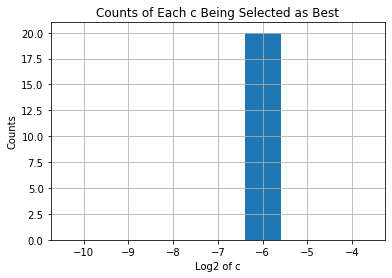

In [147]:
# Prints
best_cs = np.array(best_cs); best_cs_pow = np.log2(best_cs)

# Mean and std of the c
av_c = np.mean(best_cs); std_c = np.std(best_cs)

# Mean and std of the power
av_c_pow = np.mean(best_cs_pow); std_c_pow = np.std(best_cs_pow)

print(f"Average of the c is {av_c} with a standard deviation of {std_c}")
print(f"Average of the powers of c is {av_c_pow} with a standard deviation of {std_c_pow}")

# Mean and std of the errors
av_test = np.mean(c_errors); std_test = np.std(c_errors)
print(f"Average of the test errors is {av_test} with a standard deviation of {std_test}")

# Bar Chart
print("Best c's over cross validations (Log2)")
print(best_cs_pow)
c_pow_counts = np.zeros((len(c_pow_range)))
unique, counts = np.unique(best_cs_pow, return_counts = True)
for unique_pow_ind in range(len(unique)):
    unique_pow = unique[unique_pow_ind]
    loc = np.where(c_pow_range == unique_pow)[0]
    c_pow_counts[loc] = counts[unique_pow_ind]

plt.figure()
plt.title('Counts of Each c Being Selected as Best')
plt.bar(c_pow_range, c_pow_counts)
plt.xlabel('Log2 of c')
plt.ylabel('Counts')
plt.grid()

In [145]:
# Cross validation visualisation
av_val_error = np.mean(all_c_errors, axis = 1); std_val_error = np.std(all_c_errors, axis = 1)
plt.figure(figsize = (15,8))
plt.title('Average Validation Error Rate vs Log2 C')
plt.errorbar(c_pow_range, av_val_error, yerr = std_val_error, label = 'Val', elinewidth = 2.5, ecolor = 'b', color = 'orange')
plt.xlabel('Polynomial degree')
plt.ylabel('Error rate')
plt.legend()
plt.grid()